In [1]:
%load_ext autoreload
%autoreload 2

from config.rnn import default
from models import RNN
import numpy as np
from functional import seq
import tensorflow as tf
from tensorpack import (TrainConfig, SyncMultiGPUTrainer as Trainer, 
                        PredictConfig, MultiProcessDatasetPredictor as Predictor,
                        SaverRestore, logger)
from tensorpack.callbacks import (ScheduledHyperParamSetter, MaxSaver, ModelSaver,
                                  DataParallelInferenceRunner as InfRunner)
from tensorpack.predict import SimpleDatasetPredictor
from tensorpack.tfutils.common import get_default_sess_config
from utils import DataManager
from utils.validation import (Accumulator, AggregateMetric, calcu_metrics)
import pickle

resnet_loc = "./data/resnet_v2_101/resnet_v2_101.ckpt"
log_dir = 'train_log/sift-512-hidden-gls-r5/'
feature_loc = '/data/yangyang/10_labels_feature.pickle'
logger.set_logger_dir(log_dir)

with open(feature_loc, 'rb') as f:
    feature = pickle.load(f)

[1114 22:15:24 @logger.py:94] WRN Log directory train_log/sift-512-hidden-gls-r5/ exists! Please either backup/delete it, or use a new directory.
[1114 22:15:24 @logger.py:96] WRN If you're resuming from a previous run you can choose to keep it.
[1114 22:15:24 @logger.py:97] Select Action: k (keep) / b (backup) / d (delete) / n (new) / q (quit):
k
[1114 22:21:45 @logger.py:67] Existing log file 'train_log/sift-512-hidden-gls-r5/log.log' backuped to 'train_log/sift-512-hidden-gls-r5/log.log.1114-222145'
[1114 22:21:45 @logger.py:74] Argv: /home/yangyang/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py -f /run/user/1007/jupyter/kernel-e7d475b0-1365-4815-b5b2-b6c4a45352cd.json


In [4]:
config = default
config.proportion = {'train': 0.52, 'val': 0.00, 'test': 0.48}
config.stages = [2, 3, 4, 5, 6]
config.annotation_number = 30
config.weight_decay = 0.0
config.dropout_keep_prob = 0.5
config.doubly_stochastic_lambda = 0.5
config.gamma = 0
config.use_glimpse = True
config.use_hidden = True
config.read_time = 5
config.batch_size = 128
config.use_foreign = True

ignore_restore = ['learning_rate', 'global_step']
save_name = "max-micro_f1.tfmodel"
threshold = 0.5

data_manager = DataManager.from_config(config)
data_manager.override_feature(feature)
print(data_manager.get_num_info())
print(data_manager.get_imbalance_ratio())
train_data = data_manager.get_train_stream()
#val_data = data_manager.get_validation_stream()
test_data = data_manager.get_test_stream()

{'train': (4278, 18731), 'val': (0, 0), 'test': (4183, 18548)}
                                          train  val       test
amnioserosa                           21.051546  NaN  21.489247
anterior endoderm primordium          17.050633  NaN  17.427313
anterior midgut primordium             8.527840  NaN   8.865566
brain primordium                      12.667732  NaN  13.374570
cellular blastoderm                    9.434146  NaN   9.670918
dorsal prothoracic pharyngeal muscle  20.073892  NaN  19.915000
embryonic brain                        9.042254  NaN   8.912322
embryonic central nervous system      13.701031  NaN  13.780919
embryonic dorsal epidermis            12.452830  NaN  12.237342
embryonic foregut                     21.877005  NaN  21.132275
embryonic head epidermis              18.990654  NaN  18.365741
embryonic hindgut                     10.530997  NaN  10.951429
embryonic midgut                       6.082781  NaN   6.077834
embryonic ventral epidermis           14.

/home/yangyang/Documents/flyexpress/DL_biomedicine_image/utils/data_manager/__init__.py:182: RuntimeWarning: invalid value encountered in double_scalars
  posi_ratio = np.sum(binary_annot, axis=0) / binary_annot.shape[0]


In [39]:
model = RNN(config, label_weights=data_manager.get_imbalance_ratio().train.values)

In [40]:
tf.reset_default_graph()
train_config = TrainConfig(model=model, dataflow=train_data,
                           callbacks=[
                               ScheduledHyperParamSetter('learning_rate', [(0, 1e-3), (40, 1e-4)]),
                               InfRunner(val_data, [AggregateMetric(config.validation_metrics, threshold)],
                                         [1]),
                               ModelSaver(),
                               MaxSaver('micro_f1', save_name),
                           ],
                           #session_init=SaverRestore(
                           #    model_path=resnet_loc, ignore=ignore_restore),
                           max_epoch=200, tower=[1])
Trainer(train_config).train()

[1112 12:39:19 @inference_runner.py:82] InferenceRunner will eval on an InputSource of size 5
[1112 12:39:19 @input_source.py:180] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[1112 12:39:19 @training.py:90] Building graph for training tower 0 on device LeastLoadedDeviceSetter-/gpu:1...
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I

100%|##########|23/23[00:02<00:00, 7.69it/s]

[1112 12:39:25 @base.py:267] Epoch 1 (global_step 23) finished, time:2.98 sec.



100%|##########|5/5[00:01<00:00, 4.43it/s]

[1112 12:39:27 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-23.
[1112 12:39:27 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:27 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 22
[1112 12:39:27 @monitor.py:362] QueueInput/queue_size: 0.10396
[1112 12:39:27 @monitor.py:362] coverage: 5.2923
[1112 12:39:27 @monitor.py:362] doubly_stochastic_loss: 2.2009
[1112 12:39:27 @monitor.py:362] learning_rate: 0.001
[1112 12:39:27 @monitor.py:362] loss/value: 16.589
[1112 12:39:27 @monitor.py:362] macro_auc: 0.5316
[1112 12:39:27 @monitor.py:362] macro_f1: 0.25981
[1112 12:39:27 @monitor.py:362] mean_average_precision: 0.21665
[1112 12:39:27 @monitor.py:362] micro_auc: 0.54085
[1112 12:39:27 @monitor.py:362] micro_f1: 0.27998
[1112 12:39:27 @monitor.py:362] one_error: 0.8164
[1112 12:39:27 @monitor.py:362] ranking_loss: 0.46453
[1112 12:39:27 @monitor.py:362] ranking_mean_average_precision: 0.37101
[1112 12:39:27 @monitor.py:362] training


100%|##########|23/23[00:01<00:00,13.46it/s]

[1112 12:39:28 @base.py:267] Epoch 2 (global_step 46) finished, time:1.71 sec.



100%|##########|5/5[00:01<00:00, 4.62it/s]

[1112 12:39:29 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-46.
[1112 12:39:29 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:29 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 25.868
[1112 12:39:29 @monitor.py:362] QueueInput/queue_size: 1.5384
[1112 12:39:29 @monitor.py:362] coverage: 5.0695
[1112 12:39:29 @monitor.py:362] doubly_stochastic_loss: 1.5263
[1112 12:39:30 @monitor.py:362] learning_rate: 0.001
[1112 12:39:30 @monitor.py:362] loss/value: 15.72
[1112 12:39:30 @monitor.py:362] macro_auc: 0.55399
[1112 12:39:30 @monitor.py:362] macro_f1: 0.26322
[1112 12:39:30 @monitor.py:362] mean_average_precision: 0.2303
[1112 12:39:30 @monitor.py:362] micro_auc: 0.55819
[1112 12:39:30 @monitor.py:362] micro_f1: 0.28554
[1112 12:39:30 @monitor.py:362] one_error: 0.79679
[1112 12:39:30 @monitor.py:362] ranking_loss: 0.44512
[1112 12:39:30 @monitor.py:362] ranking_mean_average_precision: 0.38575
[1112 12:39:30 @monitor.py:362] train


100%|##########|23/23[00:01<00:00,15.41it/s]

[1112 12:39:31 @base.py:267] Epoch 3 (global_step 69) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00, 6.42it/s]

[1112 12:39:32 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-69.
[1112 12:39:32 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:32 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 35.145
[1112 12:39:32 @monitor.py:362] QueueInput/queue_size: 4.4666
[1112 12:39:32 @monitor.py:362] coverage: 4.8075
[1112 12:39:32 @monitor.py:362] doubly_stochastic_loss: 1.5848
[1112 12:39:32 @monitor.py:362] learning_rate: 0.001
[1112 12:39:32 @monitor.py:362] loss/value: 14.784
[1112 12:39:32 @monitor.py:362] macro_auc: 0.57669
[1112 12:39:32 @monitor.py:362] macro_f1: 0.27672
[1112 12:39:32 @monitor.py:362] mean_average_precision: 0.2431
[1112 12:39:32 @monitor.py:362] micro_auc: 0.58429
[1112 12:39:32 @monitor.py:362] micro_f1: 0.30125
[1112 12:39:32 @monitor.py:362] one_error: 0.76292
[1112 12:39:32 @monitor.py:362] ranking_loss: 0.41445
[1112 12:39:32 @monitor.py:362] ranking_mean_average_precision: 0.41645
[1112 12:39:32 @monitor.py:362] trai


100%|##########|23/23[00:01<00:00,14.84it/s]

[1112 12:39:34 @base.py:267] Epoch 4 (global_step 92) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00, 5.92it/s]

[1112 12:39:34 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-92.
[1112 12:39:34 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:34 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 41.393
[1112 12:39:34 @monitor.py:362] QueueInput/queue_size: 13.4
[1112 12:39:34 @monitor.py:362] coverage: 4.6952
[1112 12:39:34 @monitor.py:362] doubly_stochastic_loss: 0.35819
[1112 12:39:34 @monitor.py:362] learning_rate: 0.001
[1112 12:39:34 @monitor.py:362] loss/value: 13.923
[1112 12:39:34 @monitor.py:362] macro_auc: 0.6001
[1112 12:39:34 @monitor.py:362] macro_f1: 0.28868
[1112 12:39:34 @monitor.py:362] mean_average_precision: 0.26525
[1112 12:39:34 @monitor.py:362] micro_auc: 0.60312
[1112 12:39:34 @monitor.py:362] micro_f1: 0.3142
[1112 12:39:34 @monitor.py:362] one_error: 0.73262
[1112 12:39:34 @monitor.py:362] ranking_loss: 0.39982
[1112 12:39:34 @monitor.py:362] ranking_mean_average_precision: 0.42854
[1112 12:39:34 @monitor.py:362] traini


100%|##########|23/23[00:01<00:00,15.47it/s]

[1112 12:39:36 @base.py:267] Epoch 5 (global_step 115) finished, time:1.49 sec.



100%|##########|5/5[00:00<00:00, 6.28it/s]

[1112 12:39:37 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-115.
[1112 12:39:37 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:37 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 44.548
[1112 12:39:37 @monitor.py:362] QueueInput/queue_size: 24.395
[1112 12:39:37 @monitor.py:362] coverage: 4.5882
[1112 12:39:37 @monitor.py:362] doubly_stochastic_loss: 1.9687
[1112 12:39:37 @monitor.py:362] learning_rate: 0.001
[1112 12:39:37 @monitor.py:362] loss/value: 13.495
[1112 12:39:37 @monitor.py:362] macro_auc: 0.61991
[1112 12:39:37 @monitor.py:362] macro_f1: 0.30246
[1112 12:39:37 @monitor.py:362] mean_average_precision: 0.28015
[1112 12:39:37 @monitor.py:362] micro_auc: 0.62474
[1112 12:39:37 @monitor.py:362] micro_f1: 0.32676
[1112 12:39:37 @monitor.py:362] one_error: 0.72193
[1112 12:39:37 @monitor.py:362] ranking_loss: 0.38738
[1112 12:39:37 @monitor.py:362] ranking_mean_average_precision: 0.43639
[1112 12:39:37 @monitor.py:362] tr


100%|##########|23/23[00:01<00:00,14.27it/s]

[1112 12:39:39 @base.py:267] Epoch 6 (global_step 138) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00, 6.29it/s]

[1112 12:39:39 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-138.
[1112 12:39:39 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:39 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 46.308
[1112 12:39:39 @monitor.py:362] QueueInput/queue_size: 35.145
[1112 12:39:39 @monitor.py:362] coverage: 4.4225
[1112 12:39:39 @monitor.py:362] doubly_stochastic_loss: 0.59132
[1112 12:39:39 @monitor.py:362] learning_rate: 0.001
[1112 12:39:39 @monitor.py:362] loss/value: 13.046
[1112 12:39:39 @monitor.py:362] macro_auc: 0.64003
[1112 12:39:39 @monitor.py:362] macro_f1: 0.31295
[1112 12:39:39 @monitor.py:362] mean_average_precision: 0.29261
[1112 12:39:39 @monitor.py:362] micro_auc: 0.63834
[1112 12:39:39 @monitor.py:362] micro_f1: 0.33725
[1112 12:39:39 @monitor.py:362] one_error: 0.70232
[1112 12:39:39 @monitor.py:362] ranking_loss: 0.37079
[1112 12:39:39 @monitor.py:362] ranking_mean_average_precision: 0.44833
[1112 12:39:39 @monitor.py:362] t


100%|##########|23/23[00:01<00:00,14.74it/s]

[1112 12:39:41 @base.py:267] Epoch 7 (global_step 161) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00, 8.77it/s]

[1112 12:39:42 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-161.
[1112 12:39:42 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:42 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 47.459
[1112 12:39:42 @monitor.py:362] QueueInput/queue_size: 44.134
[1112 12:39:42 @monitor.py:362] coverage: 4.2246
[1112 12:39:42 @monitor.py:362] doubly_stochastic_loss: 0.39106
[1112 12:39:42 @monitor.py:362] learning_rate: 0.001
[1112 12:39:42 @monitor.py:362] loss/value: 12.58
[1112 12:39:42 @monitor.py:362] macro_auc: 0.65208
[1112 12:39:42 @monitor.py:362] macro_f1: 0.31809
[1112 12:39:42 @monitor.py:362] mean_average_precision: 0.30122
[1112 12:39:42 @monitor.py:362] micro_auc: 0.65205
[1112 12:39:42 @monitor.py:362] micro_f1: 0.34305
[1112 12:39:42 @monitor.py:362] one_error: 0.69875
[1112 12:39:42 @monitor.py:362] ranking_loss: 0.3535
[1112 12:39:42 @monitor.py:362] ranking_mean_average_precision: 0.46443
[1112 12:39:42 @monitor.py:362] tra


100%|##########|23/23[00:01<00:00,15.06it/s]

[1112 12:39:43 @base.py:267] Epoch 8 (global_step 184) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,11.13it/s]

[1112 12:39:44 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-184.
[1112 12:39:44 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:44 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 48.17
[1112 12:39:44 @monitor.py:362] QueueInput/queue_size: 48.008
[1112 12:39:44 @monitor.py:362] coverage: 4.0856
[1112 12:39:44 @monitor.py:362] doubly_stochastic_loss: 0.49059
[1112 12:39:44 @monitor.py:362] learning_rate: 0.001
[1112 12:39:44 @monitor.py:362] loss/value: 12.257
[1112 12:39:44 @monitor.py:362] macro_auc: 0.67736
[1112 12:39:44 @monitor.py:362] macro_f1: 0.33577
[1112 12:39:44 @monitor.py:362] mean_average_precision: 0.3298
[1112 12:39:44 @monitor.py:362] micro_auc: 0.67397
[1112 12:39:44 @monitor.py:362] micro_f1: 0.35945
[1112 12:39:44 @monitor.py:362] one_error: 0.65597
[1112 12:39:44 @monitor.py:362] ranking_loss: 0.3347
[1112 12:39:44 @monitor.py:362] ranking_mean_average_precision: 0.49144
[1112 12:39:44 @monitor.py:362] trai


100%|##########|23/23[00:01<00:00,15.02it/s]

[1112 12:39:45 @base.py:267] Epoch 9 (global_step 207) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,10.26it/s]

[1112 12:39:46 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-207.
[1112 12:39:46 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:46 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 48.697
[1112 12:39:46 @monitor.py:362] QueueInput/queue_size: 49.194
[1112 12:39:46 @monitor.py:362] coverage: 3.8681
[1112 12:39:46 @monitor.py:362] doubly_stochastic_loss: 0.94187
[1112 12:39:46 @monitor.py:362] learning_rate: 0.001
[1112 12:39:46 @monitor.py:362] loss/value: 12.083
[1112 12:39:46 @monitor.py:362] macro_auc: 0.69039
[1112 12:39:46 @monitor.py:362] macro_f1: 0.34531
[1112 12:39:46 @monitor.py:362] mean_average_precision: 0.33858
[1112 12:39:46 @monitor.py:362] micro_auc: 0.68944
[1112 12:39:46 @monitor.py:362] micro_f1: 0.36936
[1112 12:39:46 @monitor.py:362] one_error: 0.64349
[1112 12:39:46 @monitor.py:362] ranking_loss: 0.31304
[1112 12:39:46 @monitor.py:362] ranking_mean_average_precision: 0.50586
[1112 12:39:46 @monitor.py:362] t


100%|##########|23/23[00:01<00:00,14.75it/s]

[1112 12:39:47 @base.py:267] Epoch 10 (global_step 230) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00, 9.79it/s]

[1112 12:39:48 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-230.
[1112 12:39:48 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:48 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.021
[1112 12:39:48 @monitor.py:362] QueueInput/queue_size: 49.69
[1112 12:39:48 @monitor.py:362] coverage: 3.6506
[1112 12:39:48 @monitor.py:362] doubly_stochastic_loss: 2.2305
[1112 12:39:48 @monitor.py:362] learning_rate: 0.001
[1112 12:39:48 @monitor.py:362] loss/value: 11.947
[1112 12:39:48 @monitor.py:362] macro_auc: 0.71878
[1112 12:39:48 @monitor.py:362] macro_f1: 0.36459
[1112 12:39:48 @monitor.py:362] mean_average_precision: 0.37261
[1112 12:39:48 @monitor.py:362] micro_auc: 0.7151
[1112 12:39:48 @monitor.py:362] micro_f1: 0.38831
[1112 12:39:48 @monitor.py:362] one_error: 0.59537
[1112 12:39:48 @monitor.py:362] ranking_loss: 0.29091
[1112 12:39:48 @monitor.py:362] ranking_mean_average_precision: 0.53566
[1112 12:39:48 @monitor.py:362] trai


100%|##########|23/23[00:01<00:00,14.81it/s]

[1112 12:39:49 @base.py:267] Epoch 11 (global_step 253) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00, 9.27it/s]

[1112 12:39:50 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-253.
[1112 12:39:50 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:50 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.245
[1112 12:39:50 @monitor.py:362] QueueInput/queue_size: 49.829
[1112 12:39:50 @monitor.py:362] coverage: 3.7308
[1112 12:39:50 @monitor.py:362] doubly_stochastic_loss: 0.94944
[1112 12:39:50 @monitor.py:362] learning_rate: 0.001
[1112 12:39:50 @monitor.py:362] loss/value: 11.832
[1112 12:39:50 @monitor.py:362] macro_auc: 0.71687
[1112 12:39:50 @monitor.py:362] macro_f1: 0.3664
[1112 12:39:50 @monitor.py:362] mean_average_precision: 0.39021
[1112 12:39:50 @monitor.py:362] micro_auc: 0.71479
[1112 12:39:50 @monitor.py:362] micro_f1: 0.39206
[1112 12:39:50 @monitor.py:362] one_error: 0.6025
[1112 12:39:50 @monitor.py:362] ranking_loss: 0.29698
[1112 12:39:50 @monitor.py:362] ranking_mean_average_precision: 0.53163
[1112 12:39:50 @monitor.py:362] tra


100%|##########|23/23[00:01<00:00,15.21it/s]

[1112 12:39:52 @base.py:267] Epoch 12 (global_step 276) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,11.02it/s]

[1112 12:39:52 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-276.
[1112 12:39:52 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:52 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.452
[1112 12:39:52 @monitor.py:362] QueueInput/queue_size: 49.813
[1112 12:39:52 @monitor.py:362] coverage: 3.5989
[1112 12:39:52 @monitor.py:362] doubly_stochastic_loss: 0.44303
[1112 12:39:52 @monitor.py:362] learning_rate: 0.001
[1112 12:39:52 @monitor.py:362] loss/value: 11.468
[1112 12:39:52 @monitor.py:362] macro_auc: 0.72541
[1112 12:39:52 @monitor.py:362] macro_f1: 0.37237
[1112 12:39:52 @monitor.py:362] mean_average_precision: 0.37732
[1112 12:39:52 @monitor.py:362] micro_auc: 0.72178
[1112 12:39:52 @monitor.py:362] micro_f1: 0.39817
[1112 12:39:52 @monitor.py:362] one_error: 0.61141
[1112 12:39:52 @monitor.py:362] ranking_loss: 0.28949
[1112 12:39:52 @monitor.py:362] ranking_mean_average_precision: 0.53447
[1112 12:39:52 @monitor.py:362] t


100%|##########|23/23[00:01<00:00,15.04it/s]

[1112 12:39:54 @base.py:267] Epoch 13 (global_step 299) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,11.44it/s]

[1112 12:39:54 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-299.
[1112 12:39:54 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:54 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.6
[1112 12:39:54 @monitor.py:362] QueueInput/queue_size: 49.889
[1112 12:39:54 @monitor.py:362] coverage: 3.4332
[1112 12:39:54 @monitor.py:362] doubly_stochastic_loss: 0.63002
[1112 12:39:54 @monitor.py:362] learning_rate: 0.001
[1112 12:39:54 @monitor.py:362] loss/value: 11.433
[1112 12:39:54 @monitor.py:362] macro_auc: 0.75374
[1112 12:39:54 @monitor.py:362] macro_f1: 0.3907
[1112 12:39:54 @monitor.py:362] mean_average_precision: 0.41426
[1112 12:39:54 @monitor.py:362] micro_auc: 0.7438
[1112 12:39:54 @monitor.py:362] micro_f1: 0.41666
[1112 12:39:54 @monitor.py:362] one_error: 0.58467
[1112 12:39:54 @monitor.py:362] ranking_loss: 0.2697
[1112 12:39:54 @monitor.py:362] ranking_mean_average_precision: 0.55749
[1112 12:39:54 @monitor.py:362] traini


100%|##########|23/23[00:01<00:00,14.96it/s]

[1112 12:39:56 @base.py:267] Epoch 14 (global_step 322) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00,10.71it/s]

[1112 12:39:56 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-322.
[1112 12:39:56 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:39:56 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.708
[1112 12:39:56 @monitor.py:362] QueueInput/queue_size: 49.865
[1112 12:39:56 @monitor.py:362] coverage: 3.3583
[1112 12:39:56 @monitor.py:362] doubly_stochastic_loss: 0.3122
[1112 12:39:56 @monitor.py:362] learning_rate: 0.001
[1112 12:39:56 @monitor.py:362] loss/value: 11.265
[1112 12:39:56 @monitor.py:362] macro_auc: 0.7638
[1112 12:39:56 @monitor.py:362] macro_f1: 0.41018
[1112 12:39:56 @monitor.py:362] mean_average_precision: 0.43552
[1112 12:39:56 @monitor.py:362] micro_auc: 0.75627
[1112 12:39:56 @monitor.py:362] micro_f1: 0.43331
[1112 12:39:56 @monitor.py:362] one_error: 0.55437
[1112 12:39:56 @monitor.py:362] ranking_loss: 0.25773
[1112 12:39:56 @monitor.py:362] ranking_mean_average_precision: 0.57626
[1112 12:39:56 @monitor.py:362] tra


100%|##########|23/23[00:01<00:00,15.38it/s]

[1112 12:39:58 @base.py:267] Epoch 15 (global_step 345) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00, 9.58it/s]

[1112 12:39:58 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-345.
[1112 12:39:58 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.786
[1112 12:39:58 @monitor.py:362] QueueInput/queue_size: 49.864
[1112 12:39:58 @monitor.py:362] coverage: 3.2585
[1112 12:39:58 @monitor.py:362] doubly_stochastic_loss: 0.40232
[1112 12:39:58 @monitor.py:362] learning_rate: 0.001
[1112 12:39:58 @monitor.py:362] loss/value: 11.134
[1112 12:39:58 @monitor.py:362] macro_auc: 0.76047
[1112 12:39:58 @monitor.py:362] macro_f1: 0.40183
[1112 12:39:58 @monitor.py:362] mean_average_precision: 0.43673
[1112 12:39:58 @monitor.py:362] micro_auc: 0.75949
[1112 12:39:58 @monitor.py:362] micro_f1: 0.42836
[1112 12:39:58 @monitor.py:362] one_error: 0.56863
[1112 12:39:58 @monitor.py:362] ranking_loss: 0.25412
[1112 12:39:58 @monitor.py:362] ranking_mean_average_precision: 0.57763
[1112 12:39:58 @monitor.py:362] training_ap: 0.24423
[1112 12:39:58 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.29it/s]

[1112 12:40:00 @base.py:267] Epoch 16 (global_step 368) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,10.07it/s]

[1112 12:40:00 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-368.
[1112 12:40:00 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:00 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.8
[1112 12:40:00 @monitor.py:362] QueueInput/queue_size: 49.911
[1112 12:40:01 @monitor.py:362] coverage: 3.0927
[1112 12:40:01 @monitor.py:362] doubly_stochastic_loss: 0.54743
[1112 12:40:01 @monitor.py:362] learning_rate: 0.001
[1112 12:40:01 @monitor.py:362] loss/value: 10.897
[1112 12:40:01 @monitor.py:362] macro_auc: 0.77815
[1112 12:40:01 @monitor.py:362] macro_f1: 0.42091
[1112 12:40:01 @monitor.py:362] mean_average_precision: 0.45008
[1112 12:40:01 @monitor.py:362] micro_auc: 0.77569
[1112 12:40:01 @monitor.py:362] micro_f1: 0.44871
[1112 12:40:01 @monitor.py:362] one_error: 0.53654
[1112 12:40:01 @monitor.py:362] ranking_loss: 0.23815
[1112 12:40:01 @monitor.py:362] ranking_mean_average_precision: 0.601
[1112 12:40:01 @monitor.py:362] train


100%|##########|23/23[00:01<00:00,14.88it/s]

[1112 12:40:02 @base.py:267] Epoch 17 (global_step 391) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00, 9.11it/s]

[1112 12:40:03 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-391.
[1112 12:40:03 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:03 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.854
[1112 12:40:03 @monitor.py:362] QueueInput/queue_size: 49.863
[1112 12:40:03 @monitor.py:362] coverage: 3.0178
[1112 12:40:03 @monitor.py:362] doubly_stochastic_loss: 0.56378
[1112 12:40:03 @monitor.py:362] learning_rate: 0.001
[1112 12:40:03 @monitor.py:362] loss/value: 10.83
[1112 12:40:03 @monitor.py:362] macro_auc: 0.78975
[1112 12:40:03 @monitor.py:362] macro_f1: 0.4347
[1112 12:40:03 @monitor.py:362] mean_average_precision: 0.46679
[1112 12:40:03 @monitor.py:362] micro_auc: 0.78524
[1112 12:40:03 @monitor.py:362] micro_f1: 0.4625
[1112 12:40:03 @monitor.py:362] one_error: 0.54902
[1112 12:40:03 @monitor.py:362] ranking_loss: 0.2313
[1112 12:40:03 @monitor.py:362] ranking_mean_average_precision: 0.6004
[1112 12:40:03 @monitor.py:362] traini


100%|##########|23/23[00:01<00:00,13.37it/s]

[1112 12:40:04 @base.py:267] Epoch 18 (global_step 414) finished, time:1.72 sec.



100%|##########|5/5[00:00<00:00, 9.77it/s]

[1112 12:40:05 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-414.
[1112 12:40:05 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.852
[1112 12:40:05 @monitor.py:362] QueueInput/queue_size: 49.925
[1112 12:40:05 @monitor.py:362] coverage: 2.9447
[1112 12:40:05 @monitor.py:362] doubly_stochastic_loss: 0.38013
[1112 12:40:05 @monitor.py:362] learning_rate: 0.001
[1112 12:40:05 @monitor.py:362] loss/value: 10.68
[1112 12:40:05 @monitor.py:362] macro_auc: 0.7966
[1112 12:40:05 @monitor.py:362] macro_f1: 0.42921
[1112 12:40:05 @monitor.py:362] mean_average_precision: 0.4729
[1112 12:40:05 @monitor.py:362] micro_auc: 0.79275
[1112 12:40:05 @monitor.py:362] micro_f1: 0.45289
[1112 12:40:05 @monitor.py:362] one_error: 0.5205
[1112 12:40:05 @monitor.py:362] ranking_loss: 0.22273
[1112 12:40:05 @monitor.py:362] ranking_mean_average_precision: 0.61329
[1112 12:40:05 @monitor.py:362] training_ap: 0.25716
[1112 12:40:05 @monitor.py:362] training_auc: 0.629


100%|##########|23/23[00:01<00:00,14.32it/s]

[1112 12:40:07 @base.py:267] Epoch 19 (global_step 437) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00,10.58it/s]

[1112 12:40:07 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-437.
[1112 12:40:07 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:07 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.891
[1112 12:40:07 @monitor.py:362] QueueInput/queue_size: 49.895
[1112 12:40:07 @monitor.py:362] coverage: 2.7879
[1112 12:40:07 @monitor.py:362] doubly_stochastic_loss: 1.6106
[1112 12:40:07 @monitor.py:362] learning_rate: 0.001
[1112 12:40:07 @monitor.py:362] loss/value: 10.508
[1112 12:40:07 @monitor.py:362] macro_auc: 0.81195
[1112 12:40:07 @monitor.py:362] macro_f1: 0.45433
[1112 12:40:07 @monitor.py:362] mean_average_precision: 0.49792
[1112 12:40:07 @monitor.py:362] micro_auc: 0.80742
[1112 12:40:07 @monitor.py:362] micro_f1: 0.48097
[1112 12:40:07 @monitor.py:362] one_error: 0.49911
[1112 12:40:07 @monitor.py:362] ranking_loss: 0.20619
[1112 12:40:07 @monitor.py:362] ranking_mean_average_precision: 0.63216
[1112 12:40:07 @monitor.py:362] tr


100%|##########|23/23[00:01<00:00,14.98it/s]

[1112 12:40:09 @base.py:267] Epoch 20 (global_step 460) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.97it/s]

[1112 12:40:09 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-460.
[1112 12:40:09 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.92
[1112 12:40:09 @monitor.py:362] QueueInput/queue_size: 49.901
[1112 12:40:09 @monitor.py:362] coverage: 2.7986
[1112 12:40:09 @monitor.py:362] doubly_stochastic_loss: 0.50381
[1112 12:40:09 @monitor.py:362] learning_rate: 0.001
[1112 12:40:09 @monitor.py:362] loss/value: 10.267
[1112 12:40:09 @monitor.py:362] macro_auc: 0.79498
[1112 12:40:09 @monitor.py:362] macro_f1: 0.44499
[1112 12:40:09 @monitor.py:362] mean_average_precision: 0.48053
[1112 12:40:09 @monitor.py:362] micro_auc: 0.79628
[1112 12:40:09 @monitor.py:362] micro_f1: 0.47386
[1112 12:40:09 @monitor.py:362] one_error: 0.49911
[1112 12:40:09 @monitor.py:362] ranking_loss: 0.20499
[1112 12:40:09 @monitor.py:362] ranking_mean_average_precision: 0.63522
[1112 12:40:09 @monitor.py:362] training_ap: 0.26664
[1112 12:40:09 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,13.25it/s]

[1112 12:40:11 @base.py:267] Epoch 21 (global_step 483) finished, time:1.74 sec.



100%|##########|5/5[00:00<00:00, 9.91it/s]

[1112 12:40:12 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-483.
[1112 12:40:12 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:12 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.941
[1112 12:40:12 @monitor.py:362] QueueInput/queue_size: 49.872
[1112 12:40:12 @monitor.py:362] coverage: 2.8164
[1112 12:40:12 @monitor.py:362] doubly_stochastic_loss: 0.38275
[1112 12:40:12 @monitor.py:362] learning_rate: 0.001
[1112 12:40:12 @monitor.py:362] loss/value: 10.239
[1112 12:40:12 @monitor.py:362] macro_auc: 0.80532
[1112 12:40:12 @monitor.py:362] macro_f1: 0.45845
[1112 12:40:12 @monitor.py:362] mean_average_precision: 0.49821
[1112 12:40:12 @monitor.py:362] micro_auc: 0.80488
[1112 12:40:12 @monitor.py:362] micro_f1: 0.48606
[1112 12:40:12 @monitor.py:362] one_error: 0.50802
[1112 12:40:12 @monitor.py:362] ranking_loss: 0.21062
[1112 12:40:12 @monitor.py:362] ranking_mean_average_precision: 0.63134
[1112 12:40:12 @monitor.py:362] t


100%|##########|23/23[00:01<00:00,15.30it/s]

[1112 12:40:13 @base.py:267] Epoch 22 (global_step 506) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00, 8.40it/s]

[1112 12:40:14 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-506.
[1112 12:40:14 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:14 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.957
[1112 12:40:14 @monitor.py:362] QueueInput/queue_size: 49.857
[1112 12:40:14 @monitor.py:362] coverage: 2.7184
[1112 12:40:14 @monitor.py:362] doubly_stochastic_loss: 0.64213
[1112 12:40:14 @monitor.py:362] learning_rate: 0.001
[1112 12:40:14 @monitor.py:362] loss/value: 10.302
[1112 12:40:14 @monitor.py:362] macro_auc: 0.81784
[1112 12:40:14 @monitor.py:362] macro_f1: 0.46101
[1112 12:40:14 @monitor.py:362] mean_average_precision: 0.5031


[1112 12:40:14 @monitor.py:362] micro_auc: 0.81135
[1112 12:40:14 @monitor.py:362] micro_f1: 0.48974
[1112 12:40:14 @monitor.py:362] one_error: 0.50446
[1112 12:40:14 @monitor.py:362] ranking_loss: 0.20155
[1112 12:40:14 @monitor.py:362] ranking_mean_average_precision: 0.637
[1112 12:40:14 @monitor.py:362] training_ap: 0.27624
[1112 12:40:14 @monitor.py:362] training_auc: 0.65169
[1112 12:40:14 @base.py:257] Start Epoch 23 ...


100%|##########|23/23[00:01<00:00,13.74it/s]

[1112 12:40:16 @base.py:267] Epoch 23 (global_step 529) finished, time:1.68 sec.



100%|##########|5/5[00:00<00:00, 9.98it/s]

[1112 12:40:16 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-529.
[1112 12:40:16 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:16 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.925
[1112 12:40:16 @monitor.py:362] QueueInput/queue_size: 49.79
[1112 12:40:16 @monitor.py:362] coverage: 2.5989
[1112 12:40:16 @monitor.py:362] doubly_stochastic_loss: 1.033
[1112 12:40:16 @monitor.py:362] learning_rate: 0.001
[1112 12:40:16 @monitor.py:362] loss/value: 10.117
[1112 12:40:16 @monitor.py:362] macro_auc: 0.82343
[1112 12:40:16 @monitor.py:362] macro_f1: 0.46876
[1112 12:40:16 @monitor.py:362] mean_average_precision: 0.51718
[1112 12:40:16 @monitor.py:362] micro_auc: 0.81969
[1112 12:40:16 @monitor.py:362] micro_f1: 0.4955
[1112 12:40:16 @monitor.py:362] one_error: 0.46524
[1112 12:40:16 @monitor.py:362] ranking_loss: 0.18735
[1112 12:40:16 @monitor.py:362] ranking_mean_average_precision: 0.66262
[1112 12:40:16 @monitor.py:362] train


100%|##########|23/23[00:01<00:00,14.79it/s]

[1112 12:40:18 @base.py:267] Epoch 24 (global_step 552) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,10.55it/s]

[1112 12:40:18 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-552.
[1112 12:40:18 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.945
[1112 12:40:18 @monitor.py:362] QueueInput/queue_size: 49.776
[1112 12:40:18 @monitor.py:362] coverage: 2.6346
[1112 12:40:18 @monitor.py:362] doubly_stochastic_loss: 1.2159
[1112 12:40:18 @monitor.py:362] learning_rate: 0.001
[1112 12:40:18 @monitor.py:362] loss/value: 9.9693
[1112 12:40:18 @monitor.py:362] macro_auc: 0.82067
[1112 12:40:18 @monitor.py:362] macro_f1: 0.46765
[1112 12:40:18 @monitor.py:362] mean_average_precision: 0.49777
[1112 12:40:18 @monitor.py:362] micro_auc: 0.8182
[1112 12:40:18 @monitor.py:362] micro_f1: 0.493
[1112 12:40:18 @monitor.py:362] one_error: 0.48307
[1112 12:40:18 @monitor.py:362] ranking_loss: 0.19352
[1112 12:40:18 @monitor.py:362] ranking_mean_average_precision: 0.64797
[1112 12:40:18 @monitor.py:362] training_ap: 0.28649
[1112 12:40:18 @monitor.py:362] training_auc: 0.662


100%|##########|23/23[00:01<00:00,15.01it/s]

[1112 12:40:20 @base.py:267] Epoch 25 (global_step 575) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.00it/s]

[1112 12:40:20 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-575.
[1112 12:40:21 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:21 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.96
[1112 12:40:21 @monitor.py:362] QueueInput/queue_size: 49.837
[1112 12:40:21 @monitor.py:362] coverage: 2.5811
[1112 12:40:21 @monitor.py:362] doubly_stochastic_loss: 0.67098
[1112 12:40:21 @monitor.py:362] learning_rate: 0.001
[1112 12:40:21 @monitor.py:362] loss/value: 9.811
[1112 12:40:21 @monitor.py:362] macro_auc: 0.82276
[1112 12:40:21 @monitor.py:362] macro_f1: 0.48511
[1112 12:40:21 @monitor.py:362] mean_average_precision: 0.51613
[1112 12:40:21 @monitor.py:362] micro_auc: 0.82253
[1112 12:40:21 @monitor.py:362] micro_f1: 0.50737
[1112 12:40:21 @monitor.py:362] one_error: 0.48663
[1112 12:40:21 @monitor.py:362] ranking_loss: 0.1872
[1112 12:40:21 @monitor.py:362] ranking_mean_average_precision: 0.65526
[1112 12:40:21 @monitor.py:362] trai


100%|##########|23/23[00:01<00:00,15.24it/s]

[1112 12:40:22 @base.py:267] Epoch 26 (global_step 598) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00, 9.48it/s]

[1112 12:40:23 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-598.
[1112 12:40:23 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.97
[1112 12:40:23 @monitor.py:362] QueueInput/queue_size: 49.901
[1112 12:40:23 @monitor.py:362] coverage: 2.6203
[1112 12:40:23 @monitor.py:362] doubly_stochastic_loss: 0.83636
[1112 12:40:23 @monitor.py:362] learning_rate: 0.001
[1112 12:40:23 @monitor.py:362] loss/value: 9.7317
[1112 12:40:23 @monitor.py:362] macro_auc: 0.82332
[1112 12:40:23 @monitor.py:362] macro_f1: 0.48079
[1112 12:40:23 @monitor.py:362] mean_average_precision: 0.51727
[1112 12:40:23 @monitor.py:362] micro_auc: 0.82249
[1112 12:40:23 @monitor.py:362] micro_f1: 0.50419
[1112 12:40:23 @monitor.py:362] one_error: 0.48841
[1112 12:40:23 @monitor.py:362] ranking_loss: 0.19168
[1112 12:40:23 @monitor.py:362] ranking_mean_average_precision: 0.64994
[1112 12:40:23 @monitor.py:362] training_ap: 0.29685
[1112 12:40:23 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,13.28it/s]

[1112 12:40:24 @base.py:267] Epoch 27 (global_step 621) finished, time:1.73 sec.



100%|##########|5/5[00:00<00:00,11.22it/s]

[1112 12:40:25 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-621.
[1112 12:40:25 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:25 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.978
[1112 12:40:25 @monitor.py:362] QueueInput/queue_size: 49.969
[1112 12:40:25 @monitor.py:362] coverage: 2.5758
[1112 12:40:25 @monitor.py:362] doubly_stochastic_loss: 0.5926
[1112 12:40:25 @monitor.py:362] learning_rate: 0.001
[1112 12:40:25 @monitor.py:362] loss/value: 9.6516
[1112 12:40:25 @monitor.py:362] macro_auc: 0.82522
[1112 12:40:25 @monitor.py:362] macro_f1: 0.48581
[1112 12:40:25 @monitor.py:362] mean_average_precision: 0.52426
[1112 12:40:25 @monitor.py:362] micro_auc: 0.82651
[1112 12:40:25 @monitor.py:362] micro_f1: 0.50836
[1112 12:40:25 @monitor.py:362] one_error: 0.46346
[1112 12:40:25 @monitor.py:362] ranking_loss: 0.18605
[1112 12:40:25 @monitor.py:362] ranking_mean_average_precision: 0.66388
[1112 12:40:25 @monitor.py:362] tr


100%|##########|23/23[00:01<00:00,14.59it/s]

[1112 12:40:27 @base.py:267] Epoch 28 (global_step 644) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00, 9.64it/s]

[1112 12:40:27 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-644.
[1112 12:40:27 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.984
[1112 12:40:27 @monitor.py:362] QueueInput/queue_size: 49.851
[1112 12:40:27 @monitor.py:362] coverage: 2.5187
[1112 12:40:27 @monitor.py:362] doubly_stochastic_loss: 0.71291
[1112 12:40:27 @monitor.py:362] learning_rate: 0.001
[1112 12:40:27 @monitor.py:362] loss/value: 9.5763
[1112 12:40:27 @monitor.py:362] macro_auc: 0.82826
[1112 12:40:27 @monitor.py:362] macro_f1: 0.48542
[1112 12:40:27 @monitor.py:362] mean_average_precision: 0.52754
[1112 12:40:27 @monitor.py:362] micro_auc: 0.8283
[1112 12:40:27 @monitor.py:362] micro_f1: 0.50606
[1112 12:40:27 @monitor.py:362] one_error: 0.47059
[1112 12:40:27 @monitor.py:362] ranking_loss: 0.18339
[1112 12:40:27 @monitor.py:362] ranking_mean_average_precision: 0.66339
[1112 12:40:27 @monitor.py:362] training_ap: 0.30709
[1112 12:40:27 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.47it/s]

[1112 12:40:29 @base.py:267] Epoch 29 (global_step 667) finished, time:1.49 sec.



100%|##########|5/5[00:00<00:00, 9.22it/s]

[1112 12:40:29 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-667.
[1112 12:40:29 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:29 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.988
[1112 12:40:29 @monitor.py:362] QueueInput/queue_size: 49.799
[1112 12:40:29 @monitor.py:362] coverage: 2.5027
[1112 12:40:29 @monitor.py:362] doubly_stochastic_loss: 0.34534
[1112 12:40:29 @monitor.py:362] learning_rate: 0.001
[1112 12:40:29 @monitor.py:362] loss/value: 9.5652
[1112 12:40:29 @monitor.py:362] macro_auc: 0.83338
[1112 12:40:29 @monitor.py:362] macro_f1: 0.49854
[1112 12:40:29 @monitor.py:362] mean_average_precision: 0.52179
[1112 12:40:29 @monitor.py:362] micro_auc: 0.83181
[1112 12:40:29 @monitor.py:362] micro_f1: 0.517
[1112 12:40:29 @monitor.py:362] one_error: 0.48485
[1112 12:40:29 @monitor.py:362] ranking_loss: 0.18257
[1112 12:40:29 @monitor.py:362] ranking_mean_average_precision: 0.65631
[1112 12:40:29 @monitor.py:362] tra


100%|##########|23/23[00:01<00:00,13.93it/s]

[1112 12:40:31 @base.py:267] Epoch 30 (global_step 690) finished, time:1.65 sec.



100%|##########|5/5[00:00<00:00,10.04it/s]

[1112 12:40:31 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-690.
[1112 12:40:31 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:32 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.946
[1112 12:40:32 @monitor.py:362] QueueInput/queue_size: 49.938
[1112 12:40:32 @monitor.py:362] coverage: 2.4831
[1112 12:40:32 @monitor.py:362] doubly_stochastic_loss: 0.88693
[1112 12:40:32 @monitor.py:362] learning_rate: 0.001
[1112 12:40:32 @monitor.py:362] loss/value: 9.487
[1112 12:40:32 @monitor.py:362] macro_auc: 0.83521
[1112 12:40:32 @monitor.py:362] macro_f1: 0.49743
[1112 12:40:32 @monitor.py:362] mean_average_precision: 0.53768
[1112 12:40:32 @monitor.py:362] micro_auc: 0.83481
[1112 12:40:32 @monitor.py:362] micro_f1: 0.52273
[1112 12:40:32 @monitor.py:362] one_error: 0.47059
[1112 12:40:32 @monitor.py:362] ranking_loss: 0.18011
[1112 12:40:32 @monitor.py:362] ranking_mean_average_precision: 0.66367
[1112 12:40:32 @monitor.py:362] tr


100%|##########|23/23[00:01<00:00,14.50it/s]

[1112 12:40:33 @base.py:267] Epoch 31 (global_step 713) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00, 9.94it/s]

[1112 12:40:34 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-713.
[1112 12:40:34 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.96
[1112 12:40:34 @monitor.py:362] QueueInput/queue_size: 49.896
[1112 12:40:34 @monitor.py:362] coverage: 2.426
[1112 12:40:34 @monitor.py:362] doubly_stochastic_loss: 0.74929
[1112 12:40:34 @monitor.py:362] learning_rate: 0.001
[1112 12:40:34 @monitor.py:362] loss/value: 9.3071
[1112 12:40:34 @monitor.py:362] macro_auc: 0.83975
[1112 12:40:34 @monitor.py:362] macro_f1: 0.4984
[1112 12:40:34 @monitor.py:362] mean_average_precision: 0.53317
[1112 12:40:34 @monitor.py:362] micro_auc: 0.83858
[1112 12:40:34 @monitor.py:362] micro_f1: 0.52069
[1112 12:40:34 @monitor.py:362] one_error: 0.45098
[1112 12:40:34 @monitor.py:362] ranking_loss: 0.17386
[1112 12:40:34 @monitor.py:362] ranking_mean_average_precision: 0.67753
[1112 12:40:34 @monitor.py:362] training_ap: 0.32207
[1112 12:40:34 @monitor.py:362] training_auc: 0.69


100%|##########|23/23[00:01<00:00,14.88it/s]

[1112 12:40:35 @base.py:267] Epoch 32 (global_step 736) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00,10.98it/s]

[1112 12:40:36 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-736.
[1112 12:40:36 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.93
[1112 12:40:36 @monitor.py:362] QueueInput/queue_size: 49.949
[1112 12:40:36 @monitor.py:362] coverage: 2.4189
[1112 12:40:36 @monitor.py:362] doubly_stochastic_loss: 0.23933
[1112 12:40:36 @monitor.py:362] learning_rate: 0.001
[1112 12:40:36 @monitor.py:362] loss/value: 9.166
[1112 12:40:36 @monitor.py:362] macro_auc: 0.82832
[1112 12:40:36 @monitor.py:362] macro_f1: 0.49073
[1112 12:40:36 @monitor.py:362] mean_average_precision: 0.52381
[1112 12:40:36 @monitor.py:362] micro_auc: 0.83365
[1112 12:40:36 @monitor.py:362] micro_f1: 0.52184
[1112 12:40:36 @monitor.py:362] one_error: 0.45455
[1112 12:40:36 @monitor.py:362] ranking_loss: 0.17305
[1112 12:40:36 @monitor.py:362] ranking_mean_average_precision: 0.67858
[1112 12:40:36 @monitor.py:362] training_ap: 0.32727
[1112 12:40:36 @monitor.py:362] training_auc: 0.6


100%|##########|23/23[00:01<00:00,14.77it/s]

[1112 12:40:37 @base.py:267] Epoch 33 (global_step 759) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00,10.01it/s]

[1112 12:40:38 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-759.
[1112 12:40:38 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:38 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.949
[1112 12:40:38 @monitor.py:362] QueueInput/queue_size: 49.853
[1112 12:40:38 @monitor.py:362] coverage: 2.3975
[1112 12:40:38 @monitor.py:362] doubly_stochastic_loss: 0.91813
[1112 12:40:38 @monitor.py:362] learning_rate: 0.001
[1112 12:40:38 @monitor.py:362] loss/value: 9.0396
[1112 12:40:38 @monitor.py:362] macro_auc: 0.83744
[1112 12:40:38 @monitor.py:362] macro_f1: 0.51018
[1112 12:40:38 @monitor.py:362] mean_average_precision: 0.53113
[1112 12:40:38 @monitor.py:362] micro_auc: 0.83911
[1112 12:40:38 @monitor.py:362] micro_f1: 0.53554
[1112 12:40:38 @monitor.py:362] one_error: 0.46881
[1112 12:40:38 @monitor.py:362] ranking_loss: 0.17416
[1112 12:40:38 @monitor.py:362] ranking_mean_average_precision: 0.67352
[1112 12:40:38 @monitor.py:362] t


100%|##########|23/23[00:01<00:00,14.41it/s]

[1112 12:40:40 @base.py:267] Epoch 34 (global_step 782) finished, time:1.63 sec.



100%|##########|5/5[00:00<00:00, 9.29it/s]

[1112 12:40:40 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-782.
[1112 12:40:40 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.922
[1112 12:40:40 @monitor.py:362] QueueInput/queue_size: 49.892
[1112 12:40:40 @monitor.py:362] coverage: 2.4189
[1112 12:40:40 @monitor.py:362] doubly_stochastic_loss: 0.90445
[1112 12:40:40 @monitor.py:362] learning_rate: 0.001
[1112 12:40:40 @monitor.py:362] loss/value: 8.9312
[1112 12:40:40 @monitor.py:362] macro_auc: 0.83546
[1112 12:40:40 @monitor.py:362] macro_f1: 0.5062
[1112 12:40:40 @monitor.py:362] mean_average_precision: 0.53282
[1112 12:40:40 @monitor.py:362] micro_auc: 0.83401
[1112 12:40:40 @monitor.py:362] micro_f1: 0.52502
[1112 12:40:40 @monitor.py:362] one_error: 0.46702
[1112 12:40:40 @monitor.py:362] ranking_loss: 0.17612
[1112 12:40:40 @monitor.py:362] ranking_mean_average_precision: 0.6692
[1112 12:40:40 @monitor.py:362] training_ap: 0.33803
[1112 12:40:40 @monitor.py:362] training_auc: 0.7


100%|##########|23/23[00:01<00:00,16.26it/s]

[1112 12:40:42 @base.py:267] Epoch 35 (global_step 805) finished, time:1.42 sec.



100%|##########|5/5[00:00<00:00, 9.12it/s]

[1112 12:40:42 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-805.
[1112 12:40:42 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:42 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.942
[1112 12:40:42 @monitor.py:362] QueueInput/queue_size: 49.909
[1112 12:40:42 @monitor.py:362] coverage: 2.262
[1112 12:40:42 @monitor.py:362] doubly_stochastic_loss: 1.1412
[1112 12:40:42 @monitor.py:362] learning_rate: 0.001
[1112 12:40:42 @monitor.py:362] loss/value: 8.9766
[1112 12:40:42 @monitor.py:362] macro_auc: 0.84643
[1112 12:40:42 @monitor.py:362] macro_f1: 0.51787
[1112 12:40:42 @monitor.py:362] mean_average_precision: 0.55443
[1112 12:40:42 @monitor.py:362] micro_auc: 0.84789
[1112 12:40:42 @monitor.py:362] micro_f1: 0.54294
[1112 12:40:42 @monitor.py:362] one_error: 0.44385
[1112 12:40:42 @monitor.py:362] ranking_loss: 0.15939
[1112 12:40:42 @monitor.py:362] ranking_mean_average_precision: 0.69035
[1112 12:40:42 @monitor.py:362] tra


100%|##########|23/23[00:01<00:00,15.66it/s]

[1112 12:40:44 @base.py:267] Epoch 36 (global_step 828) finished, time:1.47 sec.



100%|##########|5/5[00:00<00:00, 9.75it/s]

[1112 12:40:44 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-828.
[1112 12:40:44 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.958
[1112 12:40:44 @monitor.py:362] QueueInput/queue_size: 49.922
[1112 12:40:44 @monitor.py:362] coverage: 2.3743
[1112 12:40:44 @monitor.py:362] doubly_stochastic_loss: 0.92354
[1112 12:40:44 @monitor.py:362] learning_rate: 0.001
[1112 12:40:44 @monitor.py:362] loss/value: 8.9025
[1112 12:40:44 @monitor.py:362] macro_auc: 0.8389
[1112 12:40:44 @monitor.py:362] macro_f1: 0.51447
[1112 12:40:44 @monitor.py:362] mean_average_precision: 0.55171
[1112 12:40:44 @monitor.py:362] micro_auc: 0.8439
[1112 12:40:44 @monitor.py:362] micro_f1: 0.53947
[1112 12:40:44 @monitor.py:362] one_error: 0.45098
[1112 12:40:44 @monitor.py:362] ranking_loss: 0.16971
[1112 12:40:44 @monitor.py:362] ranking_mean_average_precision: 0.68235
[1112 12:40:44 @monitor.py:362] training_ap: 0.34899
[1112 12:40:44 @monitor.py:362] training_auc: 0.7


100%|##########|23/23[00:01<00:00,15.10it/s]

[1112 12:40:46 @base.py:267] Epoch 37 (global_step 851) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,10.20it/s]

[1112 12:40:46 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-851.
[1112 12:40:46 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.969
[1112 12:40:46 @monitor.py:362] QueueInput/queue_size: 49.856
[1112 12:40:46 @monitor.py:362] coverage: 2.3405
[1112 12:40:46 @monitor.py:362] doubly_stochastic_loss: 0.50926
[1112 12:40:46 @monitor.py:362] learning_rate: 0.001
[1112 12:40:46 @monitor.py:362] loss/value: 8.7674
[1112 12:40:46 @monitor.py:362] macro_auc: 0.84194
[1112 12:40:46 @monitor.py:362] macro_f1: 0.51705
[1112 12:40:46 @monitor.py:362] mean_average_precision: 0.54817
[1112 12:40:46 @monitor.py:362] micro_auc: 0.84594
[1112 12:40:46 @monitor.py:362] micro_f1: 0.54241
[1112 12:40:46 @monitor.py:362] one_error: 0.42068
[1112 12:40:46 @monitor.py:362] ranking_loss: 0.16335
[1112 12:40:46 @monitor.py:362] ranking_mean_average_precision: 0.69517
[1112 12:40:46 @monitor.py:362] training_ap: 0.35407
[1112 12:40:46 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.56it/s]

[1112 12:40:48 @base.py:267] Epoch 38 (global_step 874) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,11.13it/s]

[1112 12:40:48 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-874.
[1112 12:40:48 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.977
[1112 12:40:48 @monitor.py:362] QueueInput/queue_size: 49.823
[1112 12:40:48 @monitor.py:362] coverage: 2.3387
[1112 12:40:48 @monitor.py:362] doubly_stochastic_loss: 0.18487
[1112 12:40:48 @monitor.py:362] learning_rate: 0.001
[1112 12:40:48 @monitor.py:362] loss/value: 8.688
[1112 12:40:48 @monitor.py:362] macro_auc: 0.83902
[1112 12:40:48 @monitor.py:362] macro_f1: 0.50962
[1112 12:40:48 @monitor.py:362] mean_average_precision: 0.56115
[1112 12:40:48 @monitor.py:362] micro_auc: 0.84589
[1112 12:40:48 @monitor.py:362] micro_f1: 0.53077
[1112 12:40:48 @monitor.py:362] one_error: 0.45633
[1112 12:40:48 @monitor.py:362] ranking_loss: 0.16675
[1112 12:40:48 @monitor.py:362] ranking_mean_average_precision: 0.68353
[1112 12:40:48 @monitor.py:362] training_ap: 0.35894
[1112 12:40:48 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.26it/s]

[1112 12:40:50 @base.py:267] Epoch 39 (global_step 897) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00, 9.50it/s]

[1112 12:40:50 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-897.
[1112 12:40:50 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:40:50 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.983
[1112 12:40:51 @monitor.py:362] QueueInput/queue_size: 49.843
[1112 12:40:51 @monitor.py:362] coverage: 2.3066
[1112 12:40:51 @monitor.py:362] doubly_stochastic_loss: 0.28136
[1112 12:40:51 @monitor.py:362] learning_rate: 0.001
[1112 12:40:51 @monitor.py:362] loss/value: 8.6048
[1112 12:40:51 @monitor.py:362] macro_auc: 0.84502
[1112 12:40:51 @monitor.py:362] macro_f1: 0.51934
[1112 12:40:51 @monitor.py:362] mean_average_precision: 0.54519
[1112 12:40:51 @monitor.py:362] micro_auc: 0.84671
[1112 12:40:51 @monitor.py:362] micro_f1: 0.54735
[1112 12:40:51 @monitor.py:362] one_error: 0.45098
[1112 12:40:51 @monitor.py:362] ranking_loss: 0.16323
[1112 12:40:51 @monitor.py:362] ranking_mean_average_precision: 0.68454
[1112 12:40:51 @monitor.py:362] t


100%|##########|23/23[00:01<00:00,13.88it/s]

[1112 12:40:52 @base.py:267] Epoch 40 (global_step 920) finished, time:1.66 sec.
[1112 12:40:52 @param.py:144] After epoch 40, learning_rate will change to 0.00010000



100%|##########|5/5[00:00<00:00,10.65it/s]

[1112 12:40:53 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-920.
[1112 12:40:53 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.988
[1112 12:40:53 @monitor.py:362] QueueInput/queue_size: 49.909
[1112 12:40:53 @monitor.py:362] coverage: 2.2692
[1112 12:40:53 @monitor.py:362] doubly_stochastic_loss: 0.36656
[1112 12:40:53 @monitor.py:362] learning_rate: 0.001
[1112 12:40:53 @monitor.py:362] loss/value: 8.5931
[1112 12:40:53 @monitor.py:362] macro_auc: 0.83942
[1112 12:40:53 @monitor.py:362] macro_f1: 0.51572
[1112 12:40:53 @monitor.py:362] mean_average_precision: 0.53661
[1112 12:40:53 @monitor.py:362] micro_auc: 0.84654
[1112 12:40:53 @monitor.py:362] micro_f1: 0.53958
[1112 12:40:53 @monitor.py:362] one_error: 0.44385
[1112 12:40:53 @monitor.py:362] ranking_loss: 0.15841
[1112 12:40:53 @monitor.py:362] ranking_mean_average_precision: 0.6935
[1112 12:40:53 @monitor.py:362] training_ap: 0.36862
[1112 12:40:53 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.66it/s]

[1112 12:40:54 @base.py:267] Epoch 41 (global_step 943) finished, time:1.59 sec.



100%|##########|5/5[00:00<00:00,10.31it/s]

[1112 12:40:55 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-943.
[1112 12:40:55 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.991
[1112 12:40:55 @monitor.py:362] QueueInput/queue_size: 49.951
[1112 12:40:55 @monitor.py:362] coverage: 2.2638
[1112 12:40:55 @monitor.py:362] doubly_stochastic_loss: 0.63376
[1112 12:40:55 @monitor.py:362] learning_rate: 0.0001
[1112 12:40:55 @monitor.py:362] loss/value: 8.4749
[1112 12:40:55 @monitor.py:362] macro_auc: 0.84135
[1112 12:40:55 @monitor.py:362] macro_f1: 0.52217
[1112 12:40:55 @monitor.py:362] mean_average_precision: 0.54535
[1112 12:40:55 @monitor.py:362] micro_auc: 0.84729
[1112 12:40:55 @monitor.py:362] micro_f1: 0.54289
[1112 12:40:55 @monitor.py:362] one_error: 0.43672
[1112 12:40:55 @monitor.py:362] ranking_loss: 0.15669
[1112 12:40:55 @monitor.py:362] ranking_mean_average_precision: 0.69773
[1112 12:40:55 @monitor.py:362] training_ap: 0.37349
[1112 12:40:55 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.04it/s]

[1112 12:40:56 @base.py:267] Epoch 42 (global_step 966) finished, time:1.64 sec.



100%|##########|5/5[00:00<00:00, 9.00it/s]

[1112 12:40:57 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-966.
[1112 12:40:57 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.993
[1112 12:40:57 @monitor.py:362] QueueInput/queue_size: 49.907
[1112 12:40:57 @monitor.py:362] coverage: 2.2371
[1112 12:40:57 @monitor.py:362] doubly_stochastic_loss: 0.94349
[1112 12:40:57 @monitor.py:362] learning_rate: 0.0001
[1112 12:40:57 @monitor.py:362] loss/value: 8.6083
[1112 12:40:57 @monitor.py:362] macro_auc: 0.83893
[1112 12:40:57 @monitor.py:362] macro_f1: 0.51987
[1112 12:40:57 @monitor.py:362] mean_average_precision: 0.54236
[1112 12:40:57 @monitor.py:362] micro_auc: 0.84601
[1112 12:40:57 @monitor.py:362] micro_f1: 0.54552
[1112 12:40:57 @monitor.py:362] one_error: 0.42781
[1112 12:40:57 @monitor.py:362] ranking_loss: 0.15551
[1112 12:40:57 @monitor.py:362] ranking_mean_average_precision: 0.70374
[1112 12:40:57 @monitor.py:362] training_ap: 0.37804
[1112 12:40:57 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.27it/s]

[1112 12:40:59 @base.py:267] Epoch 43 (global_step 989) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00,10.94it/s]

[1112 12:40:59 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-989.
[1112 12:40:59 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.954
[1112 12:40:59 @monitor.py:362] QueueInput/queue_size: 49.954
[1112 12:40:59 @monitor.py:362] coverage: 2.2727
[1112 12:40:59 @monitor.py:362] doubly_stochastic_loss: 0.96519
[1112 12:40:59 @monitor.py:362] learning_rate: 0.0001
[1112 12:40:59 @monitor.py:362] loss/value: 8.6343
[1112 12:40:59 @monitor.py:362] macro_auc: 0.84163
[1112 12:40:59 @monitor.py:362] macro_f1: 0.51906
[1112 12:40:59 @monitor.py:362] mean_average_precision: 0.53486
[1112 12:40:59 @monitor.py:362] micro_auc: 0.84772
[1112 12:40:59 @monitor.py:362] micro_f1: 0.54452
[1112 12:40:59 @monitor.py:362] one_error: 0.44563
[1112 12:40:59 @monitor.py:362] ranking_loss: 0.16214
[1112 12:40:59 @monitor.py:362] ranking_mean_average_precision: 0.69157
[1112 12:40:59 @monitor.py:362] training_ap: 0.38244
[1112 12:40:59 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.72it/s]

[1112 12:41:01 @base.py:267] Epoch 44 (global_step 1012) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,10.00it/s]

[1112 12:41:01 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1012.
[1112 12:41:01 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:41:01 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.966
[1112 12:41:01 @monitor.py:362] QueueInput/queue_size: 49.86
[1112 12:41:01 @monitor.py:362] coverage: 2.2852
[1112 12:41:01 @monitor.py:362] doubly_stochastic_loss: 1.2922
[1112 12:41:01 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:01 @monitor.py:362] loss/value: 8.4757
[1112 12:41:01 @monitor.py:362] macro_auc: 0.84586
[1112 12:41:01 @monitor.py:362] macro_f1: 0.52501
[1112 12:41:01 @monitor.py:362] mean_average_precision: 0.55405
[1112 12:41:01 @monitor.py:362] micro_auc: 0.85155
[1112 12:41:01 @monitor.py:362] micro_f1: 0.54849
[1112 12:41:01 @monitor.py:362] one_error: 0.44563
[1112 12:41:01 @monitor.py:362] ranking_loss: 0.15944
[1112 12:41:01 @monitor.py:362] ranking_mean_average_precision: 0.69121
[1112 12:41:01 @monitor.py:362] t


100%|##########|23/23[00:01<00:00,13.55it/s]

[1112 12:41:03 @base.py:267] Epoch 45 (global_step 1035) finished, time:1.70 sec.



100%|##########|5/5[00:00<00:00,11.11it/s]

[1112 12:41:04 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1035.
[1112 12:41:04 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:41:04 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.975
[1112 12:41:04 @monitor.py:362] QueueInput/queue_size: 49.92
[1112 12:41:04 @monitor.py:362] coverage: 2.2513
[1112 12:41:04 @monitor.py:362] doubly_stochastic_loss: 0.51632
[1112 12:41:04 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:04 @monitor.py:362] loss/value: 8.4033
[1112 12:41:04 @monitor.py:362] macro_auc: 0.85326
[1112 12:41:04 @monitor.py:362] macro_f1: 0.53011
[1112 12:41:04 @monitor.py:362] mean_average_precision: 0.56217
[1112 12:41:04 @monitor.py:362] micro_auc: 0.8522
[1112 12:41:04 @monitor.py:362] micro_f1: 0.55115
[1112 12:41:04 @monitor.py:362] one_error: 0.42781
[1112 12:41:04 @monitor.py:362] ranking_loss: 0.1555
[1112 12:41:04 @monitor.py:362] ranking_mean_average_precision: 0.69974
[1112 12:41:04 @monitor.py:362] tr


100%|##########|23/23[00:01<00:00,13.89it/s]

[1112 12:41:05 @base.py:267] Epoch 46 (global_step 1058) finished, time:1.66 sec.



100%|##########|5/5[00:00<00:00,10.41it/s]

[1112 12:41:06 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1058.
[1112 12:41:06 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.982
[1112 12:41:06 @monitor.py:362] QueueInput/queue_size: 49.957
[1112 12:41:06 @monitor.py:362] coverage: 2.2246
[1112 12:41:06 @monitor.py:362] doubly_stochastic_loss: 1.1229
[1112 12:41:06 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:06 @monitor.py:362] loss/value: 8.4487
[1112 12:41:06 @monitor.py:362] macro_auc: 0.85041
[1112 12:41:06 @monitor.py:362] macro_f1: 0.52455
[1112 12:41:06 @monitor.py:362] mean_average_precision: 0.57069
[1112 12:41:06 @monitor.py:362] micro_auc: 0.85252
[1112 12:41:06 @monitor.py:362] micro_f1: 0.54825
[1112 12:41:06 @monitor.py:362] one_error: 0.44385
[1112 12:41:06 @monitor.py:362] ranking_loss: 0.15208
[1112 12:41:06 @monitor.py:362] ranking_mean_average_precision: 0.69777
[1112 12:41:06 @monitor.py:362] training_ap: 0.39513
[1112 12:41:06 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.48it/s]

[1112 12:41:07 @base.py:267] Epoch 47 (global_step 1081) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00, 9.37it/s]

[1112 12:41:08 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1081.
[1112 12:41:08 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.987
[1112 12:41:08 @monitor.py:362] QueueInput/queue_size: 49.97
[1112 12:41:08 @monitor.py:362] coverage: 2.2282
[1112 12:41:08 @monitor.py:362] doubly_stochastic_loss: 0.69791
[1112 12:41:08 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:08 @monitor.py:362] loss/value: 8.4472
[1112 12:41:08 @monitor.py:362] macro_auc: 0.84787
[1112 12:41:08 @monitor.py:362] macro_f1: 0.52087
[1112 12:41:08 @monitor.py:362] mean_average_precision: 0.56207
[1112 12:41:08 @monitor.py:362] micro_auc: 0.85185
[1112 12:41:08 @monitor.py:362] micro_f1: 0.54174
[1112 12:41:08 @monitor.py:362] one_error: 0.45276
[1112 12:41:08 @monitor.py:362] ranking_loss: 0.15546
[1112 12:41:08 @monitor.py:362] ranking_mean_average_precision: 0.69119
[1112 12:41:08 @monitor.py:362] training_ap: 0.39884
[1112 12:41:08 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.85it/s]

[1112 12:41:10 @base.py:267] Epoch 48 (global_step 1104) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00,10.05it/s]

[1112 12:41:10 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1104.
[1112 12:41:10 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.99
[1112 12:41:10 @monitor.py:362] QueueInput/queue_size: 49.818
[1112 12:41:10 @monitor.py:362] coverage: 2.246
[1112 12:41:10 @monitor.py:362] doubly_stochastic_loss: 0.56201
[1112 12:41:10 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:10 @monitor.py:362] loss/value: 8.4616
[1112 12:41:10 @monitor.py:362] macro_auc: 0.8503
[1112 12:41:10 @monitor.py:362] macro_f1: 0.52981
[1112 12:41:10 @monitor.py:362] mean_average_precision: 0.55505
[1112 12:41:10 @monitor.py:362] micro_auc: 0.85355
[1112 12:41:10 @monitor.py:362] micro_f1: 0.55081
[1112 12:41:10 @monitor.py:362] one_error: 0.45455
[1112 12:41:10 @monitor.py:362] ranking_loss: 0.15732
[1112 12:41:10 @monitor.py:362] ranking_mean_average_precision: 0.68918
[1112 12:41:10 @monitor.py:362] training_ap: 0.4026
[1112 12:41:10 @monitor.py:362] training_auc: 0.7


100%|##########|23/23[00:01<00:00,14.64it/s]

[1112 12:41:12 @base.py:267] Epoch 49 (global_step 1127) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,10.42it/s]

[1112 12:41:12 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1127.
[1112 12:41:12 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:41:12 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.907
[1112 12:41:12 @monitor.py:362] QueueInput/queue_size: 49.917
[1112 12:41:12 @monitor.py:362] coverage: 2.1729
[1112 12:41:12 @monitor.py:362] doubly_stochastic_loss: 0.751
[1112 12:41:12 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:12 @monitor.py:362] loss/value: 8.4813
[1112 12:41:12 @monitor.py:362] macro_auc: 0.84837
[1112 12:41:12 @monitor.py:362] macro_f1: 0.54095
[1112 12:41:12 @monitor.py:362] mean_average_precision: 0.56065
[1112 12:41:12 @monitor.py:362] micro_auc: 0.85472
[1112 12:41:12 @monitor.py:362] micro_f1: 0.56079
[1112 12:41:12 @monitor.py:362] one_error: 0.43672
[1112 12:41:12 @monitor.py:362] ranking_loss: 0.14944
[1112 12:41:12 @monitor.py:362] ranking_mean_average_precision: 0.70116
[1112 12:41:12 @monitor.py:362] t


100%|##########|23/23[00:01<00:00,14.90it/s]

[1112 12:41:14 @base.py:267] Epoch 50 (global_step 1150) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00, 9.96it/s]

[1112 12:41:14 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1150.
[1112 12:41:14 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.886
[1112 12:41:14 @monitor.py:362] QueueInput/queue_size: 49.917
[1112 12:41:14 @monitor.py:362] coverage: 2.1462
[1112 12:41:14 @monitor.py:362] doubly_stochastic_loss: 0.7949
[1112 12:41:14 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:14 @monitor.py:362] loss/value: 8.4805
[1112 12:41:14 @monitor.py:362] macro_auc: 0.85739
[1112 12:41:14 @monitor.py:362] macro_f1: 0.53779
[1112 12:41:14 @monitor.py:362] mean_average_precision: 0.58227
[1112 12:41:14 @monitor.py:362] micro_auc: 0.86292
[1112 12:41:14 @monitor.py:362] micro_f1: 0.55615
[1112 12:41:14 @monitor.py:362] one_error: 0.42602
[1112 12:41:14 @monitor.py:362] ranking_loss: 0.14589
[1112 12:41:14 @monitor.py:362] ranking_mean_average_precision: 0.70702
[1112 12:41:14 @monitor.py:362] training_ap: 0.40926
[1112 12:41:14 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.08it/s]

[1112 12:41:16 @base.py:267] Epoch 51 (global_step 1173) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00, 9.90it/s]

[1112 12:41:16 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1173.
[1112 12:41:16 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.876
[1112 12:41:16 @monitor.py:362] QueueInput/queue_size: 49.902
[1112 12:41:16 @monitor.py:362] coverage: 2.2709
[1112 12:41:16 @monitor.py:362] doubly_stochastic_loss: 0.83544
[1112 12:41:16 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:16 @monitor.py:362] loss/value: 8.4131
[1112 12:41:16 @monitor.py:362] macro_auc: 0.8353
[1112 12:41:16 @monitor.py:362] macro_f1: 0.51835
[1112 12:41:16 @monitor.py:362] mean_average_precision: 0.54329
[1112 12:41:16 @monitor.py:362] micro_auc: 0.84568
[1112 12:41:16 @monitor.py:362] micro_f1: 0.54532
[1112 12:41:16 @monitor.py:362] one_error: 0.43672
[1112 12:41:16 @monitor.py:362] ranking_loss: 0.15973
[1112 12:41:16 @monitor.py:362] ranking_mean_average_precision: 0.69699
[1112 12:41:16 @monitor.py:362] training_ap: 0.41251
[1112 12:41:16 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,16.01it/s]

[1112 12:41:18 @base.py:267] Epoch 52 (global_step 1196) finished, time:1.44 sec.



100%|##########|5/5[00:00<00:00, 9.54it/s]

[1112 12:41:18 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1196.
[1112 12:41:18 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.868
[1112 12:41:18 @monitor.py:362] QueueInput/queue_size: 49.837
[1112 12:41:18 @monitor.py:362] coverage: 2.1836
[1112 12:41:18 @monitor.py:362] doubly_stochastic_loss: 0.29857
[1112 12:41:18 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:18 @monitor.py:362] loss/value: 8.3998
[1112 12:41:18 @monitor.py:362] macro_auc: 0.84839
[1112 12:41:18 @monitor.py:362] macro_f1: 0.52654
[1112 12:41:18 @monitor.py:362] mean_average_precision: 0.55246
[1112 12:41:18 @monitor.py:362] micro_auc: 0.85254
[1112 12:41:18 @monitor.py:362] micro_f1: 0.54929
[1112 12:41:18 @monitor.py:362] one_error: 0.4385
[1112 12:41:18 @monitor.py:362] ranking_loss: 0.14957
[1112 12:41:18 @monitor.py:362] ranking_mean_average_precision: 0.69864
[1112 12:41:18 @monitor.py:362] training_ap: 0.41572
[1112 12:41:18 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.95it/s]

[1112 12:41:20 @base.py:267] Epoch 53 (global_step 1219) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00,10.12it/s]

[1112 12:41:21 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1219.
[1112 12:41:21 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.862
[1112 12:41:21 @monitor.py:362] QueueInput/queue_size: 49.75
[1112 12:41:21 @monitor.py:362] coverage: 2.2531
[1112 12:41:21 @monitor.py:362] doubly_stochastic_loss: 1.6868
[1112 12:41:21 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:21 @monitor.py:362] loss/value: 8.3997
[1112 12:41:21 @monitor.py:362] macro_auc: 0.83401
[1112 12:41:21 @monitor.py:362] macro_f1: 0.51299
[1112 12:41:21 @monitor.py:362] mean_average_precision: 0.53393
[1112 12:41:21 @monitor.py:362] micro_auc: 0.84612
[1112 12:41:21 @monitor.py:362] micro_f1: 0.53876
[1112 12:41:21 @monitor.py:362] one_error: 0.45633
[1112 12:41:21 @monitor.py:362] ranking_loss: 0.15881
[1112 12:41:21 @monitor.py:362] ranking_mean_average_precision: 0.6906
[1112 12:41:21 @monitor.py:362] training_ap: 0.4188
[1112 12:41:21 @monitor.py:362] training_auc: 0.7


100%|##########|23/23[00:01<00:00,15.05it/s]

[1112 12:41:22 @base.py:267] Epoch 54 (global_step 1242) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.38it/s]

[1112 12:41:23 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1242.
[1112 12:41:23 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.858
[1112 12:41:23 @monitor.py:362] QueueInput/queue_size: 49.831
[1112 12:41:23 @monitor.py:362] coverage: 2.2299
[1112 12:41:23 @monitor.py:362] doubly_stochastic_loss: 0.53033
[1112 12:41:23 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:23 @monitor.py:362] loss/value: 8.2905
[1112 12:41:23 @monitor.py:362] macro_auc: 0.8398
[1112 12:41:23 @monitor.py:362] macro_f1: 0.53351
[1112 12:41:23 @monitor.py:362] mean_average_precision: 0.55515
[1112 12:41:23 @monitor.py:362] micro_auc: 0.84813
[1112 12:41:23 @monitor.py:362] micro_f1: 0.55441
[1112 12:41:23 @monitor.py:362] one_error: 0.42959
[1112 12:41:23 @monitor.py:362] ranking_loss: 0.15449
[1112 12:41:23 @monitor.py:362] ranking_mean_average_precision: 0.69872
[1112 12:41:23 @monitor.py:362] training_ap: 0.42191
[1112 12:41:23 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.40it/s]

[1112 12:41:24 @base.py:267] Epoch 55 (global_step 1265) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00,11.41it/s]

[1112 12:41:25 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1265.
[1112 12:41:25 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.896
[1112 12:41:25 @monitor.py:362] QueueInput/queue_size: 49.873
[1112 12:41:25 @monitor.py:362] coverage: 2.2389
[1112 12:41:25 @monitor.py:362] doubly_stochastic_loss: 0.37596
[1112 12:41:25 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:25 @monitor.py:362] loss/value: 8.3294
[1112 12:41:25 @monitor.py:362] macro_auc: 0.84128
[1112 12:41:25 @monitor.py:362] macro_f1: 0.51383
[1112 12:41:25 @monitor.py:362] mean_average_precision: 0.54215
[1112 12:41:25 @monitor.py:362] micro_auc: 0.84981
[1112 12:41:25 @monitor.py:362] micro_f1: 0.5461
[1112 12:41:25 @monitor.py:362] one_error: 0.44563
[1112 12:41:25 @monitor.py:362] ranking_loss: 0.15616
[1112 12:41:25 @monitor.py:362] ranking_mean_average_precision: 0.69421
[1112 12:41:25 @monitor.py:362] training_ap: 0.42495
[1112 12:41:25 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.97it/s]

[1112 12:41:26 @base.py:267] Epoch 56 (global_step 1288) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.88it/s]

[1112 12:41:27 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1288.
[1112 12:41:27 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.883
[1112 12:41:27 @monitor.py:362] QueueInput/queue_size: 49.892
[1112 12:41:27 @monitor.py:362] coverage: 2.2513
[1112 12:41:27 @monitor.py:362] doubly_stochastic_loss: 0.425
[1112 12:41:27 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:27 @monitor.py:362] loss/value: 8.4837
[1112 12:41:27 @monitor.py:362] macro_auc: 0.84751
[1112 12:41:27 @monitor.py:362] macro_f1: 0.53024
[1112 12:41:27 @monitor.py:362] mean_average_precision: 0.54589
[1112 12:41:27 @monitor.py:362] micro_auc: 0.85134
[1112 12:41:27 @monitor.py:362] micro_f1: 0.547
[1112 12:41:27 @monitor.py:362] one_error: 0.44742
[1112 12:41:27 @monitor.py:362] ranking_loss: 0.15851
[1112 12:41:27 @monitor.py:362] ranking_mean_average_precision: 0.69105
[1112 12:41:27 @monitor.py:362] training_ap: 0.42755
[1112 12:41:27 @monitor.py:362] training_auc: 0.7


100%|##########|23/23[00:01<00:00,13.78it/s]

[1112 12:41:29 @base.py:267] Epoch 57 (global_step 1311) finished, time:1.67 sec.



100%|##########|5/5[00:00<00:00, 9.73it/s]

[1112 12:41:29 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1311.
[1112 12:41:29 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.914
[1112 12:41:29 @monitor.py:362] QueueInput/queue_size: 49.778
[1112 12:41:29 @monitor.py:362] coverage: 2.2389
[1112 12:41:29 @monitor.py:362] doubly_stochastic_loss: 0.55776
[1112 12:41:29 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:29 @monitor.py:362] loss/value: 8.3878
[1112 12:41:29 @monitor.py:362] macro_auc: 0.84373
[1112 12:41:29 @monitor.py:362] macro_f1: 0.51871
[1112 12:41:29 @monitor.py:362] mean_average_precision: 0.55775
[1112 12:41:29 @monitor.py:362] micro_auc: 0.85073
[1112 12:41:29 @monitor.py:362] micro_f1: 0.54309
[1112 12:41:29 @monitor.py:362] one_error: 0.45098
[1112 12:41:29 @monitor.py:362] ranking_loss: 0.15539
[1112 12:41:29 @monitor.py:362] ranking_mean_average_precision: 0.69089
[1112 12:41:29 @monitor.py:362] training_ap: 0.43023
[1112 12:41:29 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.30it/s]

[1112 12:41:31 @base.py:267] Epoch 58 (global_step 1334) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00,10.04it/s]

[1112 12:41:31 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1334.
[1112 12:41:31 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.891
[1112 12:41:31 @monitor.py:362] QueueInput/queue_size: 49.833
[1112 12:41:31 @monitor.py:362] coverage: 2.1444
[1112 12:41:31 @monitor.py:362] doubly_stochastic_loss: 0.34312
[1112 12:41:31 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:31 @monitor.py:362] loss/value: 8.2457
[1112 12:41:31 @monitor.py:362] macro_auc: 0.84867
[1112 12:41:31 @monitor.py:362] macro_f1: 0.53221
[1112 12:41:31 @monitor.py:362] mean_average_precision: 0.55705
[1112 12:41:31 @monitor.py:362] micro_auc: 0.85612
[1112 12:41:31 @monitor.py:362] micro_f1: 0.55688
[1112 12:41:31 @monitor.py:362] one_error: 0.44563
[1112 12:41:31 @monitor.py:362] ranking_loss: 0.14833
[1112 12:41:31 @monitor.py:362] ranking_mean_average_precision: 0.7011
[1112 12:41:31 @monitor.py:362] training_ap: 0.43304
[1112 12:41:31 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.73it/s]

[1112 12:41:33 @base.py:267] Epoch 59 (global_step 1357) finished, time:1.47 sec.



100%|##########|5/5[00:00<00:00,10.46it/s]

[1112 12:41:33 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1357.
[1112 12:41:33 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.92
[1112 12:41:33 @monitor.py:362] QueueInput/queue_size: 49.865
[1112 12:41:33 @monitor.py:362] coverage: 2.164
[1112 12:41:33 @monitor.py:362] doubly_stochastic_loss: 0.45042
[1112 12:41:33 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:33 @monitor.py:362] loss/value: 8.2462
[1112 12:41:33 @monitor.py:362] macro_auc: 0.85564
[1112 12:41:33 @monitor.py:362] macro_f1: 0.53368
[1112 12:41:33 @monitor.py:362] mean_average_precision: 0.5681
[1112 12:41:33 @monitor.py:362] micro_auc: 0.85821
[1112 12:41:33 @monitor.py:362] micro_f1: 0.55565
[1112 12:41:33 @monitor.py:362] one_error: 0.4082
[1112 12:41:33 @monitor.py:362] ranking_loss: 0.14765
[1112 12:41:33 @monitor.py:362] ranking_mean_average_precision: 0.71597
[1112 12:41:33 @monitor.py:362] training_ap: 0.43559
[1112 12:41:33 @monitor.py:362] training_auc: 0.7


100%|##########|23/23[00:01<00:00,14.39it/s]

[1112 12:41:35 @base.py:267] Epoch 60 (global_step 1380) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00, 9.68it/s]

[1112 12:41:35 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1380.
[1112 12:41:35 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.941
[1112 12:41:35 @monitor.py:362] QueueInput/queue_size: 49.883
[1112 12:41:35 @monitor.py:362] coverage: 2.205
[1112 12:41:35 @monitor.py:362] doubly_stochastic_loss: 1.4539
[1112 12:41:35 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:35 @monitor.py:362] loss/value: 8.2273
[1112 12:41:35 @monitor.py:362] macro_auc: 0.8517
[1112 12:41:35 @monitor.py:362] macro_f1: 0.5349
[1112 12:41:35 @monitor.py:362] mean_average_precision: 0.56489
[1112 12:41:35 @monitor.py:362] micro_auc: 0.85484
[1112 12:41:35 @monitor.py:362] micro_f1: 0.55381
[1112 12:41:35 @monitor.py:362] one_error: 0.41176
[1112 12:41:35 @monitor.py:362] ranking_loss: 0.15053
[1112 12:41:35 @monitor.py:362] ranking_mean_average_precision: 0.71156
[1112 12:41:35 @monitor.py:362] training_ap: 0.43818
[1112 12:41:35 @monitor.py:362] training_auc: 0.7


100%|##########|23/23[00:01<00:00,14.79it/s]

[1112 12:41:37 @base.py:267] Epoch 61 (global_step 1403) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00,10.21it/s]

[1112 12:41:38 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1403.
[1112 12:41:38 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.957
[1112 12:41:38 @monitor.py:362] QueueInput/queue_size: 49.83
[1112 12:41:38 @monitor.py:362] coverage: 2.1551
[1112 12:41:38 @monitor.py:362] doubly_stochastic_loss: 0.36527
[1112 12:41:38 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:38 @monitor.py:362] loss/value: 8.2835
[1112 12:41:38 @monitor.py:362] macro_auc: 0.85274
[1112 12:41:38 @monitor.py:362] macro_f1: 0.53136
[1112 12:41:38 @monitor.py:362] mean_average_precision: 0.56067
[1112 12:41:38 @monitor.py:362] micro_auc: 0.85442
[1112 12:41:38 @monitor.py:362] micro_f1: 0.55234
[1112 12:41:38 @monitor.py:362] one_error: 0.43316
[1112 12:41:38 @monitor.py:362] ranking_loss: 0.14631
[1112 12:41:38 @monitor.py:362] ranking_mean_average_precision: 0.70329
[1112 12:41:38 @monitor.py:362] training_ap: 0.44042
[1112 12:41:38 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.27it/s]

[1112 12:41:39 @base.py:267] Epoch 62 (global_step 1426) finished, time:1.62 sec.



100%|##########|5/5[00:00<00:00,11.01it/s]

[1112 12:41:40 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1426.
[1112 12:41:40 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.928
[1112 12:41:40 @monitor.py:362] QueueInput/queue_size: 49.948
[1112 12:41:40 @monitor.py:362] coverage: 2.2086
[1112 12:41:40 @monitor.py:362] doubly_stochastic_loss: 0.45272
[1112 12:41:40 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:40 @monitor.py:362] loss/value: 8.2729
[1112 12:41:40 @monitor.py:362] macro_auc: 0.84286
[1112 12:41:40 @monitor.py:362] macro_f1: 0.52911
[1112 12:41:40 @monitor.py:362] mean_average_precision: 0.56451
[1112 12:41:40 @monitor.py:362] micro_auc: 0.85251
[1112 12:41:40 @monitor.py:362] micro_f1: 0.55188
[1112 12:41:40 @monitor.py:362] one_error: 0.43137
[1112 12:41:40 @monitor.py:362] ranking_loss: 0.15598
[1112 12:41:40 @monitor.py:362] ranking_mean_average_precision: 0.7006
[1112 12:41:40 @monitor.py:362] training_ap: 0.4427
[1112 12:41:40 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.68it/s]

[1112 12:41:41 @base.py:267] Epoch 63 (global_step 1449) finished, time:1.47 sec.



100%|##########|5/5[00:00<00:00, 9.44it/s]

[1112 12:41:42 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1449.
[1112 12:41:42 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.906
[1112 12:41:42 @monitor.py:362] QueueInput/queue_size: 49.786
[1112 12:41:42 @monitor.py:362] coverage: 2.2175
[1112 12:41:42 @monitor.py:362] doubly_stochastic_loss: 0.71417
[1112 12:41:42 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:42 @monitor.py:362] loss/value: 8.3593
[1112 12:41:42 @monitor.py:362] macro_auc: 0.8465
[1112 12:41:42 @monitor.py:362] macro_f1: 0.52748
[1112 12:41:42 @monitor.py:362] mean_average_precision: 0.55176
[1112 12:41:42 @monitor.py:362] micro_auc: 0.85369
[1112 12:41:42 @monitor.py:362] micro_f1: 0.55298
[1112 12:41:42 @monitor.py:362] one_error: 0.44385
[1112 12:41:42 @monitor.py:362] ranking_loss: 0.15396
[1112 12:41:42 @monitor.py:362] ranking_mean_average_precision: 0.69591
[1112 12:41:42 @monitor.py:362] training_ap: 0.44498
[1112 12:41:42 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.30it/s]

[1112 12:41:43 @base.py:267] Epoch 64 (global_step 1472) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00,12.10it/s]

[1112 12:41:44 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1472.
[1112 12:41:44 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.931
[1112 12:41:44 @monitor.py:362] QueueInput/queue_size: 49.901
[1112 12:41:44 @monitor.py:362] coverage: 2.1176
[1112 12:41:44 @monitor.py:362] doubly_stochastic_loss: 0.28736
[1112 12:41:44 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:44 @monitor.py:362] loss/value: 8.3128
[1112 12:41:44 @monitor.py:362] macro_auc: 0.85004
[1112 12:41:44 @monitor.py:362] macro_f1: 0.53184
[1112 12:41:44 @monitor.py:362] mean_average_precision: 0.5591
[1112 12:41:44 @monitor.py:362] micro_auc: 0.85558
[1112 12:41:44 @monitor.py:362] micro_f1: 0.55441
[1112 12:41:44 @monitor.py:362] one_error: 0.42246
[1112 12:41:44 @monitor.py:362] ranking_loss: 0.14592
[1112 12:41:44 @monitor.py:362] ranking_mean_average_precision: 0.71172
[1112 12:41:44 @monitor.py:362] training_ap: 0.44716
[1112 12:41:44 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.53it/s]

[1112 12:41:45 @base.py:267] Epoch 65 (global_step 1495) finished, time:1.59 sec.



100%|##########|5/5[00:00<00:00,10.39it/s]

[1112 12:41:46 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1495.
[1112 12:41:46 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.949
[1112 12:41:46 @monitor.py:362] QueueInput/queue_size: 49.854
[1112 12:41:46 @monitor.py:362] coverage: 2.2068
[1112 12:41:46 @monitor.py:362] doubly_stochastic_loss: 0.64674
[1112 12:41:46 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:46 @monitor.py:362] loss/value: 8.3355
[1112 12:41:46 @monitor.py:362] macro_auc: 0.84256
[1112 12:41:46 @monitor.py:362] macro_f1: 0.52185
[1112 12:41:46 @monitor.py:362] mean_average_precision: 0.56309
[1112 12:41:46 @monitor.py:362] micro_auc: 0.85357
[1112 12:41:46 @monitor.py:362] micro_f1: 0.54911
[1112 12:41:46 @monitor.py:362] one_error: 0.43316
[1112 12:41:46 @monitor.py:362] ranking_loss: 0.15296
[1112 12:41:46 @monitor.py:362] ranking_mean_average_precision: 0.70271
[1112 12:41:46 @monitor.py:362] training_ap: 0.44936
[1112 12:41:46 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.78it/s]

[1112 12:41:48 @base.py:267] Epoch 66 (global_step 1518) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00, 9.36it/s]

[1112 12:41:48 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1518.
[1112 12:41:48 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.963
[1112 12:41:48 @monitor.py:362] QueueInput/queue_size: 49.862
[1112 12:41:48 @monitor.py:362] coverage: 2.2852
[1112 12:41:48 @monitor.py:362] doubly_stochastic_loss: 1.0606
[1112 12:41:48 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:48 @monitor.py:362] loss/value: 8.218
[1112 12:41:48 @monitor.py:362] macro_auc: 0.84399
[1112 12:41:48 @monitor.py:362] macro_f1: 0.53035
[1112 12:41:48 @monitor.py:362] mean_average_precision: 0.55318
[1112 12:41:48 @monitor.py:362] micro_auc: 0.85037
[1112 12:41:48 @monitor.py:362] micro_f1: 0.55163
[1112 12:41:48 @monitor.py:362] one_error: 0.44563
[1112 12:41:48 @monitor.py:362] ranking_loss: 0.16008
[1112 12:41:48 @monitor.py:362] ranking_mean_average_precision: 0.69175
[1112 12:41:48 @monitor.py:362] training_ap: 0.4518
[1112 12:41:48 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.86it/s]

[1112 12:41:50 @base.py:267] Epoch 67 (global_step 1541) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00,10.08it/s]

[1112 12:41:50 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1541.
[1112 12:41:50 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.973
[1112 12:41:50 @monitor.py:362] QueueInput/queue_size: 49.862
[1112 12:41:50 @monitor.py:362] coverage: 2.2139
[1112 12:41:50 @monitor.py:362] doubly_stochastic_loss: 0.80403
[1112 12:41:50 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:50 @monitor.py:362] loss/value: 8.2498
[1112 12:41:50 @monitor.py:362] macro_auc: 0.84725
[1112 12:41:50 @monitor.py:362] macro_f1: 0.52777
[1112 12:41:50 @monitor.py:362] mean_average_precision: 0.55699
[1112 12:41:50 @monitor.py:362] micro_auc: 0.85698
[1112 12:41:50 @monitor.py:362] micro_f1: 0.5526
[1112 12:41:50 @monitor.py:362] one_error: 0.43672
[1112 12:41:50 @monitor.py:362] ranking_loss: 0.15118
[1112 12:41:50 @monitor.py:362] ranking_mean_average_precision: 0.69837
[1112 12:41:50 @monitor.py:362] training_ap: 0.45369
[1112 12:41:50 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.66it/s]

[1112 12:41:52 @base.py:267] Epoch 68 (global_step 1564) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00,10.56it/s]

[1112 12:41:52 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1564.
[1112 12:41:52 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.939
[1112 12:41:52 @monitor.py:362] QueueInput/queue_size: 49.936
[1112 12:41:52 @monitor.py:362] coverage: 2.2282
[1112 12:41:52 @monitor.py:362] doubly_stochastic_loss: 0.77913
[1112 12:41:52 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:52 @monitor.py:362] loss/value: 8.1285
[1112 12:41:52 @monitor.py:362] macro_auc: 0.8383
[1112 12:41:52 @monitor.py:362] macro_f1: 0.52036
[1112 12:41:52 @monitor.py:362] mean_average_precision: 0.54817
[1112 12:41:52 @monitor.py:362] micro_auc: 0.84712
[1112 12:41:52 @monitor.py:362] micro_f1: 0.54631
[1112 12:41:52 @monitor.py:362] one_error: 0.42959
[1112 12:41:52 @monitor.py:362] ranking_loss: 0.15249
[1112 12:41:52 @monitor.py:362] ranking_mean_average_precision: 0.70362
[1112 12:41:52 @monitor.py:362] training_ap: 0.45584
[1112 12:41:52 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.96it/s]

[1112 12:41:54 @base.py:267] Epoch 69 (global_step 1587) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.60it/s]

[1112 12:41:54 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1587.
[1112 12:41:54 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.955
[1112 12:41:54 @monitor.py:362] QueueInput/queue_size: 49.893
[1112 12:41:54 @monitor.py:362] coverage: 2.2175
[1112 12:41:54 @monitor.py:362] doubly_stochastic_loss: 0.62126
[1112 12:41:54 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:54 @monitor.py:362] loss/value: 8.1605
[1112 12:41:54 @monitor.py:362] macro_auc: 0.84818
[1112 12:41:54 @monitor.py:362] macro_f1: 0.52776
[1112 12:41:54 @monitor.py:362] mean_average_precision: 0.56175
[1112 12:41:54 @monitor.py:362] micro_auc: 0.85764
[1112 12:41:54 @monitor.py:362] micro_f1: 0.55227
[1112 12:41:54 @monitor.py:362] one_error: 0.44029
[1112 12:41:54 @monitor.py:362] ranking_loss: 0.15421
[1112 12:41:54 @monitor.py:362] ranking_mean_average_precision: 0.69642
[1112 12:41:54 @monitor.py:362] training_ap: 0.4577
[1112 12:41:54 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.87it/s]

[1112 12:41:56 @base.py:267] Epoch 70 (global_step 1610) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00, 8.97it/s]

[1112 12:41:57 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1610.
[1112 12:41:57 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.926
[1112 12:41:57 @monitor.py:362] QueueInput/queue_size: 49.797
[1112 12:41:57 @monitor.py:362] coverage: 2.18
[1112 12:41:57 @monitor.py:362] doubly_stochastic_loss: 0.61199
[1112 12:41:57 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:57 @monitor.py:362] loss/value: 8.2983
[1112 12:41:57 @monitor.py:362] macro_auc: 0.84844
[1112 12:41:57 @monitor.py:362] macro_f1: 0.52577
[1112 12:41:57 @monitor.py:362] mean_average_precision: 0.55576
[1112 12:41:57 @monitor.py:362] micro_auc: 0.85514
[1112 12:41:57 @monitor.py:362] micro_f1: 0.54584
[1112 12:41:57 @monitor.py:362] one_error: 0.44563
[1112 12:41:57 @monitor.py:362] ranking_loss: 0.15176
[1112 12:41:57 @monitor.py:362] ranking_mean_average_precision: 0.69704
[1112 12:41:57 @monitor.py:362] training_ap: 0.45951
[1112 12:41:57 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.86it/s]

[1112 12:41:58 @base.py:267] Epoch 71 (global_step 1633) finished, time:1.45 sec.



100%|##########|5/5[00:00<00:00, 9.05it/s]

[1112 12:41:59 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1633.
[1112 12:41:59 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.905
[1112 12:41:59 @monitor.py:362] QueueInput/queue_size: 49.85
[1112 12:41:59 @monitor.py:362] coverage: 2.221
[1112 12:41:59 @monitor.py:362] doubly_stochastic_loss: 0.37
[1112 12:41:59 @monitor.py:362] learning_rate: 0.0001
[1112 12:41:59 @monitor.py:362] loss/value: 8.1667
[1112 12:41:59 @monitor.py:362] macro_auc: 0.84774
[1112 12:41:59 @monitor.py:362] macro_f1: 0.53257
[1112 12:41:59 @monitor.py:362] mean_average_precision: 0.5441
[1112 12:41:59 @monitor.py:362] micro_auc: 0.85244
[1112 12:41:59 @monitor.py:362] micro_f1: 0.55003
[1112 12:41:59 @monitor.py:362] one_error: 0.44207
[1112 12:41:59 @monitor.py:362] ranking_loss: 0.1529
[1112 12:41:59 @monitor.py:362] ranking_mean_average_precision: 0.69469
[1112 12:41:59 @monitor.py:362] training_ap: 0.46135
[1112 12:41:59 @monitor.py:362] training_auc: 0.7879


100%|##########|23/23[00:01<00:00,14.83it/s]

[1112 12:42:00 @base.py:267] Epoch 72 (global_step 1656) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00,10.80it/s]

[1112 12:42:01 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1656.
[1112 12:42:01 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.93
[1112 12:42:01 @monitor.py:362] QueueInput/queue_size: 49.851
[1112 12:42:01 @monitor.py:362] coverage: 2.205
[1112 12:42:01 @monitor.py:362] doubly_stochastic_loss: 0.79247
[1112 12:42:01 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:01 @monitor.py:362] loss/value: 8.1981
[1112 12:42:01 @monitor.py:362] macro_auc: 0.84966
[1112 12:42:01 @monitor.py:362] macro_f1: 0.53744
[1112 12:42:01 @monitor.py:362] mean_average_precision: 0.55671
[1112 12:42:01 @monitor.py:362] micro_auc: 0.85632
[1112 12:42:01 @monitor.py:362] micro_f1: 0.5557
[1112 12:42:01 @monitor.py:362] one_error: 0.44385
[1112 12:42:01 @monitor.py:362] ranking_loss: 0.153
[1112 12:42:01 @monitor.py:362] ranking_mean_average_precision: 0.69509
[1112 12:42:01 @monitor.py:362] training_ap: 0.46324
[1112 12:42:01 @monitor.py:362] training_auc: 0.78


100%|##########|23/23[00:01<00:00,15.88it/s]

[1112 12:42:02 @base.py:267] Epoch 73 (global_step 1679) finished, time:1.45 sec.



100%|##########|5/5[00:00<00:00,11.45it/s]

[1112 12:42:03 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1679.
[1112 12:42:03 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.949
[1112 12:42:03 @monitor.py:362] QueueInput/queue_size: 49.912
[1112 12:42:03 @monitor.py:362] coverage: 2.1783
[1112 12:42:03 @monitor.py:362] doubly_stochastic_loss: 0.36163
[1112 12:42:03 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:03 @monitor.py:362] loss/value: 8.2119
[1112 12:42:03 @monitor.py:362] macro_auc: 0.84844
[1112 12:42:03 @monitor.py:362] macro_f1: 0.52218
[1112 12:42:03 @monitor.py:362] mean_average_precision: 0.55532
[1112 12:42:03 @monitor.py:362] micro_auc: 0.85797
[1112 12:42:03 @monitor.py:362] micro_f1: 0.55079
[1112 12:42:03 @monitor.py:362] one_error: 0.43316
[1112 12:42:03 @monitor.py:362] ranking_loss: 0.14996
[1112 12:42:03 @monitor.py:362] ranking_mean_average_precision: 0.70309
[1112 12:42:03 @monitor.py:362] training_ap: 0.46503
[1112 12:42:03 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.42it/s]

[1112 12:42:04 @base.py:267] Epoch 74 (global_step 1702) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00,10.75it/s]

[1112 12:42:05 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1702.
[1112 12:42:05 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.962
[1112 12:42:05 @monitor.py:362] QueueInput/queue_size: 49.84
[1112 12:42:05 @monitor.py:362] coverage: 2.1551
[1112 12:42:05 @monitor.py:362] doubly_stochastic_loss: 0.57947
[1112 12:42:05 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:05 @monitor.py:362] loss/value: 8.1153
[1112 12:42:05 @monitor.py:362] macro_auc: 0.85216
[1112 12:42:05 @monitor.py:362] macro_f1: 0.53995
[1112 12:42:05 @monitor.py:362] mean_average_precision: 0.54802
[1112 12:42:05 @monitor.py:362] micro_auc: 0.85819
[1112 12:42:05 @monitor.py:362] micro_f1: 0.5578
[1112 12:42:05 @monitor.py:362] one_error: 0.44029
[1112 12:42:05 @monitor.py:362] ranking_loss: 0.14968
[1112 12:42:05 @monitor.py:362] ranking_mean_average_precision: 0.69822
[1112 12:42:05 @monitor.py:362] training_ap: 0.467
[1112 12:42:05 @monitor.py:362] training_auc: 0.7


100%|##########|23/23[00:01<00:00,14.42it/s]

[1112 12:42:06 @base.py:267] Epoch 75 (global_step 1725) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00,10.24it/s]

[1112 12:42:07 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1725.
[1112 12:42:07 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.972
[1112 12:42:07 @monitor.py:362] QueueInput/queue_size: 49.815
[1112 12:42:07 @monitor.py:362] coverage: 2.1907
[1112 12:42:07 @monitor.py:362] doubly_stochastic_loss: 1.1544
[1112 12:42:07 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:07 @monitor.py:362] loss/value: 8.1544
[1112 12:42:07 @monitor.py:362] macro_auc: 0.84489
[1112 12:42:07 @monitor.py:362] macro_f1: 0.52722
[1112 12:42:07 @monitor.py:362] mean_average_precision: 0.54724
[1112 12:42:07 @monitor.py:362] micro_auc: 0.85469
[1112 12:42:07 @monitor.py:362] micro_f1: 0.55356
[1112 12:42:07 @monitor.py:362] one_error: 0.43494
[1112 12:42:07 @monitor.py:362] ranking_loss: 0.14903
[1112 12:42:07 @monitor.py:362] ranking_mean_average_precision: 0.69994
[1112 12:42:07 @monitor.py:362] training_ap: 0.46865
[1112 12:42:07 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.67it/s]

[1112 12:42:09 @base.py:267] Epoch 76 (global_step 1748) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,10.44it/s]

[1112 12:42:09 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1748.
[1112 12:42:09 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.98
[1112 12:42:09 @monitor.py:362] QueueInput/queue_size: 49.894
[1112 12:42:09 @monitor.py:362] coverage: 2.2103
[1112 12:42:09 @monitor.py:362] doubly_stochastic_loss: 0.56191
[1112 12:42:09 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:09 @monitor.py:362] loss/value: 8.1719
[1112 12:42:09 @monitor.py:362] macro_auc: 0.83791
[1112 12:42:09 @monitor.py:362] macro_f1: 0.52991
[1112 12:42:09 @monitor.py:362] mean_average_precision: 0.55517
[1112 12:42:09 @monitor.py:362] micro_auc: 0.85195
[1112 12:42:09 @monitor.py:362] micro_f1: 0.55253
[1112 12:42:09 @monitor.py:362] one_error: 0.42068
[1112 12:42:09 @monitor.py:362] ranking_loss: 0.15312
[1112 12:42:09 @monitor.py:362] ranking_mean_average_precision: 0.70452
[1112 12:42:09 @monitor.py:362] training_ap: 0.47042
[1112 12:42:09 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.31it/s]

[1112 12:42:11 @base.py:267] Epoch 77 (global_step 1771) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00, 8.76it/s]

[1112 12:42:11 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1771.
[1112 12:42:11 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:42:11 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.944
[1112 12:42:11 @monitor.py:362] QueueInput/queue_size: 49.913
[1112 12:42:11 @monitor.py:362] coverage: 2.1497
[1112 12:42:11 @monitor.py:362] doubly_stochastic_loss: 0.42853
[1112 12:42:11 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:11 @monitor.py:362] loss/value: 8.0366
[1112 12:42:11 @monitor.py:362] macro_auc: 0.85773
[1112 12:42:11 @monitor.py:362] macro_f1: 0.54181
[1112 12:42:11 @monitor.py:362] mean_average_precision: 0.5665
[1112 12:42:11 @monitor.py:362] micro_auc: 0.86032
[1112 12:42:11 @monitor.py:362] micro_f1: 0.56351
[1112 12:42:11 @monitor.py:362] one_error: 0.41176
[1112 12:42:11 @monitor.py:362] ranking_loss: 0.14712
[1112 12:42:11 @monitor.py:362] ranking_mean_average_precision: 0.71219
[1112 12:42:11 @monitor.py:362] 


100%|##########|23/23[00:01<00:00,14.43it/s]

[1112 12:42:13 @base.py:267] Epoch 78 (global_step 1794) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00,10.01it/s]

[1112 12:42:14 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1794.
[1112 12:42:14 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.918
[1112 12:42:14 @monitor.py:362] QueueInput/queue_size: 49.936
[1112 12:42:14 @monitor.py:362] coverage: 2.1729
[1112 12:42:14 @monitor.py:362] doubly_stochastic_loss: 0.43416
[1112 12:42:14 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:14 @monitor.py:362] loss/value: 8.1232
[1112 12:42:14 @monitor.py:362] macro_auc: 0.85304
[1112 12:42:14 @monitor.py:362] macro_f1: 0.53969
[1112 12:42:14 @monitor.py:362] mean_average_precision: 0.55936
[1112 12:42:14 @monitor.py:362] micro_auc: 0.86094
[1112 12:42:14 @monitor.py:362] micro_f1: 0.55962
[1112 12:42:14 @monitor.py:362] one_error: 0.44742
[1112 12:42:14 @monitor.py:362] ranking_loss: 0.15067
[1112 12:42:14 @monitor.py:362] ranking_mean_average_precision: 0.69567
[1112 12:42:14 @monitor.py:362] training_ap: 0.47388
[1112 12:42:14 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.92it/s]

[1112 12:42:15 @base.py:267] Epoch 79 (global_step 1817) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.14it/s]

[1112 12:42:16 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1817.
[1112 12:42:16 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.899
[1112 12:42:16 @monitor.py:362] QueueInput/queue_size: 49.888
[1112 12:42:16 @monitor.py:362] coverage: 2.1141
[1112 12:42:16 @monitor.py:362] doubly_stochastic_loss: 0.92078
[1112 12:42:16 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:16 @monitor.py:362] loss/value: 8.0443
[1112 12:42:16 @monitor.py:362] macro_auc: 0.8476
[1112 12:42:16 @monitor.py:362] macro_f1: 0.53792
[1112 12:42:16 @monitor.py:362] mean_average_precision: 0.5582
[1112 12:42:16 @monitor.py:362] micro_auc: 0.85645
[1112 12:42:16 @monitor.py:362] micro_f1: 0.55756
[1112 12:42:16 @monitor.py:362] one_error: 0.42246
[1112 12:42:16 @monitor.py:362] ranking_loss: 0.14112
[1112 12:42:16 @monitor.py:362] ranking_mean_average_precision: 0.71288
[1112 12:42:16 @monitor.py:362] training_ap: 0.47558
[1112 12:42:16 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,13.85it/s]

[1112 12:42:17 @base.py:267] Epoch 80 (global_step 1840) finished, time:1.67 sec.



100%|##########|5/5[00:00<00:00,10.28it/s]

[1112 12:42:18 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1840.
[1112 12:42:18 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.926
[1112 12:42:18 @monitor.py:362] QueueInput/queue_size: 49.915
[1112 12:42:18 @monitor.py:362] coverage: 2.1676
[1112 12:42:18 @monitor.py:362] doubly_stochastic_loss: 1.2612
[1112 12:42:18 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:18 @monitor.py:362] loss/value: 8.2499
[1112 12:42:18 @monitor.py:362] macro_auc: 0.84988
[1112 12:42:18 @monitor.py:362] macro_f1: 0.53307
[1112 12:42:18 @monitor.py:362] mean_average_precision: 0.55924
[1112 12:42:18 @monitor.py:362] micro_auc: 0.85564
[1112 12:42:18 @monitor.py:362] micro_f1: 0.55492
[1112 12:42:18 @monitor.py:362] one_error: 0.43494
[1112 12:42:18 @monitor.py:362] ranking_loss: 0.14742
[1112 12:42:18 @monitor.py:362] ranking_mean_average_precision: 0.70185
[1112 12:42:18 @monitor.py:362] training_ap: 0.47711
[1112 12:42:18 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.21it/s]

[1112 12:42:19 @base.py:267] Epoch 81 (global_step 1863) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00, 9.77it/s]

[1112 12:42:20 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1863.
[1112 12:42:20 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.905
[1112 12:42:20 @monitor.py:362] QueueInput/queue_size: 49.957
[1112 12:42:20 @monitor.py:362] coverage: 2.1622
[1112 12:42:20 @monitor.py:362] doubly_stochastic_loss: 1.2222
[1112 12:42:20 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:20 @monitor.py:362] loss/value: 8.1452
[1112 12:42:20 @monitor.py:362] macro_auc: 0.85547
[1112 12:42:20 @monitor.py:362] macro_f1: 0.53318
[1112 12:42:20 @monitor.py:362] mean_average_precision: 0.56029
[1112 12:42:20 @monitor.py:362] micro_auc: 0.86109
[1112 12:42:20 @monitor.py:362] micro_f1: 0.55548
[1112 12:42:20 @monitor.py:362] one_error: 0.42959
[1112 12:42:20 @monitor.py:362] ranking_loss: 0.14709
[1112 12:42:20 @monitor.py:362] ranking_mean_average_precision: 0.70618
[1112 12:42:20 @monitor.py:362] training_ap: 0.47851
[1112 12:42:20 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.89it/s]

[1112 12:42:22 @base.py:267] Epoch 82 (global_step 1886) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00, 9.21it/s]

[1112 12:42:22 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1886.
[1112 12:42:22 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.93
[1112 12:42:22 @monitor.py:362] QueueInput/queue_size: 49.824
[1112 12:42:22 @monitor.py:362] coverage: 2.1586
[1112 12:42:22 @monitor.py:362] doubly_stochastic_loss: 0.22454
[1112 12:42:22 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:22 @monitor.py:362] loss/value: 8.0308
[1112 12:42:22 @monitor.py:362] macro_auc: 0.84699
[1112 12:42:22 @monitor.py:362] macro_f1: 0.53533
[1112 12:42:22 @monitor.py:362] mean_average_precision: 0.54364
[1112 12:42:22 @monitor.py:362] micro_auc: 0.8541
[1112 12:42:22 @monitor.py:362] micro_f1: 0.55551
[1112 12:42:22 @monitor.py:362] one_error: 0.41711
[1112 12:42:22 @monitor.py:362] ranking_loss: 0.14502
[1112 12:42:22 @monitor.py:362] ranking_mean_average_precision: 0.70914
[1112 12:42:22 @monitor.py:362] training_ap: 0.48008
[1112 12:42:22 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.51it/s]

[1112 12:42:24 @base.py:267] Epoch 83 (global_step 1909) finished, time:1.49 sec.



100%|##########|5/5[00:00<00:00,10.02it/s]

[1112 12:42:24 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1909.
[1112 12:42:24 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.908
[1112 12:42:24 @monitor.py:362] QueueInput/queue_size: 49.669
[1112 12:42:24 @monitor.py:362] coverage: 2.2513
[1112 12:42:24 @monitor.py:362] doubly_stochastic_loss: 0.57261
[1112 12:42:24 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:24 @monitor.py:362] loss/value: 7.9771
[1112 12:42:24 @monitor.py:362] macro_auc: 0.84274
[1112 12:42:24 @monitor.py:362] macro_f1: 0.51914
[1112 12:42:24 @monitor.py:362] mean_average_precision: 0.55881
[1112 12:42:24 @monitor.py:362] micro_auc: 0.85083
[1112 12:42:24 @monitor.py:362] micro_f1: 0.54163
[1112 12:42:24 @monitor.py:362] one_error: 0.45633
[1112 12:42:24 @monitor.py:362] ranking_loss: 0.15932
[1112 12:42:24 @monitor.py:362] ranking_mean_average_precision: 0.68557
[1112 12:42:24 @monitor.py:362] training_ap: 0.4817
[1112 12:42:24 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.60it/s]

[1112 12:42:26 @base.py:267] Epoch 84 (global_step 1932) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00, 9.95it/s]

[1112 12:42:26 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1932.
[1112 12:42:26 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.932
[1112 12:42:26 @monitor.py:362] QueueInput/queue_size: 49.818
[1112 12:42:26 @monitor.py:362] coverage: 2.1854
[1112 12:42:26 @monitor.py:362] doubly_stochastic_loss: 0.5277
[1112 12:42:26 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:26 @monitor.py:362] loss/value: 8.0052
[1112 12:42:26 @monitor.py:362] macro_auc: 0.84951
[1112 12:42:26 @monitor.py:362] macro_f1: 0.53579
[1112 12:42:26 @monitor.py:362] mean_average_precision: 0.54165
[1112 12:42:26 @monitor.py:362] micro_auc: 0.8567
[1112 12:42:26 @monitor.py:362] micro_f1: 0.56124
[1112 12:42:26 @monitor.py:362] one_error: 0.43672
[1112 12:42:26 @monitor.py:362] ranking_loss: 0.15171
[1112 12:42:26 @monitor.py:362] ranking_mean_average_precision: 0.7015
[1112 12:42:26 @monitor.py:362] training_ap: 0.48325
[1112 12:42:26 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.16it/s]

[1112 12:42:28 @base.py:267] Epoch 85 (global_step 1955) finished, time:1.63 sec.



100%|##########|5/5[00:00<00:00,10.96it/s]

[1112 12:42:29 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1955.
[1112 12:42:29 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.95
[1112 12:42:29 @monitor.py:362] QueueInput/queue_size: 49.875
[1112 12:42:29 @monitor.py:362] coverage: 2.1355
[1112 12:42:29 @monitor.py:362] doubly_stochastic_loss: 0.31007
[1112 12:42:29 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:29 @monitor.py:362] loss/value: 7.9019
[1112 12:42:29 @monitor.py:362] macro_auc: 0.85385
[1112 12:42:29 @monitor.py:362] macro_f1: 0.54167
[1112 12:42:29 @monitor.py:362] mean_average_precision: 0.56866
[1112 12:42:29 @monitor.py:362] micro_auc: 0.85853
[1112 12:42:29 @monitor.py:362] micro_f1: 0.56207
[1112 12:42:29 @monitor.py:362] one_error: 0.42068
[1112 12:42:29 @monitor.py:362] ranking_loss: 0.1463
[1112 12:42:29 @monitor.py:362] ranking_mean_average_precision: 0.7105
[1112 12:42:29 @monitor.py:362] training_ap: 0.48474
[1112 12:42:29 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.91it/s]

[1112 12:42:30 @base.py:267] Epoch 86 (global_step 1978) finished, time:1.45 sec.



100%|##########|5/5[00:00<00:00, 9.27it/s]


[1112 12:42:31 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-1978.
[1112 12:42:31 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.963
[1112 12:42:31 @monitor.py:362] QueueInput/queue_size: 49.895
[1112 12:42:31 @monitor.py:362] coverage: 2.1604
[1112 12:42:31 @monitor.py:362] doubly_stochastic_loss: 1.392
[1112 12:42:31 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:31 @monitor.py:362] loss/value: 7.9869
[1112 12:42:31 @monitor.py:362] macro_auc: 0.85639
[1112 12:42:31 @monitor.py:362] macro_f1: 0.54259
[1112 12:42:31 @monitor.py:362] mean_average_precision: 0.56198
[1112 12:42:31 @monitor.py:362] micro_auc: 0.85843
[1112 12:42:31 @monitor.py:362] micro_f1: 0.55798
[1112 12:42:31 @monitor.py:362] one_error: 0.42781
[1112 12:42:31 @monitor.py:362] ranking_loss: 0.148
[1112 12:42:31 @monitor.py:362] ranking_mean_average_precision: 0.70565
[1112 12:42:31 @monitor.py:362] training_ap: 0.48627
[1112 12:42:31 @monitor.py:362] training_auc: 0.8

100%|##########|23/23[00:01<00:00,14.53it/s]

[1112 12:42:33 @base.py:267] Epoch 87 (global_step 2001) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00, 9.62it/s]

[1112 12:42:33 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2001.
[1112 12:42:33 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.973
[1112 12:42:33 @monitor.py:362] QueueInput/queue_size: 49.951
[1112 12:42:33 @monitor.py:362] coverage: 2.2086
[1112 12:42:33 @monitor.py:362] doubly_stochastic_loss: 0.8024
[1112 12:42:33 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:33 @monitor.py:362] loss/value: 7.965
[1112 12:42:33 @monitor.py:362] macro_auc: 0.84344
[1112 12:42:33 @monitor.py:362] macro_f1: 0.52523
[1112 12:42:33 @monitor.py:362] mean_average_precision: 0.54047
[1112 12:42:33 @monitor.py:362] micro_auc: 0.85371
[1112 12:42:33 @monitor.py:362] micro_f1: 0.55311
[1112 12:42:33 @monitor.py:362] one_error: 0.44029
[1112 12:42:33 @monitor.py:362] ranking_loss: 0.15345
[1112 12:42:33 @monitor.py:362] ranking_mean_average_precision: 0.69478
[1112 12:42:33 @monitor.py:362] training_ap: 0.48783
[1112 12:42:33 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.36it/s]

[1112 12:42:35 @base.py:267] Epoch 88 (global_step 2024) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00, 9.89it/s]

[1112 12:42:35 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2024.
[1112 12:42:35 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.98
[1112 12:42:35 @monitor.py:362] QueueInput/queue_size: 49.877
[1112 12:42:35 @monitor.py:362] coverage: 2.1586
[1112 12:42:35 @monitor.py:362] doubly_stochastic_loss: 0.26808
[1112 12:42:35 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:35 @monitor.py:362] loss/value: 7.9798
[1112 12:42:35 @monitor.py:362] macro_auc: 0.8401
[1112 12:42:35 @monitor.py:362] macro_f1: 0.53329
[1112 12:42:35 @monitor.py:362] mean_average_precision: 0.55131
[1112 12:42:35 @monitor.py:362] micro_auc: 0.85365
[1112 12:42:35 @monitor.py:362] micro_f1: 0.55549
[1112 12:42:35 @monitor.py:362] one_error: 0.42246
[1112 12:42:35 @monitor.py:362] ranking_loss: 0.14525
[1112 12:42:35 @monitor.py:362] ranking_mean_average_precision: 0.70893
[1112 12:42:35 @monitor.py:362] training_ap: 0.48928
[1112 12:42:35 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.96it/s]

[1112 12:42:37 @base.py:267] Epoch 89 (global_step 2047) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00,10.30it/s]

[1112 12:42:37 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2047.
[1112 12:42:37 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.985
[1112 12:42:37 @monitor.py:362] QueueInput/queue_size: 49.811
[1112 12:42:37 @monitor.py:362] coverage: 2.2032
[1112 12:42:37 @monitor.py:362] doubly_stochastic_loss: 0.65001
[1112 12:42:37 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:37 @monitor.py:362] loss/value: 7.9155
[1112 12:42:37 @monitor.py:362] macro_auc: 0.8469
[1112 12:42:37 @monitor.py:362] macro_f1: 0.52449
[1112 12:42:37 @monitor.py:362] mean_average_precision: 0.54581
[1112 12:42:37 @monitor.py:362] micro_auc: 0.85413
[1112 12:42:37 @monitor.py:362] micro_f1: 0.54847
[1112 12:42:37 @monitor.py:362] one_error: 0.41533
[1112 12:42:37 @monitor.py:362] ranking_loss: 0.15336
[1112 12:42:37 @monitor.py:362] ranking_mean_average_precision: 0.70507
[1112 12:42:37 @monitor.py:362] training_ap: 0.49071
[1112 12:42:37 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.85it/s]

[1112 12:42:39 @base.py:267] Epoch 90 (global_step 2070) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00,11.09it/s]

[1112 12:42:39 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2070.
[1112 12:42:39 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.989
[1112 12:42:39 @monitor.py:362] QueueInput/queue_size: 49.847
[1112 12:42:39 @monitor.py:362] coverage: 2.1996
[1112 12:42:39 @monitor.py:362] doubly_stochastic_loss: 0.42821
[1112 12:42:39 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:39 @monitor.py:362] loss/value: 7.9908
[1112 12:42:39 @monitor.py:362] macro_auc: 0.84425
[1112 12:42:39 @monitor.py:362] macro_f1: 0.52611
[1112 12:42:39 @monitor.py:362] mean_average_precision: 0.54409
[1112 12:42:39 @monitor.py:362] micro_auc: 0.85348
[1112 12:42:39 @monitor.py:362] micro_f1: 0.54866
[1112 12:42:39 @monitor.py:362] one_error: 0.41533
[1112 12:42:39 @monitor.py:362] ranking_loss: 0.15145
[1112 12:42:39 @monitor.py:362] ranking_mean_average_precision: 0.70915
[1112 12:42:39 @monitor.py:362] training_ap: 0.49208
[1112 12:42:39 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.81it/s]

[1112 12:42:41 @base.py:267] Epoch 91 (global_step 2093) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00, 9.27it/s]

[1112 12:42:42 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2093.
[1112 12:42:42 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.992
[1112 12:42:42 @monitor.py:362] QueueInput/queue_size: 49.8
[1112 12:42:42 @monitor.py:362] coverage: 2.1658
[1112 12:42:42 @monitor.py:362] doubly_stochastic_loss: 0.28659
[1112 12:42:42 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:42 @monitor.py:362] loss/value: 7.882
[1112 12:42:42 @monitor.py:362] macro_auc: 0.84887
[1112 12:42:42 @monitor.py:362] macro_f1: 0.53195
[1112 12:42:42 @monitor.py:362] mean_average_precision: 0.56043
[1112 12:42:42 @monitor.py:362] micro_auc: 0.85622
[1112 12:42:42 @monitor.py:362] micro_f1: 0.55307
[1112 12:42:42 @monitor.py:362] one_error: 0.43137
[1112 12:42:42 @monitor.py:362] ranking_loss: 0.14727
[1112 12:42:42 @monitor.py:362] ranking_mean_average_precision: 0.70337
[1112 12:42:42 @monitor.py:362] training_ap: 0.49344
[1112 12:42:42 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.03it/s]

[1112 12:42:43 @base.py:267] Epoch 92 (global_step 2116) finished, time:1.64 sec.



100%|##########|5/5[00:00<00:00, 8.38it/s]

[1112 12:42:44 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2116.
[1112 12:42:44 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.994
[1112 12:42:44 @monitor.py:362] QueueInput/queue_size: 49.873
[1112 12:42:44 @monitor.py:362] coverage: 2.1105
[1112 12:42:44 @monitor.py:362] doubly_stochastic_loss: 0.77823
[1112 12:42:44 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:44 @monitor.py:362] loss/value: 7.8986
[1112 12:42:44 @monitor.py:362] macro_auc: 0.86349
[1112 12:42:44 @monitor.py:362] macro_f1: 0.54231
[1112 12:42:44 @monitor.py:362] mean_average_precision: 0.55378
[1112 12:42:44 @monitor.py:362] micro_auc: 0.8662
[1112 12:42:44 @monitor.py:362] micro_f1: 0.5634
[1112 12:42:44 @monitor.py:362] one_error: 0.42781
[1112 12:42:44 @monitor.py:362] ranking_loss: 0.14057
[1112 12:42:44 @monitor.py:362] ranking_mean_average_precision: 0.70867
[1112 12:42:44 @monitor.py:362] training_ap: 0.49473
[1112 12:42:44 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.40it/s]

[1112 12:42:45 @base.py:267] Epoch 93 (global_step 2139) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00,10.72it/s]

[1112 12:42:46 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2139.
[1112 12:42:46 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.996
[1112 12:42:46 @monitor.py:362] QueueInput/queue_size: 49.911
[1112 12:42:46 @monitor.py:362] coverage: 2.1961
[1112 12:42:46 @monitor.py:362] doubly_stochastic_loss: 1.5195
[1112 12:42:46 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:46 @monitor.py:362] loss/value: 7.975
[1112 12:42:46 @monitor.py:362] macro_auc: 0.84155
[1112 12:42:46 @monitor.py:362] macro_f1: 0.53267
[1112 12:42:46 @monitor.py:362] mean_average_precision: 0.54129
[1112 12:42:46 @monitor.py:362] micro_auc: 0.85472
[1112 12:42:46 @monitor.py:362] micro_f1: 0.55506
[1112 12:42:46 @monitor.py:362] one_error: 0.42781
[1112 12:42:46 @monitor.py:362] ranking_loss: 0.15213
[1112 12:42:46 @monitor.py:362] ranking_mean_average_precision: 0.70125
[1112 12:42:46 @monitor.py:362] training_ap: 0.49595
[1112 12:42:46 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.98it/s]

[1112 12:42:48 @base.py:267] Epoch 94 (global_step 2162) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.25it/s]

[1112 12:42:48 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2162.
[1112 12:42:48 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.997
[1112 12:42:48 @monitor.py:362] QueueInput/queue_size: 49.956
[1112 12:42:48 @monitor.py:362] coverage: 2.1854
[1112 12:42:48 @monitor.py:362] doubly_stochastic_loss: 0.41686
[1112 12:42:48 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:48 @monitor.py:362] loss/value: 8.0082
[1112 12:42:48 @monitor.py:362] macro_auc: 0.84694
[1112 12:42:48 @monitor.py:362] macro_f1: 0.53408
[1112 12:42:48 @monitor.py:362] mean_average_precision: 0.57091
[1112 12:42:48 @monitor.py:362] micro_auc: 0.85241
[1112 12:42:48 @monitor.py:362] micro_f1: 0.55538
[1112 12:42:48 @monitor.py:362] one_error: 0.41355
[1112 12:42:48 @monitor.py:362] ranking_loss: 0.15012
[1112 12:42:48 @monitor.py:362] ranking_mean_average_precision: 0.71098
[1112 12:42:48 @monitor.py:362] training_ap: 0.49712
[1112 12:42:48 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.95it/s]

[1112 12:42:50 @base.py:267] Epoch 95 (global_step 2185) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00,12.13it/s]

[1112 12:42:50 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2185.
[1112 12:42:50 @saver.py:159] Model with maximum 'micro_f1' saved.
[1112 12:42:50 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.957
[1112 12:42:50 @monitor.py:362] QueueInput/queue_size: 49.986
[1112 12:42:50 @monitor.py:362] coverage: 2.0713
[1112 12:42:50 @monitor.py:362] doubly_stochastic_loss: 0.95621
[1112 12:42:50 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:50 @monitor.py:362] loss/value: 7.941
[1112 12:42:50 @monitor.py:362] macro_auc: 0.86579
[1112 12:42:50 @monitor.py:362] macro_f1: 0.55863
[1112 12:42:50 @monitor.py:362] mean_average_precision: 0.56987
[1112 12:42:50 @monitor.py:362] micro_auc: 0.87028
[1112 12:42:50 @monitor.py:362] micro_f1: 0.57931
[1112 12:42:50 @monitor.py:362] one_error: 0.40998
[1112 12:42:50 @monitor.py:362] ranking_loss: 0.13766
[1112 12:42:50 @monitor.py:362] ranking_mean_average_precision: 0.71783
[1112 12:42:50 @monitor.py:362] 


100%|##########|23/23[00:01<00:00,15.06it/s]

[1112 12:42:52 @base.py:267] Epoch 96 (global_step 2208) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,10.28it/s]

[1112 12:42:52 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2208.
[1112 12:42:52 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.968
[1112 12:42:52 @monitor.py:362] QueueInput/queue_size: 49.91
[1112 12:42:52 @monitor.py:362] coverage: 2.1943
[1112 12:42:52 @monitor.py:362] doubly_stochastic_loss: 0.83751
[1112 12:42:52 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:52 @monitor.py:362] loss/value: 7.8875
[1112 12:42:52 @monitor.py:362] macro_auc: 0.8452
[1112 12:42:52 @monitor.py:362] macro_f1: 0.53319
[1112 12:42:52 @monitor.py:362] mean_average_precision: 0.53923
[1112 12:42:52 @monitor.py:362] micro_auc: 0.85504
[1112 12:42:52 @monitor.py:362] micro_f1: 0.55212
[1112 12:42:52 @monitor.py:362] one_error: 0.43494
[1112 12:42:52 @monitor.py:362] ranking_loss: 0.15249
[1112 12:42:52 @monitor.py:362] ranking_mean_average_precision: 0.70092
[1112 12:42:52 @monitor.py:362] training_ap: 0.49959
[1112 12:42:52 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.19it/s]

[1112 12:42:54 @base.py:267] Epoch 97 (global_step 2231) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00, 8.94it/s]

[1112 12:42:55 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2231.
[1112 12:42:55 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.936
[1112 12:42:55 @monitor.py:362] QueueInput/queue_size: 49.868
[1112 12:42:55 @monitor.py:362] coverage: 2.0963
[1112 12:42:55 @monitor.py:362] doubly_stochastic_loss: 0.509
[1112 12:42:55 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:55 @monitor.py:362] loss/value: 8.0241
[1112 12:42:55 @monitor.py:362] macro_auc: 0.85579
[1112 12:42:55 @monitor.py:362] macro_f1: 0.53588
[1112 12:42:55 @monitor.py:362] mean_average_precision: 0.55422
[1112 12:42:55 @monitor.py:362] micro_auc: 0.86094
[1112 12:42:55 @monitor.py:362] micro_f1: 0.55651
[1112 12:42:55 @monitor.py:362] one_error: 0.42246
[1112 12:42:55 @monitor.py:362] ranking_loss: 0.14136
[1112 12:42:55 @monitor.py:362] ranking_mean_average_precision: 0.70884
[1112 12:42:55 @monitor.py:362] training_ap: 0.50081
[1112 12:42:55 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.94it/s]

[1112 12:42:56 @base.py:267] Epoch 98 (global_step 2254) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00,11.10it/s]

[1112 12:42:57 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2254.
[1112 12:42:57 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.869
[1112 12:42:57 @monitor.py:362] QueueInput/queue_size: 49.959
[1112 12:42:57 @monitor.py:362] coverage: 2.2086
[1112 12:42:57 @monitor.py:362] doubly_stochastic_loss: 0.19983
[1112 12:42:57 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:57 @monitor.py:362] loss/value: 7.8298
[1112 12:42:57 @monitor.py:362] macro_auc: 0.84964
[1112 12:42:57 @monitor.py:362] macro_f1: 0.53415
[1112 12:42:57 @monitor.py:362] mean_average_precision: 0.54776
[1112 12:42:57 @monitor.py:362] micro_auc: 0.85635
[1112 12:42:57 @monitor.py:362] micro_f1: 0.55146
[1112 12:42:57 @monitor.py:362] one_error: 0.44563
[1112 12:42:57 @monitor.py:362] ranking_loss: 0.15243
[1112 12:42:57 @monitor.py:362] ranking_mean_average_precision: 0.69279
[1112 12:42:57 @monitor.py:362] training_ap: 0.50203
[1112 12:42:57 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.10it/s]

[1112 12:42:58 @base.py:267] Epoch 99 (global_step 2277) finished, time:1.63 sec.



100%|##########|5/5[00:00<00:00, 9.23it/s]

[1112 12:42:59 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2277.
[1112 12:42:59 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.863
[1112 12:42:59 @monitor.py:362] QueueInput/queue_size: 49.958
[1112 12:42:59 @monitor.py:362] coverage: 2.1836
[1112 12:42:59 @monitor.py:362] doubly_stochastic_loss: 0.782
[1112 12:42:59 @monitor.py:362] learning_rate: 0.0001
[1112 12:42:59 @monitor.py:362] loss/value: 7.8031
[1112 12:42:59 @monitor.py:362] macro_auc: 0.84702
[1112 12:42:59 @monitor.py:362] macro_f1: 0.52638
[1112 12:42:59 @monitor.py:362] mean_average_precision: 0.55086
[1112 12:42:59 @monitor.py:362] micro_auc: 0.85974
[1112 12:42:59 @monitor.py:362] micro_f1: 0.5508
[1112 12:42:59 @monitor.py:362] one_error: 0.43672
[1112 12:42:59 @monitor.py:362] ranking_loss: 0.14971
[1112 12:42:59 @monitor.py:362] ranking_mean_average_precision: 0.69893
[1112 12:42:59 @monitor.py:362] training_ap: 0.50342
[1112 12:42:59 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.14it/s]

[1112 12:43:00 @base.py:267] Epoch 100 (global_step 2300) finished, time:1.63 sec.



100%|##########|5/5[00:00<00:00,10.63it/s]

[1112 12:43:01 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2300.
[1112 12:43:01 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.899
[1112 12:43:01 @monitor.py:362] QueueInput/queue_size: 49.851
[1112 12:43:01 @monitor.py:362] coverage: 2.1943
[1112 12:43:01 @monitor.py:362] doubly_stochastic_loss: 0.48665
[1112 12:43:01 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:01 @monitor.py:362] loss/value: 7.7983
[1112 12:43:01 @monitor.py:362] macro_auc: 0.84554
[1112 12:43:01 @monitor.py:362] macro_f1: 0.53417
[1112 12:43:01 @monitor.py:362] mean_average_precision: 0.55174
[1112 12:43:01 @monitor.py:362] micro_auc: 0.85217
[1112 12:43:01 @monitor.py:362] micro_f1: 0.5555
[1112 12:43:01 @monitor.py:362] one_error: 0.41889
[1112 12:43:01 @monitor.py:362] ranking_loss: 0.15117
[1112 12:43:01 @monitor.py:362] ranking_mean_average_precision: 0.70441
[1112 12:43:01 @monitor.py:362] training_ap: 0.50459
[1112 12:43:01 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.08it/s]

[1112 12:43:03 @base.py:267] Epoch 101 (global_step 2323) finished, time:1.64 sec.



100%|##########|5/5[00:00<00:00,11.28it/s]

[1112 12:43:03 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2323.
[1112 12:43:03 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.926
[1112 12:43:03 @monitor.py:362] QueueInput/queue_size: 49.9
[1112 12:43:03 @monitor.py:362] coverage: 2.2068
[1112 12:43:03 @monitor.py:362] doubly_stochastic_loss: 1.0932
[1112 12:43:03 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:03 @monitor.py:362] loss/value: 7.8322
[1112 12:43:03 @monitor.py:362] macro_auc: 0.8507
[1112 12:43:03 @monitor.py:362] macro_f1: 0.52775
[1112 12:43:03 @monitor.py:362] mean_average_precision: 0.55837
[1112 12:43:03 @monitor.py:362] micro_auc: 0.85443
[1112 12:43:03 @monitor.py:362] micro_f1: 0.5456
[1112 12:43:03 @monitor.py:362] one_error: 0.43672
[1112 12:43:03 @monitor.py:362] ranking_loss: 0.15202
[1112 12:43:03 @monitor.py:362] ranking_mean_average_precision: 0.69612
[1112 12:43:03 @monitor.py:362] training_ap: 0.5058
[1112 12:43:03 @monitor.py:362] training_auc: 0.813


100%|##########|23/23[00:01<00:00,14.45it/s]

[1112 12:43:05 @base.py:267] Epoch 102 (global_step 2346) finished, time:1.59 sec.



100%|##########|5/5[00:00<00:00,11.25it/s]

[1112 12:43:05 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2346.
[1112 12:43:05 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.905
[1112 12:43:05 @monitor.py:362] QueueInput/queue_size: 49.801
[1112 12:43:05 @monitor.py:362] coverage: 2.1693
[1112 12:43:05 @monitor.py:362] doubly_stochastic_loss: 0.9162
[1112 12:43:05 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:05 @monitor.py:362] loss/value: 7.8881
[1112 12:43:05 @monitor.py:362] macro_auc: 0.84828
[1112 12:43:05 @monitor.py:362] macro_f1: 0.52925
[1112 12:43:05 @monitor.py:362] mean_average_precision: 0.53892
[1112 12:43:05 @monitor.py:362] micro_auc: 0.85752
[1112 12:43:05 @monitor.py:362] micro_f1: 0.55263
[1112 12:43:05 @monitor.py:362] one_error: 0.42602
[1112 12:43:05 @monitor.py:362] ranking_loss: 0.14799
[1112 12:43:05 @monitor.py:362] ranking_mean_average_precision: 0.70488
[1112 12:43:05 @monitor.py:362] training_ap: 0.50702
[1112 12:43:05 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.13it/s]

[1112 12:43:07 @base.py:267] Epoch 103 (global_step 2369) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,10.62it/s]

[1112 12:43:07 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2369.
[1112 12:43:07 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.93
[1112 12:43:07 @monitor.py:362] QueueInput/queue_size: 49.816
[1112 12:43:07 @monitor.py:362] coverage: 2.1818
[1112 12:43:07 @monitor.py:362] doubly_stochastic_loss: 0.34935
[1112 12:43:07 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:07 @monitor.py:362] loss/value: 7.7821
[1112 12:43:07 @monitor.py:362] macro_auc: 0.84689
[1112 12:43:07 @monitor.py:362] macro_f1: 0.53412
[1112 12:43:07 @monitor.py:362] mean_average_precision: 0.55668
[1112 12:43:07 @monitor.py:362] micro_auc: 0.8569
[1112 12:43:07 @monitor.py:362] micro_f1: 0.55442
[1112 12:43:07 @monitor.py:362] one_error: 0.42068
[1112 12:43:07 @monitor.py:362] ranking_loss: 0.14808
[1112 12:43:07 @monitor.py:362] ranking_mean_average_precision: 0.70966
[1112 12:43:07 @monitor.py:362] training_ap: 0.50825
[1112 12:43:07 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.07it/s]

[1112 12:43:09 @base.py:267] Epoch 104 (global_step 2392) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,11.78it/s]

[1112 12:43:09 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2392.
[1112 12:43:09 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.908
[1112 12:43:09 @monitor.py:362] QueueInput/queue_size: 49.943
[1112 12:43:09 @monitor.py:362] coverage: 2.164
[1112 12:43:09 @monitor.py:362] doubly_stochastic_loss: 0.31086
[1112 12:43:09 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:09 @monitor.py:362] loss/value: 7.8364
[1112 12:43:09 @monitor.py:362] macro_auc: 0.84845
[1112 12:43:09 @monitor.py:362] macro_f1: 0.53332
[1112 12:43:09 @monitor.py:362] mean_average_precision: 0.56209
[1112 12:43:09 @monitor.py:362] micro_auc: 0.85814
[1112 12:43:09 @monitor.py:362] micro_f1: 0.55787
[1112 12:43:09 @monitor.py:362] one_error: 0.43494
[1112 12:43:09 @monitor.py:362] ranking_loss: 0.15039
[1112 12:43:09 @monitor.py:362] ranking_mean_average_precision: 0.69951
[1112 12:43:09 @monitor.py:362] training_ap: 0.50933
[1112 12:43:09 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.66it/s]

[1112 12:43:11 @base.py:267] Epoch 105 (global_step 2415) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00, 9.61it/s]

[1112 12:43:11 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2415.
[1112 12:43:11 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.932
[1112 12:43:11 @monitor.py:362] QueueInput/queue_size: 49.906
[1112 12:43:11 @monitor.py:362] coverage: 2.1622
[1112 12:43:11 @monitor.py:362] doubly_stochastic_loss: 0.91812
[1112 12:43:11 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:11 @monitor.py:362] loss/value: 7.8518
[1112 12:43:11 @monitor.py:362] macro_auc: 0.85737
[1112 12:43:11 @monitor.py:362] macro_f1: 0.53611
[1112 12:43:11 @monitor.py:362] mean_average_precision: 0.55801
[1112 12:43:11 @monitor.py:362] micro_auc: 0.86266
[1112 12:43:11 @monitor.py:362] micro_f1: 0.55731
[1112 12:43:11 @monitor.py:362] one_error: 0.41889
[1112 12:43:11 @monitor.py:362] ranking_loss: 0.14599
[1112 12:43:11 @monitor.py:362] ranking_mean_average_precision: 0.71139
[1112 12:43:11 @monitor.py:362] training_ap: 0.5104
[1112 12:43:11 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.39it/s]

[1112 12:43:13 @base.py:267] Epoch 106 (global_step 2438) finished, time:1.62 sec.



100%|##########|5/5[00:00<00:00, 9.50it/s]

[1112 12:43:14 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2438.
[1112 12:43:14 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.91
[1112 12:43:14 @monitor.py:362] QueueInput/queue_size: 49.917
[1112 12:43:14 @monitor.py:362] coverage: 2.2299
[1112 12:43:14 @monitor.py:362] doubly_stochastic_loss: 1.2377
[1112 12:43:14 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:14 @monitor.py:362] loss/value: 7.8456
[1112 12:43:14 @monitor.py:362] macro_auc: 0.84816
[1112 12:43:14 @monitor.py:362] macro_f1: 0.53609
[1112 12:43:14 @monitor.py:362] mean_average_precision: 0.553
[1112 12:43:14 @monitor.py:362] micro_auc: 0.85426
[1112 12:43:14 @monitor.py:362] micro_f1: 0.55939
[1112 12:43:14 @monitor.py:362] one_error: 0.42246
[1112 12:43:14 @monitor.py:362] ranking_loss: 0.15437
[1112 12:43:14 @monitor.py:362] ranking_mean_average_precision: 0.70231
[1112 12:43:14 @monitor.py:362] training_ap: 0.51148
[1112 12:43:14 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,15.22it/s]

[1112 12:43:15 @base.py:267] Epoch 107 (global_step 2461) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00, 9.18it/s]

[1112 12:43:16 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2461.
[1112 12:43:16 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.893
[1112 12:43:16 @monitor.py:362] QueueInput/queue_size: 49.936
[1112 12:43:16 @monitor.py:362] coverage: 2.1248
[1112 12:43:16 @monitor.py:362] doubly_stochastic_loss: 1.2947
[1112 12:43:16 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:16 @monitor.py:362] loss/value: 7.8798
[1112 12:43:16 @monitor.py:362] macro_auc: 0.85184
[1112 12:43:16 @monitor.py:362] macro_f1: 0.53979
[1112 12:43:16 @monitor.py:362] mean_average_precision: 0.56534
[1112 12:43:16 @monitor.py:362] micro_auc: 0.85831
[1112 12:43:16 @monitor.py:362] micro_f1: 0.56369
[1112 12:43:16 @monitor.py:362] one_error: 0.41711
[1112 12:43:16 @monitor.py:362] ranking_loss: 0.14211
[1112 12:43:16 @monitor.py:362] ranking_mean_average_precision: 0.71373
[1112 12:43:16 @monitor.py:362] training_ap: 0.51249
[1112 12:43:16 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.54it/s]

[1112 12:43:17 @base.py:267] Epoch 108 (global_step 2484) finished, time:1.48 sec.



100%|##########|5/5[00:00<00:00,10.71it/s]

[1112 12:43:18 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2484.
[1112 12:43:18 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.921
[1112 12:43:18 @monitor.py:362] QueueInput/queue_size: 49.933
[1112 12:43:18 @monitor.py:362] coverage: 2.0945
[1112 12:43:18 @monitor.py:362] doubly_stochastic_loss: 0.76916
[1112 12:43:18 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:18 @monitor.py:362] loss/value: 7.8567
[1112 12:43:18 @monitor.py:362] macro_auc: 0.84848
[1112 12:43:18 @monitor.py:362] macro_f1: 0.54145
[1112 12:43:18 @monitor.py:362] mean_average_precision: 0.56035
[1112 12:43:18 @monitor.py:362] micro_auc: 0.85961
[1112 12:43:18 @monitor.py:362] micro_f1: 0.56445
[1112 12:43:18 @monitor.py:362] one_error: 0.42246
[1112 12:43:18 @monitor.py:362] ranking_loss: 0.14135
[1112 12:43:18 @monitor.py:362] ranking_mean_average_precision: 0.71321
[1112 12:43:18 @monitor.py:362] training_ap: 0.51347
[1112 12:43:18 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.58it/s]

[1112 12:43:19 @base.py:267] Epoch 109 (global_step 2507) finished, time:1.59 sec.



100%|##########|5/5[00:00<00:00,12.02it/s]

[1112 12:43:20 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2507.
[1112 12:43:20 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.901
[1112 12:43:20 @monitor.py:362] QueueInput/queue_size: 49.909
[1112 12:43:20 @monitor.py:362] coverage: 2.1836
[1112 12:43:20 @monitor.py:362] doubly_stochastic_loss: 0.36963
[1112 12:43:20 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:20 @monitor.py:362] loss/value: 7.8126
[1112 12:43:20 @monitor.py:362] macro_auc: 0.84916
[1112 12:43:20 @monitor.py:362] macro_f1: 0.53536
[1112 12:43:20 @monitor.py:362] mean_average_precision: 0.55935
[1112 12:43:20 @monitor.py:362] micro_auc: 0.85627
[1112 12:43:20 @monitor.py:362] micro_f1: 0.55683
[1112 12:43:20 @monitor.py:362] one_error: 0.4385
[1112 12:43:20 @monitor.py:362] ranking_loss: 0.15053
[1112 12:43:20 @monitor.py:362] ranking_mean_average_precision: 0.70292
[1112 12:43:20 @monitor.py:362] training_ap: 0.51453
[1112 12:43:20 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.30it/s]

[1112 12:43:21 @base.py:267] Epoch 110 (global_step 2530) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00, 9.36it/s]

[1112 12:43:22 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2530.
[1112 12:43:22 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.927
[1112 12:43:22 @monitor.py:362] QueueInput/queue_size: 49.892
[1112 12:43:22 @monitor.py:362] coverage: 2.1747
[1112 12:43:22 @monitor.py:362] doubly_stochastic_loss: 0.4367
[1112 12:43:22 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:22 @monitor.py:362] loss/value: 7.9991
[1112 12:43:22 @monitor.py:362] macro_auc: 0.85411
[1112 12:43:22 @monitor.py:362] macro_f1: 0.53417
[1112 12:43:22 @monitor.py:362] mean_average_precision: 0.56089
[1112 12:43:22 @monitor.py:362] micro_auc: 0.86013
[1112 12:43:22 @monitor.py:362] micro_f1: 0.55516
[1112 12:43:22 @monitor.py:362] one_error: 0.42959
[1112 12:43:22 @monitor.py:362] ranking_loss: 0.1501
[1112 12:43:22 @monitor.py:362] ranking_mean_average_precision: 0.70541
[1112 12:43:22 @monitor.py:362] training_ap: 0.51544
[1112 12:43:22 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.06it/s]

[1112 12:43:24 @base.py:267] Epoch 111 (global_step 2553) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00, 9.86it/s]

[1112 12:43:24 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2553.
[1112 12:43:24 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.906
[1112 12:43:24 @monitor.py:362] QueueInput/queue_size: 49.84
[1112 12:43:24 @monitor.py:362] coverage: 2.2032
[1112 12:43:24 @monitor.py:362] doubly_stochastic_loss: 0.48643
[1112 12:43:24 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:24 @monitor.py:362] loss/value: 7.8711
[1112 12:43:24 @monitor.py:362] macro_auc: 0.8442
[1112 12:43:24 @monitor.py:362] macro_f1: 0.53031
[1112 12:43:24 @monitor.py:362] mean_average_precision: 0.53925
[1112 12:43:24 @monitor.py:362] micro_auc: 0.85361
[1112 12:43:24 @monitor.py:362] micro_f1: 0.55903
[1112 12:43:24 @monitor.py:362] one_error: 0.42781
[1112 12:43:24 @monitor.py:362] ranking_loss: 0.15395
[1112 12:43:24 @monitor.py:362] ranking_mean_average_precision: 0.70203
[1112 12:43:24 @monitor.py:362] training_ap: 0.5165
[1112 12:43:24 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.49it/s]

[1112 12:43:26 @base.py:267] Epoch 112 (global_step 2576) finished, time:1.59 sec.



100%|##########|5/5[00:00<00:00,10.13it/s]

[1112 12:43:26 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2576.
[1112 12:43:26 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.931
[1112 12:43:26 @monitor.py:362] QueueInput/queue_size: 49.838
[1112 12:43:26 @monitor.py:362] coverage: 2.1836
[1112 12:43:26 @monitor.py:362] doubly_stochastic_loss: 1.3922
[1112 12:43:26 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:26 @monitor.py:362] loss/value: 7.8243
[1112 12:43:26 @monitor.py:362] macro_auc: 0.84755
[1112 12:43:26 @monitor.py:362] macro_f1: 0.53335
[1112 12:43:26 @monitor.py:362] mean_average_precision: 0.54577
[1112 12:43:26 @monitor.py:362] micro_auc: 0.85506
[1112 12:43:26 @monitor.py:362] micro_f1: 0.5531
[1112 12:43:26 @monitor.py:362] one_error: 0.43672
[1112 12:43:26 @monitor.py:362] ranking_loss: 0.15119
[1112 12:43:26 @monitor.py:362] ranking_mean_average_precision: 0.70136
[1112 12:43:26 @monitor.py:362] training_ap: 0.51745
[1112 12:43:26 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.51it/s]

[1112 12:43:28 @base.py:267] Epoch 113 (global_step 2599) finished, time:1.59 sec.



100%|##########|5/5[00:00<00:00, 9.75it/s]

[1112 12:43:28 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2599.
[1112 12:43:28 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.908
[1112 12:43:28 @monitor.py:362] QueueInput/queue_size: 49.896
[1112 12:43:28 @monitor.py:362] coverage: 2.1408
[1112 12:43:28 @monitor.py:362] doubly_stochastic_loss: 0.46887
[1112 12:43:28 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:28 @monitor.py:362] loss/value: 7.7992
[1112 12:43:28 @monitor.py:362] macro_auc: 0.85408
[1112 12:43:28 @monitor.py:362] macro_f1: 0.55684
[1112 12:43:28 @monitor.py:362] mean_average_precision: 0.56193
[1112 12:43:28 @monitor.py:362] micro_auc: 0.86136
[1112 12:43:28 @monitor.py:362] micro_f1: 0.57046
[1112 12:43:28 @monitor.py:362] one_error: 0.4385
[1112 12:43:28 @monitor.py:362] ranking_loss: 0.14555
[1112 12:43:28 @monitor.py:362] ranking_mean_average_precision: 0.7046
[1112 12:43:28 @monitor.py:362] training_ap: 0.51843
[1112 12:43:28 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.92it/s]

[1112 12:43:30 @base.py:267] Epoch 114 (global_step 2622) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00,10.23it/s]

[1112 12:43:31 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2622.
[1112 12:43:31 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.892
[1112 12:43:31 @monitor.py:362] QueueInput/queue_size: 49.852
[1112 12:43:31 @monitor.py:362] coverage: 2.1159
[1112 12:43:31 @monitor.py:362] doubly_stochastic_loss: 0.47238
[1112 12:43:31 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:31 @monitor.py:362] loss/value: 7.7325
[1112 12:43:31 @monitor.py:362] macro_auc: 0.85247
[1112 12:43:31 @monitor.py:362] macro_f1: 0.5359
[1112 12:43:31 @monitor.py:362] mean_average_precision: 0.56224
[1112 12:43:31 @monitor.py:362] micro_auc: 0.85947
[1112 12:43:31 @monitor.py:362] micro_f1: 0.55879
[1112 12:43:31 @monitor.py:362] one_error: 0.42424
[1112 12:43:31 @monitor.py:362] ranking_loss: 0.14411
[1112 12:43:31 @monitor.py:362] ranking_mean_average_precision: 0.7085
[1112 12:43:31 @monitor.py:362] training_ap: 0.51951
[1112 12:43:31 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.45it/s]

[1112 12:43:32 @base.py:267] Epoch 115 (global_step 2645) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00, 9.74it/s]

[1112 12:43:33 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2645.
[1112 12:43:33 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.88
[1112 12:43:33 @monitor.py:362] QueueInput/queue_size: 49.874
[1112 12:43:33 @monitor.py:362] coverage: 2.148
[1112 12:43:33 @monitor.py:362] doubly_stochastic_loss: 1.3196
[1112 12:43:33 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:33 @monitor.py:362] loss/value: 7.6863
[1112 12:43:33 @monitor.py:362] macro_auc: 0.84936
[1112 12:43:33 @monitor.py:362] macro_f1: 0.53554
[1112 12:43:33 @monitor.py:362] mean_average_precision: 0.55546
[1112 12:43:33 @monitor.py:362] micro_auc: 0.85974
[1112 12:43:33 @monitor.py:362] micro_f1: 0.55938
[1112 12:43:33 @monitor.py:362] one_error: 0.41533
[1112 12:43:33 @monitor.py:362] ranking_loss: 0.14558
[1112 12:43:33 @monitor.py:362] ranking_mean_average_precision: 0.71311
[1112 12:43:33 @monitor.py:362] training_ap: 0.52057
[1112 12:43:33 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.00it/s]

[1112 12:43:34 @base.py:267] Epoch 116 (global_step 2668) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00,10.04it/s]

[1112 12:43:35 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2668.
[1112 12:43:35 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.912
[1112 12:43:35 @monitor.py:362] QueueInput/queue_size: 49.836
[1112 12:43:35 @monitor.py:362] coverage: 2.1551
[1112 12:43:35 @monitor.py:362] doubly_stochastic_loss: 0.33693
[1112 12:43:35 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:35 @monitor.py:362] loss/value: 7.7898
[1112 12:43:35 @monitor.py:362] macro_auc: 0.84569
[1112 12:43:35 @monitor.py:362] macro_f1: 0.54043
[1112 12:43:35 @monitor.py:362] mean_average_precision: 0.55727
[1112 12:43:35 @monitor.py:362] micro_auc: 0.8592
[1112 12:43:35 @monitor.py:362] micro_f1: 0.56704
[1112 12:43:35 @monitor.py:362] one_error: 0.42959
[1112 12:43:35 @monitor.py:362] ranking_loss: 0.14946
[1112 12:43:35 @monitor.py:362] ranking_mean_average_precision: 0.70347
[1112 12:43:35 @monitor.py:362] training_ap: 0.52151
[1112 12:43:35 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.76it/s]

[1112 12:43:36 @base.py:267] Epoch 117 (global_step 2691) finished, time:1.46 sec.



100%|##########|5/5[00:00<00:00,10.29it/s]

[1112 12:43:37 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2691.
[1112 12:43:37 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.935
[1112 12:43:37 @monitor.py:362] QueueInput/queue_size: 49.835
[1112 12:43:37 @monitor.py:362] coverage: 2.0713
[1112 12:43:37 @monitor.py:362] doubly_stochastic_loss: 0.36702
[1112 12:43:37 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:37 @monitor.py:362] loss/value: 7.7562
[1112 12:43:37 @monitor.py:362] macro_auc: 0.85559
[1112 12:43:37 @monitor.py:362] macro_f1: 0.53625
[1112 12:43:37 @monitor.py:362] mean_average_precision: 0.55952
[1112 12:43:37 @monitor.py:362] micro_auc: 0.86157
[1112 12:43:37 @monitor.py:362] micro_f1: 0.55707
[1112 12:43:37 @monitor.py:362] one_error: 0.40285
[1112 12:43:37 @monitor.py:362] ranking_loss: 0.14039
[1112 12:43:37 @monitor.py:362] ranking_mean_average_precision: 0.72295
[1112 12:43:37 @monitor.py:362] training_ap: 0.52242
[1112 12:43:37 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.58it/s]

[1112 12:43:38 @base.py:267] Epoch 118 (global_step 2714) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,10.59it/s]

[1112 12:43:39 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2714.
[1112 12:43:39 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.952
[1112 12:43:39 @monitor.py:362] QueueInput/queue_size: 49.901
[1112 12:43:39 @monitor.py:362] coverage: 2.1676
[1112 12:43:39 @monitor.py:362] doubly_stochastic_loss: 0.91403
[1112 12:43:39 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:39 @monitor.py:362] loss/value: 7.6649
[1112 12:43:39 @monitor.py:362] macro_auc: 0.85078
[1112 12:43:39 @monitor.py:362] macro_f1: 0.54566
[1112 12:43:39 @monitor.py:362] mean_average_precision: 0.55217
[1112 12:43:39 @monitor.py:362] micro_auc: 0.86072
[1112 12:43:39 @monitor.py:362] micro_f1: 0.56745
[1112 12:43:39 @monitor.py:362] one_error: 0.44029
[1112 12:43:39 @monitor.py:362] ranking_loss: 0.14843
[1112 12:43:39 @monitor.py:362] ranking_mean_average_precision: 0.69847
[1112 12:43:39 @monitor.py:362] training_ap: 0.52341
[1112 12:43:39 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.25it/s]

[1112 12:43:41 @base.py:267] Epoch 119 (global_step 2737) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00,11.25it/s]

[1112 12:43:41 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2737.
[1112 12:43:41 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.965
[1112 12:43:41 @monitor.py:362] QueueInput/queue_size: 49.922
[1112 12:43:41 @monitor.py:362] coverage: 2.18
[1112 12:43:41 @monitor.py:362] doubly_stochastic_loss: 0.69752
[1112 12:43:41 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:41 @monitor.py:362] loss/value: 7.78
[1112 12:43:41 @monitor.py:362] macro_auc: 0.85504
[1112 12:43:41 @monitor.py:362] macro_f1: 0.52599
[1112 12:43:41 @monitor.py:362] mean_average_precision: 0.56257
[1112 12:43:41 @monitor.py:362] micro_auc: 0.85903
[1112 12:43:41 @monitor.py:362] micro_f1: 0.54768
[1112 12:43:41 @monitor.py:362] one_error: 0.43316
[1112 12:43:41 @monitor.py:362] ranking_loss: 0.15185
[1112 12:43:41 @monitor.py:362] ranking_mean_average_precision: 0.69982
[1112 12:43:41 @monitor.py:362] training_ap: 0.52432
[1112 12:43:41 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,15.12it/s]

[1112 12:43:43 @base.py:267] Epoch 120 (global_step 2760) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,10.15it/s]

[1112 12:43:43 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2760.
[1112 12:43:43 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.974
[1112 12:43:43 @monitor.py:362] QueueInput/queue_size: 49.793
[1112 12:43:43 @monitor.py:362] coverage: 2.1266
[1112 12:43:43 @monitor.py:362] doubly_stochastic_loss: 0.27828
[1112 12:43:43 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:43 @monitor.py:362] loss/value: 7.6688
[1112 12:43:43 @monitor.py:362] macro_auc: 0.85129
[1112 12:43:43 @monitor.py:362] macro_f1: 0.53956
[1112 12:43:43 @monitor.py:362] mean_average_precision: 0.55953
[1112 12:43:43 @monitor.py:362] micro_auc: 0.85742
[1112 12:43:43 @monitor.py:362] micro_f1: 0.56519
[1112 12:43:43 @monitor.py:362] one_error: 0.43316
[1112 12:43:43 @monitor.py:362] ranking_loss: 0.14657
[1112 12:43:43 @monitor.py:362] ranking_mean_average_precision: 0.70557
[1112 12:43:43 @monitor.py:362] training_ap: 0.52526
[1112 12:43:43 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.15it/s]

[1112 12:43:45 @base.py:267] Epoch 121 (global_step 2783) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00,10.56it/s]

[1112 12:43:45 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2783.
[1112 12:43:45 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.981
[1112 12:43:45 @monitor.py:362] QueueInput/queue_size: 49.752
[1112 12:43:45 @monitor.py:362] coverage: 2.1212
[1112 12:43:45 @monitor.py:362] doubly_stochastic_loss: 0.99483
[1112 12:43:45 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:45 @monitor.py:362] loss/value: 7.7663
[1112 12:43:45 @monitor.py:362] macro_auc: 0.85474
[1112 12:43:45 @monitor.py:362] macro_f1: 0.53347
[1112 12:43:45 @monitor.py:362] mean_average_precision: 0.55241
[1112 12:43:45 @monitor.py:362] micro_auc: 0.8608
[1112 12:43:45 @monitor.py:362] micro_f1: 0.5599
[1112 12:43:45 @monitor.py:362] one_error: 0.43316
[1112 12:43:45 @monitor.py:362] ranking_loss: 0.14359
[1112 12:43:45 @monitor.py:362] ranking_mean_average_precision: 0.70613
[1112 12:43:45 @monitor.py:362] training_ap: 0.5261
[1112 12:43:45 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.22it/s]

[1112 12:43:47 @base.py:267] Epoch 122 (global_step 2806) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,11.20it/s]

[1112 12:43:47 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2806.
[1112 12:43:47 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.986
[1112 12:43:47 @monitor.py:362] QueueInput/queue_size: 49.777
[1112 12:43:47 @monitor.py:362] coverage: 2.1676
[1112 12:43:47 @monitor.py:362] doubly_stochastic_loss: 0.58184
[1112 12:43:47 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:47 @monitor.py:362] loss/value: 7.64
[1112 12:43:47 @monitor.py:362] macro_auc: 0.85495
[1112 12:43:47 @monitor.py:362] macro_f1: 0.53278
[1112 12:43:47 @monitor.py:362] mean_average_precision: 0.56067
[1112 12:43:47 @monitor.py:362] micro_auc: 0.86066
[1112 12:43:47 @monitor.py:362] micro_f1: 0.55542
[1112 12:43:47 @monitor.py:362] one_error: 0.42424
[1112 12:43:47 @monitor.py:362] ranking_loss: 0.14943
[1112 12:43:47 @monitor.py:362] ranking_mean_average_precision: 0.7034
[1112 12:43:47 @monitor.py:362] training_ap: 0.52712
[1112 12:43:47 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.15it/s]

[1112 12:43:49 @base.py:267] Epoch 123 (global_step 2829) finished, time:1.63 sec.



100%|##########|5/5[00:00<00:00, 9.52it/s]

[1112 12:43:50 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2829.
[1112 12:43:50 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.99
[1112 12:43:50 @monitor.py:362] QueueInput/queue_size: 49.863
[1112 12:43:50 @monitor.py:362] coverage: 2.2371
[1112 12:43:50 @monitor.py:362] doubly_stochastic_loss: 0.74555
[1112 12:43:50 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:50 @monitor.py:362] loss/value: 7.5989
[1112 12:43:50 @monitor.py:362] macro_auc: 0.844
[1112 12:43:50 @monitor.py:362] macro_f1: 0.52209
[1112 12:43:50 @monitor.py:362] mean_average_precision: 0.55965
[1112 12:43:50 @monitor.py:362] micro_auc: 0.85233
[1112 12:43:50 @monitor.py:362] micro_f1: 0.54346
[1112 12:43:50 @monitor.py:362] one_error: 0.44742
[1112 12:43:50 @monitor.py:362] ranking_loss: 0.15717
[1112 12:43:50 @monitor.py:362] ranking_mean_average_precision: 0.69245
[1112 12:43:50 @monitor.py:362] training_ap: 0.52812
[1112 12:43:50 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.92it/s]

[1112 12:43:51 @base.py:267] Epoch 124 (global_step 2852) finished, time:1.45 sec.



100%|##########|5/5[00:00<00:00,10.23it/s]

[1112 12:43:52 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2852.
[1112 12:43:52 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.992
[1112 12:43:52 @monitor.py:362] QueueInput/queue_size: 49.94
[1112 12:43:52 @monitor.py:362] coverage: 2.1141
[1112 12:43:52 @monitor.py:362] doubly_stochastic_loss: 0.91223
[1112 12:43:52 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:52 @monitor.py:362] loss/value: 7.6564
[1112 12:43:52 @monitor.py:362] macro_auc: 0.85197
[1112 12:43:52 @monitor.py:362] macro_f1: 0.5436
[1112 12:43:52 @monitor.py:362] mean_average_precision: 0.55915
[1112 12:43:52 @monitor.py:362] micro_auc: 0.86121
[1112 12:43:52 @monitor.py:362] micro_f1: 0.56726
[1112 12:43:52 @monitor.py:362] one_error: 0.41889
[1112 12:43:52 @monitor.py:362] ranking_loss: 0.14321
[1112 12:43:52 @monitor.py:362] ranking_mean_average_precision: 0.71369
[1112 12:43:52 @monitor.py:362] training_ap: 0.529
[1112 12:43:52 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,14.79it/s]

[1112 12:43:53 @base.py:267] Epoch 125 (global_step 2875) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00, 8.68it/s]

[1112 12:43:54 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2875.
[1112 12:43:54 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.994
[1112 12:43:54 @monitor.py:362] QueueInput/queue_size: 49.869
[1112 12:43:54 @monitor.py:362] coverage: 2.1426
[1112 12:43:54 @monitor.py:362] doubly_stochastic_loss: 0.39597
[1112 12:43:54 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:54 @monitor.py:362] loss/value: 7.6965
[1112 12:43:54 @monitor.py:362] macro_auc: 0.85794
[1112 12:43:54 @monitor.py:362] macro_f1: 0.54629
[1112 12:43:54 @monitor.py:362] mean_average_precision: 0.56864
[1112 12:43:54 @monitor.py:362] micro_auc: 0.86193
[1112 12:43:54 @monitor.py:362] micro_f1: 0.56529
[1112 12:43:54 @monitor.py:362] one_error: 0.42068
[1112 12:43:54 @monitor.py:362] ranking_loss: 0.14602
[1112 12:43:54 @monitor.py:362] ranking_mean_average_precision: 0.70777
[1112 12:43:54 @monitor.py:362] training_ap: 0.52991
[1112 12:43:54 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.55it/s]

[1112 12:43:55 @base.py:267] Epoch 126 (global_step 2898) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00, 9.77it/s]

[1112 12:43:56 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2898.
[1112 12:43:56 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.912
[1112 12:43:56 @monitor.py:362] QueueInput/queue_size: 49.85
[1112 12:43:56 @monitor.py:362] coverage: 2.139
[1112 12:43:56 @monitor.py:362] doubly_stochastic_loss: 0.50229
[1112 12:43:56 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:56 @monitor.py:362] loss/value: 7.4552
[1112 12:43:56 @monitor.py:362] macro_auc: 0.85679
[1112 12:43:56 @monitor.py:362] macro_f1: 0.53783
[1112 12:43:56 @monitor.py:362] mean_average_precision: 0.55982
[1112 12:43:56 @monitor.py:362] micro_auc: 0.86379
[1112 12:43:56 @monitor.py:362] micro_f1: 0.56092
[1112 12:43:56 @monitor.py:362] one_error: 0.42602
[1112 12:43:56 @monitor.py:362] ranking_loss: 0.14582
[1112 12:43:56 @monitor.py:362] ranking_mean_average_precision: 0.70821
[1112 12:43:56 @monitor.py:362] training_ap: 0.53086
[1112 12:43:56 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.36it/s]

[1112 12:43:58 @base.py:267] Epoch 127 (global_step 2921) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00, 8.78it/s]

[1112 12:43:58 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2921.
[1112 12:43:58 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.895
[1112 12:43:58 @monitor.py:362] QueueInput/queue_size: 49.887
[1112 12:43:58 @monitor.py:362] coverage: 2.1444
[1112 12:43:58 @monitor.py:362] doubly_stochastic_loss: 0.32504
[1112 12:43:58 @monitor.py:362] learning_rate: 0.0001
[1112 12:43:58 @monitor.py:362] loss/value: 7.4609
[1112 12:43:58 @monitor.py:362] macro_auc: 0.84955
[1112 12:43:58 @monitor.py:362] macro_f1: 0.53632
[1112 12:43:58 @monitor.py:362] mean_average_precision: 0.56486
[1112 12:43:58 @monitor.py:362] micro_auc: 0.86049
[1112 12:43:58 @monitor.py:362] micro_f1: 0.5597
[1112 12:43:58 @monitor.py:362] one_error: 0.4385
[1112 12:43:58 @monitor.py:362] ranking_loss: 0.14614
[1112 12:43:58 @monitor.py:362] ranking_mean_average_precision: 0.703
[1112 12:43:58 @monitor.py:362] training_ap: 0.53181
[1112 12:43:58 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,14.54it/s]

[1112 12:44:00 @base.py:267] Epoch 128 (global_step 2944) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,10.55it/s]

[1112 12:44:00 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2944.
[1112 12:44:00 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.923
[1112 12:44:00 @monitor.py:362] QueueInput/queue_size: 49.947
[1112 12:44:00 @monitor.py:362] coverage: 2.1765
[1112 12:44:00 @monitor.py:362] doubly_stochastic_loss: 0.8982
[1112 12:44:00 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:00 @monitor.py:362] loss/value: 7.6011
[1112 12:44:00 @monitor.py:362] macro_auc: 0.84709
[1112 12:44:00 @monitor.py:362] macro_f1: 0.54
[1112 12:44:00 @monitor.py:362] mean_average_precision: 0.54996
[1112 12:44:00 @monitor.py:362] micro_auc: 0.8561
[1112 12:44:00 @monitor.py:362] micro_f1: 0.56182
[1112 12:44:00 @monitor.py:362] one_error: 0.4385
[1112 12:44:00 @monitor.py:362] ranking_loss: 0.15154
[1112 12:44:00 @monitor.py:362] ranking_mean_average_precision: 0.70032
[1112 12:44:00 @monitor.py:362] training_ap: 0.5327
[1112 12:44:00 @monitor.py:362] training_auc: 0.8278


100%|##########|23/23[00:01<00:00,15.28it/s]

[1112 12:44:02 @base.py:267] Epoch 129 (global_step 2967) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00, 9.10it/s]

[1112 12:44:02 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2967.
[1112 12:44:02 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.943
[1112 12:44:02 @monitor.py:362] QueueInput/queue_size: 49.941
[1112 12:44:02 @monitor.py:362] coverage: 2.1248
[1112 12:44:02 @monitor.py:362] doubly_stochastic_loss: 0.72171
[1112 12:44:02 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:02 @monitor.py:362] loss/value: 7.6563
[1112 12:44:02 @monitor.py:362] macro_auc: 0.84994
[1112 12:44:02 @monitor.py:362] macro_f1: 0.54204
[1112 12:44:02 @monitor.py:362] mean_average_precision: 0.56669
[1112 12:44:02 @monitor.py:362] micro_auc: 0.86026
[1112 12:44:02 @monitor.py:362] micro_f1: 0.56358
[1112 12:44:02 @monitor.py:362] one_error: 0.42424
[1112 12:44:02 @monitor.py:362] ranking_loss: 0.14467
[1112 12:44:02 @monitor.py:362] ranking_mean_average_precision: 0.70869
[1112 12:44:02 @monitor.py:362] training_ap: 0.53358
[1112 12:44:02 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.15it/s]

[1112 12:44:04 @base.py:267] Epoch 130 (global_step 2990) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00,11.19it/s]

[1112 12:44:05 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-2990.
[1112 12:44:05 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.958
[1112 12:44:05 @monitor.py:362] QueueInput/queue_size: 49.881
[1112 12:44:05 @monitor.py:362] coverage: 2.1711
[1112 12:44:05 @monitor.py:362] doubly_stochastic_loss: 0.91497
[1112 12:44:05 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:05 @monitor.py:362] loss/value: 7.5916
[1112 12:44:05 @monitor.py:362] macro_auc: 0.84593
[1112 12:44:05 @monitor.py:362] macro_f1: 0.53222
[1112 12:44:05 @monitor.py:362] mean_average_precision: 0.54683
[1112 12:44:05 @monitor.py:362] micro_auc: 0.85712
[1112 12:44:05 @monitor.py:362] micro_f1: 0.55829
[1112 12:44:05 @monitor.py:362] one_error: 0.4385
[1112 12:44:05 @monitor.py:362] ranking_loss: 0.15099
[1112 12:44:05 @monitor.py:362] ranking_mean_average_precision: 0.70287
[1112 12:44:05 @monitor.py:362] training_ap: 0.53444
[1112 12:44:05 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.56it/s]

[1112 12:44:06 @base.py:267] Epoch 131 (global_step 3013) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00,10.98it/s]

[1112 12:44:07 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3013.
[1112 12:44:07 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.929
[1112 12:44:07 @monitor.py:362] QueueInput/queue_size: 49.908
[1112 12:44:07 @monitor.py:362] coverage: 2.18
[1112 12:44:07 @monitor.py:362] doubly_stochastic_loss: 0.76413
[1112 12:44:07 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:07 @monitor.py:362] loss/value: 7.5759
[1112 12:44:07 @monitor.py:362] macro_auc: 0.84214
[1112 12:44:07 @monitor.py:362] macro_f1: 0.52612
[1112 12:44:07 @monitor.py:362] mean_average_precision: 0.56202
[1112 12:44:07 @monitor.py:362] micro_auc: 0.85478
[1112 12:44:07 @monitor.py:362] micro_f1: 0.55068
[1112 12:44:07 @monitor.py:362] one_error: 0.42424
[1112 12:44:07 @monitor.py:362] ranking_loss: 0.14974
[1112 12:44:07 @monitor.py:362] ranking_mean_average_precision: 0.70574
[1112 12:44:07 @monitor.py:362] training_ap: 0.5353
[1112 12:44:07 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.13it/s]

[1112 12:44:08 @base.py:267] Epoch 132 (global_step 3036) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,10.19it/s]

[1112 12:44:09 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3036.
[1112 12:44:09 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.947
[1112 12:44:09 @monitor.py:362] QueueInput/queue_size: 49.943
[1112 12:44:09 @monitor.py:362] coverage: 2.1765
[1112 12:44:09 @monitor.py:362] doubly_stochastic_loss: 0.63087
[1112 12:44:09 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:09 @monitor.py:362] loss/value: 7.5501
[1112 12:44:09 @monitor.py:362] macro_auc: 0.84967
[1112 12:44:09 @monitor.py:362] macro_f1: 0.5319
[1112 12:44:09 @monitor.py:362] mean_average_precision: 0.54855
[1112 12:44:09 @monitor.py:362] micro_auc: 0.85799
[1112 12:44:09 @monitor.py:362] micro_f1: 0.55767
[1112 12:44:09 @monitor.py:362] one_error: 0.42424
[1112 12:44:09 @monitor.py:362] ranking_loss: 0.14933
[1112 12:44:09 @monitor.py:362] ranking_mean_average_precision: 0.70596
[1112 12:44:09 @monitor.py:362] training_ap: 0.53612
[1112 12:44:09 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.99it/s]

[1112 12:44:10 @base.py:267] Epoch 133 (global_step 3059) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00,10.44it/s]

[1112 12:44:11 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3059.
[1112 12:44:11 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.921
[1112 12:44:11 @monitor.py:362] QueueInput/queue_size: 49.916
[1112 12:44:11 @monitor.py:362] coverage: 2.1301
[1112 12:44:11 @monitor.py:362] doubly_stochastic_loss: 0.28212
[1112 12:44:11 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:11 @monitor.py:362] loss/value: 7.4913
[1112 12:44:11 @monitor.py:362] macro_auc: 0.85024
[1112 12:44:11 @monitor.py:362] macro_f1: 0.53768
[1112 12:44:11 @monitor.py:362] mean_average_precision: 0.55627
[1112 12:44:11 @monitor.py:362] micro_auc: 0.86223
[1112 12:44:11 @monitor.py:362] micro_f1: 0.56264
[1112 12:44:11 @monitor.py:362] one_error: 0.42424
[1112 12:44:11 @monitor.py:362] ranking_loss: 0.14589
[1112 12:44:11 @monitor.py:362] ranking_mean_average_precision: 0.70962
[1112 12:44:11 @monitor.py:362] training_ap: 0.53696
[1112 12:44:11 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.81it/s]

[1112 12:44:12 @base.py:267] Epoch 134 (global_step 3082) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,11.61it/s]

[1112 12:44:13 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3082.
[1112 12:44:13 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.901
[1112 12:44:13 @monitor.py:362] QueueInput/queue_size: 49.845
[1112 12:44:13 @monitor.py:362] coverage: 2.1462
[1112 12:44:13 @monitor.py:362] doubly_stochastic_loss: 1.4233
[1112 12:44:13 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:13 @monitor.py:362] loss/value: 7.574
[1112 12:44:13 @monitor.py:362] macro_auc: 0.84126
[1112 12:44:13 @monitor.py:362] macro_f1: 0.52586
[1112 12:44:13 @monitor.py:362] mean_average_precision: 0.54016
[1112 12:44:13 @monitor.py:362] micro_auc: 0.85552
[1112 12:44:13 @monitor.py:362] micro_f1: 0.554
[1112 12:44:13 @monitor.py:362] one_error: 0.43137
[1112 12:44:13 @monitor.py:362] ranking_loss: 0.14813
[1112 12:44:13 @monitor.py:362] ranking_mean_average_precision: 0.70343
[1112 12:44:13 @monitor.py:362] training_ap: 0.53779
[1112 12:44:13 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,14.99it/s]

[1112 12:44:14 @base.py:267] Epoch 135 (global_step 3105) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.21it/s]

[1112 12:44:15 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3105.
[1112 12:44:15 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.886
[1112 12:44:15 @monitor.py:362] QueueInput/queue_size: 49.912
[1112 12:44:15 @monitor.py:362] coverage: 2.1854
[1112 12:44:15 @monitor.py:362] doubly_stochastic_loss: 0.35682
[1112 12:44:15 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:15 @monitor.py:362] loss/value: 7.5532
[1112 12:44:15 @monitor.py:362] macro_auc: 0.84347
[1112 12:44:15 @monitor.py:362] macro_f1: 0.52996
[1112 12:44:15 @monitor.py:362] mean_average_precision: 0.54812
[1112 12:44:15 @monitor.py:362] micro_auc: 0.8578
[1112 12:44:15 @monitor.py:362] micro_f1: 0.55354
[1112 12:44:15 @monitor.py:362] one_error: 0.44207
[1112 12:44:15 @monitor.py:362] ranking_loss: 0.15038
[1112 12:44:15 @monitor.py:362] ranking_mean_average_precision: 0.69577
[1112 12:44:15 @monitor.py:362] training_ap: 0.53866
[1112 12:44:15 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.68it/s]

[1112 12:44:17 @base.py:267] Epoch 136 (global_step 3128) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00,10.45it/s]

[1112 12:44:17 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3128.
[1112 12:44:17 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.876
[1112 12:44:17 @monitor.py:362] QueueInput/queue_size: 49.921
[1112 12:44:17 @monitor.py:362] coverage: 2.0481
[1112 12:44:17 @monitor.py:362] doubly_stochastic_loss: 0.94028
[1112 12:44:17 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:17 @monitor.py:362] loss/value: 7.5125
[1112 12:44:17 @monitor.py:362] macro_auc: 0.85834
[1112 12:44:17 @monitor.py:362] macro_f1: 0.56073
[1112 12:44:17 @monitor.py:362] mean_average_precision: 0.57547
[1112 12:44:17 @monitor.py:362] micro_auc: 0.86716
[1112 12:44:17 @monitor.py:362] micro_f1: 0.57695
[1112 12:44:17 @monitor.py:362] one_error: 0.40642
[1112 12:44:17 @monitor.py:362] ranking_loss: 0.13737
[1112 12:44:17 @monitor.py:362] ranking_mean_average_precision: 0.71998
[1112 12:44:17 @monitor.py:362] training_ap: 0.53942
[1112 12:44:17 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.24it/s]

[1112 12:44:19 @base.py:267] Epoch 137 (global_step 3151) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00,10.66it/s]

[1112 12:44:19 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3151.
[1112 12:44:19 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.909
[1112 12:44:19 @monitor.py:362] QueueInput/queue_size: 49.899
[1112 12:44:19 @monitor.py:362] coverage: 2.0873
[1112 12:44:19 @monitor.py:362] doubly_stochastic_loss: 0.42346
[1112 12:44:19 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:19 @monitor.py:362] loss/value: 7.5158
[1112 12:44:19 @monitor.py:362] macro_auc: 0.85915
[1112 12:44:19 @monitor.py:362] macro_f1: 0.5516
[1112 12:44:19 @monitor.py:362] mean_average_precision: 0.5834
[1112 12:44:19 @monitor.py:362] micro_auc: 0.86744
[1112 12:44:19 @monitor.py:362] micro_f1: 0.57134
[1112 12:44:19 @monitor.py:362] one_error: 0.41889
[1112 12:44:19 @monitor.py:362] ranking_loss: 0.13995
[1112 12:44:19 @monitor.py:362] ranking_mean_average_precision: 0.71257
[1112 12:44:19 @monitor.py:362] training_ap: 0.54025
[1112 12:44:19 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.43it/s]

[1112 12:44:21 @base.py:267] Epoch 138 (global_step 3174) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00,10.56it/s]

[1112 12:44:21 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3174.
[1112 12:44:21 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.933
[1112 12:44:21 @monitor.py:362] QueueInput/queue_size: 49.858
[1112 12:44:21 @monitor.py:362] coverage: 2.0481
[1112 12:44:21 @monitor.py:362] doubly_stochastic_loss: 0.34542
[1112 12:44:21 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:21 @monitor.py:362] loss/value: 7.5019
[1112 12:44:21 @monitor.py:362] macro_auc: 0.85026
[1112 12:44:21 @monitor.py:362] macro_f1: 0.5518
[1112 12:44:21 @monitor.py:362] mean_average_precision: 0.56991
[1112 12:44:21 @monitor.py:362] micro_auc: 0.86316
[1112 12:44:21 @monitor.py:362] micro_f1: 0.57093
[1112 12:44:21 @monitor.py:362] one_error: 0.40998
[1112 12:44:21 @monitor.py:362] ranking_loss: 0.13638
[1112 12:44:21 @monitor.py:362] ranking_mean_average_precision: 0.71832
[1112 12:44:21 @monitor.py:362] training_ap: 0.54103
[1112 12:44:21 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.90it/s]

[1112 12:44:23 @base.py:267] Epoch 139 (global_step 3197) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00, 9.91it/s]

[1112 12:44:23 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3197.
[1112 12:44:23 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.951
[1112 12:44:23 @monitor.py:362] QueueInput/queue_size: 49.885
[1112 12:44:23 @monitor.py:362] coverage: 2.1604
[1112 12:44:23 @monitor.py:362] doubly_stochastic_loss: 0.47848
[1112 12:44:23 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:23 @monitor.py:362] loss/value: 7.4348
[1112 12:44:23 @monitor.py:362] macro_auc: 0.85462
[1112 12:44:23 @monitor.py:362] macro_f1: 0.54472
[1112 12:44:23 @monitor.py:362] mean_average_precision: 0.54991
[1112 12:44:23 @monitor.py:362] micro_auc: 0.86295
[1112 12:44:23 @monitor.py:362] micro_f1: 0.56991
[1112 12:44:24 @monitor.py:362] one_error: 0.41889
[1112 12:44:24 @monitor.py:362] ranking_loss: 0.14753
[1112 12:44:24 @monitor.py:362] ranking_mean_average_precision: 0.70814
[1112 12:44:24 @monitor.py:362] training_ap: 0.54188
[1112 12:44:24 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.68it/s]

[1112 12:44:25 @base.py:267] Epoch 140 (global_step 3220) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00,11.57it/s]

[1112 12:44:26 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3220.
[1112 12:44:26 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.964
[1112 12:44:26 @monitor.py:362] QueueInput/queue_size: 49.827
[1112 12:44:26 @monitor.py:362] coverage: 2.1533
[1112 12:44:26 @monitor.py:362] doubly_stochastic_loss: 0.50774
[1112 12:44:26 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:26 @monitor.py:362] loss/value: 7.4394
[1112 12:44:26 @monitor.py:362] macro_auc: 0.85747
[1112 12:44:26 @monitor.py:362] macro_f1: 0.54849
[1112 12:44:26 @monitor.py:362] mean_average_precision: 0.56269
[1112 12:44:26 @monitor.py:362] micro_auc: 0.86679
[1112 12:44:26 @monitor.py:362] micro_f1: 0.56919
[1112 12:44:26 @monitor.py:362] one_error: 0.42424
[1112 12:44:26 @monitor.py:362] ranking_loss: 0.14569
[1112 12:44:26 @monitor.py:362] ranking_mean_average_precision: 0.70982
[1112 12:44:26 @monitor.py:362] training_ap: 0.54271
[1112 12:44:26 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.19it/s]

[1112 12:44:27 @base.py:267] Epoch 141 (global_step 3243) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,10.27it/s]

[1112 12:44:28 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3243.
[1112 12:44:28 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.973
[1112 12:44:28 @monitor.py:362] QueueInput/queue_size: 49.699
[1112 12:44:28 @monitor.py:362] coverage: 2.1765
[1112 12:44:28 @monitor.py:362] doubly_stochastic_loss: 1.5428
[1112 12:44:28 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:28 @monitor.py:362] loss/value: 7.5163
[1112 12:44:28 @monitor.py:362] macro_auc: 0.85237
[1112 12:44:28 @monitor.py:362] macro_f1: 0.53103
[1112 12:44:28 @monitor.py:362] mean_average_precision: 0.55096
[1112 12:44:28 @monitor.py:362] micro_auc: 0.85947
[1112 12:44:28 @monitor.py:362] micro_f1: 0.55673
[1112 12:44:28 @monitor.py:362] one_error: 0.42602
[1112 12:44:28 @monitor.py:362] ranking_loss: 0.14909
[1112 12:44:28 @monitor.py:362] ranking_mean_average_precision: 0.70665
[1112 12:44:28 @monitor.py:362] training_ap: 0.54347
[1112 12:44:28 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.96it/s]

[1112 12:44:29 @base.py:267] Epoch 142 (global_step 3266) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.98it/s]

[1112 12:44:30 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3266.
[1112 12:44:30 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.94
[1112 12:44:30 @monitor.py:362] QueueInput/queue_size: 49.844
[1112 12:44:30 @monitor.py:362] coverage: 2.148
[1112 12:44:30 @monitor.py:362] doubly_stochastic_loss: 0.30211
[1112 12:44:30 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:30 @monitor.py:362] loss/value: 7.4482
[1112 12:44:30 @monitor.py:362] macro_auc: 0.8474
[1112 12:44:30 @monitor.py:362] macro_f1: 0.53172
[1112 12:44:30 @monitor.py:362] mean_average_precision: 0.54953
[1112 12:44:30 @monitor.py:362] micro_auc: 0.85572
[1112 12:44:30 @monitor.py:362] micro_f1: 0.55499
[1112 12:44:30 @monitor.py:362] one_error: 0.43137
[1112 12:44:30 @monitor.py:362] ranking_loss: 0.14899
[1112 12:44:30 @monitor.py:362] ranking_mean_average_precision: 0.70337
[1112 12:44:30 @monitor.py:362] training_ap: 0.54428
[1112 12:44:30 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.23it/s]

[1112 12:44:31 @base.py:267] Epoch 143 (global_step 3289) finished, time:1.62 sec.



100%|##########|5/5[00:00<00:00,10.04it/s]

[1112 12:44:32 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3289.
[1112 12:44:32 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.956
[1112 12:44:32 @monitor.py:362] QueueInput/queue_size: 49.907
[1112 12:44:32 @monitor.py:362] coverage: 2.1444
[1112 12:44:32 @monitor.py:362] doubly_stochastic_loss: 0.70318
[1112 12:44:32 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:32 @monitor.py:362] loss/value: 7.4598
[1112 12:44:32 @monitor.py:362] macro_auc: 0.84487
[1112 12:44:32 @monitor.py:362] macro_f1: 0.53361
[1112 12:44:32 @monitor.py:362] mean_average_precision: 0.55116
[1112 12:44:32 @monitor.py:362] micro_auc: 0.85744
[1112 12:44:32 @monitor.py:362] micro_f1: 0.55627
[1112 12:44:32 @monitor.py:362] one_error: 0.41889
[1112 12:44:32 @monitor.py:362] ranking_loss: 0.15029
[1112 12:44:32 @monitor.py:362] ranking_mean_average_precision: 0.70759
[1112 12:44:32 @monitor.py:362] training_ap: 0.54506
[1112 12:44:32 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.03it/s]

[1112 12:44:33 @base.py:267] Epoch 144 (global_step 3312) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,10.29it/s]

[1112 12:44:34 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3312.
[1112 12:44:34 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.967
[1112 12:44:34 @monitor.py:362] QueueInput/queue_size: 49.91
[1112 12:44:34 @monitor.py:362] coverage: 2.1693
[1112 12:44:34 @monitor.py:362] doubly_stochastic_loss: 0.80147
[1112 12:44:34 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:34 @monitor.py:362] loss/value: 7.534
[1112 12:44:34 @monitor.py:362] macro_auc: 0.85206
[1112 12:44:34 @monitor.py:362] macro_f1: 0.53421
[1112 12:44:34 @monitor.py:362] mean_average_precision: 0.56821
[1112 12:44:34 @monitor.py:362] micro_auc: 0.85995
[1112 12:44:34 @monitor.py:362] micro_f1: 0.559
[1112 12:44:34 @monitor.py:362] one_error: 0.44563
[1112 12:44:34 @monitor.py:362] ranking_loss: 0.15118
[1112 12:44:34 @monitor.py:362] ranking_mean_average_precision: 0.69863
[1112 12:44:34 @monitor.py:362] training_ap: 0.5458
[1112 12:44:34 @monitor.py:362] training_auc: 0.83


100%|##########|23/23[00:01<00:00,14.71it/s]

[1112 12:44:36 @base.py:267] Epoch 145 (global_step 3335) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00,11.39it/s]

[1112 12:44:36 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3335.
[1112 12:44:36 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.935
[1112 12:44:36 @monitor.py:362] QueueInput/queue_size: 49.918
[1112 12:44:36 @monitor.py:362] coverage: 2.0713
[1112 12:44:36 @monitor.py:362] doubly_stochastic_loss: 0.63062
[1112 12:44:36 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:36 @monitor.py:362] loss/value: 7.4334
[1112 12:44:36 @monitor.py:362] macro_auc: 0.86389
[1112 12:44:36 @monitor.py:362] macro_f1: 0.54556
[1112 12:44:36 @monitor.py:362] mean_average_precision: 0.57278
[1112 12:44:36 @monitor.py:362] micro_auc: 0.86959
[1112 12:44:36 @monitor.py:362] micro_f1: 0.56549
[1112 12:44:36 @monitor.py:362] one_error: 0.4082
[1112 12:44:36 @monitor.py:362] ranking_loss: 0.13929
[1112 12:44:36 @monitor.py:362] ranking_mean_average_precision: 0.71869
[1112 12:44:36 @monitor.py:362] training_ap: 0.54664
[1112 12:44:36 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.24it/s]

[1112 12:44:38 @base.py:267] Epoch 146 (global_step 3358) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00,11.17it/s]

[1112 12:44:38 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3358.
[1112 12:44:38 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.952
[1112 12:44:38 @monitor.py:362] QueueInput/queue_size: 49.935
[1112 12:44:38 @monitor.py:362] coverage: 2.2068
[1112 12:44:38 @monitor.py:362] doubly_stochastic_loss: 0.75874
[1112 12:44:38 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:38 @monitor.py:362] loss/value: 7.3965
[1112 12:44:38 @monitor.py:362] macro_auc: 0.8369
[1112 12:44:38 @monitor.py:362] macro_f1: 0.5202
[1112 12:44:38 @monitor.py:362] mean_average_precision: 0.53029
[1112 12:44:38 @monitor.py:362] micro_auc: 0.85065
[1112 12:44:38 @monitor.py:362] micro_f1: 0.54675
[1112 12:44:38 @monitor.py:362] one_error: 0.42781
[1112 12:44:38 @monitor.py:362] ranking_loss: 0.15319
[1112 12:44:38 @monitor.py:362] ranking_mean_average_precision: 0.70263
[1112 12:44:38 @monitor.py:362] training_ap: 0.54743
[1112 12:44:38 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,13.94it/s]

[1112 12:44:40 @base.py:267] Epoch 147 (global_step 3381) finished, time:1.65 sec.



100%|##########|5/5[00:00<00:00,10.18it/s]

[1112 12:44:40 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3381.
[1112 12:44:40 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.965
[1112 12:44:40 @monitor.py:362] QueueInput/queue_size: 49.889
[1112 12:44:40 @monitor.py:362] coverage: 2.1408
[1112 12:44:40 @monitor.py:362] doubly_stochastic_loss: 1.2829
[1112 12:44:40 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:40 @monitor.py:362] loss/value: 7.4089
[1112 12:44:40 @monitor.py:362] macro_auc: 0.85447
[1112 12:44:40 @monitor.py:362] macro_f1: 0.54378
[1112 12:44:40 @monitor.py:362] mean_average_precision: 0.55663
[1112 12:44:40 @monitor.py:362] micro_auc: 0.8627
[1112 12:44:40 @monitor.py:362] micro_f1: 0.56257
[1112 12:44:40 @monitor.py:362] one_error: 0.42424
[1112 12:44:40 @monitor.py:362] ranking_loss: 0.14475
[1112 12:44:40 @monitor.py:362] ranking_mean_average_precision: 0.70898
[1112 12:44:40 @monitor.py:362] training_ap: 0.54825
[1112 12:44:40 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.07it/s]

[1112 12:44:42 @base.py:267] Epoch 148 (global_step 3404) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,10.29it/s]

[1112 12:44:42 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3404.
[1112 12:44:42 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.974
[1112 12:44:42 @monitor.py:362] QueueInput/queue_size: 49.906
[1112 12:44:42 @monitor.py:362] coverage: 2.2478
[1112 12:44:42 @monitor.py:362] doubly_stochastic_loss: 0.81928
[1112 12:44:42 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:42 @monitor.py:362] loss/value: 7.3857
[1112 12:44:42 @monitor.py:362] macro_auc: 0.84051
[1112 12:44:42 @monitor.py:362] macro_f1: 0.51728
[1112 12:44:42 @monitor.py:362] mean_average_precision: 0.55084
[1112 12:44:42 @monitor.py:362] micro_auc: 0.85028
[1112 12:44:42 @monitor.py:362] micro_f1: 0.54205
[1112 12:44:42 @monitor.py:362] one_error: 0.45098
[1112 12:44:42 @monitor.py:362] ranking_loss: 0.1566
[1112 12:44:42 @monitor.py:362] ranking_mean_average_precision: 0.69052
[1112 12:44:42 @monitor.py:362] training_ap: 0.54899
[1112 12:44:42 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.60it/s]

[1112 12:44:44 @base.py:267] Epoch 149 (global_step 3427) finished, time:1.48 sec.



100%|##########|5/5[00:00<00:00, 8.88it/s]

[1112 12:44:44 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3427.
[1112 12:44:44 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.981
[1112 12:44:44 @monitor.py:362] QueueInput/queue_size: 49.91
[1112 12:44:44 @monitor.py:362] coverage: 2.1123
[1112 12:44:44 @monitor.py:362] doubly_stochastic_loss: 0.69926
[1112 12:44:44 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:44 @monitor.py:362] loss/value: 7.4097
[1112 12:44:44 @monitor.py:362] macro_auc: 0.8528
[1112 12:44:44 @monitor.py:362] macro_f1: 0.53721
[1112 12:44:44 @monitor.py:362] mean_average_precision: 0.55234
[1112 12:44:44 @monitor.py:362] micro_auc: 0.86216
[1112 12:44:44 @monitor.py:362] micro_f1: 0.56415
[1112 12:44:44 @monitor.py:362] one_error: 0.39394
[1112 12:44:44 @monitor.py:362] ranking_loss: 0.14211
[1112 12:44:44 @monitor.py:362] ranking_mean_average_precision: 0.71898
[1112 12:44:44 @monitor.py:362] training_ap: 0.54977
[1112 12:44:44 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.41it/s]

[1112 12:44:46 @base.py:267] Epoch 150 (global_step 3450) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00, 8.80it/s]

[1112 12:44:47 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3450.
[1112 12:44:47 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.986
[1112 12:44:47 @monitor.py:362] QueueInput/queue_size: 49.851
[1112 12:44:47 @monitor.py:362] coverage: 2.1052
[1112 12:44:47 @monitor.py:362] doubly_stochastic_loss: 0.98721
[1112 12:44:47 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:47 @monitor.py:362] loss/value: 7.436
[1112 12:44:47 @monitor.py:362] macro_auc: 0.85245
[1112 12:44:47 @monitor.py:362] macro_f1: 0.53933
[1112 12:44:47 @monitor.py:362] mean_average_precision: 0.55605
[1112 12:44:47 @monitor.py:362] micro_auc: 0.86155
[1112 12:44:47 @monitor.py:362] micro_f1: 0.56334
[1112 12:44:47 @monitor.py:362] one_error: 0.4082
[1112 12:44:47 @monitor.py:362] ranking_loss: 0.14118
[1112 12:44:47 @monitor.py:362] ranking_mean_average_precision: 0.71684
[1112 12:44:47 @monitor.py:362] training_ap: 0.55048
[1112 12:44:47 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.08it/s]

[1112 12:44:48 @base.py:267] Epoch 151 (global_step 3473) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00, 9.45it/s]

[1112 12:44:49 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3473.
[1112 12:44:49 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.947
[1112 12:44:49 @monitor.py:362] QueueInput/queue_size: 49.889
[1112 12:44:49 @monitor.py:362] coverage: 2.1159
[1112 12:44:49 @monitor.py:362] doubly_stochastic_loss: 0.81929
[1112 12:44:49 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:49 @monitor.py:362] loss/value: 7.4367
[1112 12:44:49 @monitor.py:362] macro_auc: 0.85344
[1112 12:44:49 @monitor.py:362] macro_f1: 0.53999
[1112 12:44:49 @monitor.py:362] mean_average_precision: 0.56489
[1112 12:44:49 @monitor.py:362] micro_auc: 0.86189
[1112 12:44:49 @monitor.py:362] micro_f1: 0.56056
[1112 12:44:49 @monitor.py:362] one_error: 0.41355
[1112 12:44:49 @monitor.py:362] ranking_loss: 0.14491
[1112 12:44:49 @monitor.py:362] ranking_mean_average_precision: 0.71211
[1112 12:44:49 @monitor.py:362] training_ap: 0.55115
[1112 12:44:49 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.71it/s]

[1112 12:44:50 @base.py:267] Epoch 152 (global_step 3496) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00, 8.70it/s]

[1112 12:44:51 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3496.
[1112 12:44:51 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.92
[1112 12:44:51 @monitor.py:362] QueueInput/queue_size: 49.874
[1112 12:44:51 @monitor.py:362] coverage: 2.123
[1112 12:44:51 @monitor.py:362] doubly_stochastic_loss: 0.5107
[1112 12:44:51 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:51 @monitor.py:362] loss/value: 7.307
[1112 12:44:51 @monitor.py:362] macro_auc: 0.84507
[1112 12:44:51 @monitor.py:362] macro_f1: 0.53117
[1112 12:44:51 @monitor.py:362] mean_average_precision: 0.54843
[1112 12:44:51 @monitor.py:362] micro_auc: 0.85773
[1112 12:44:51 @monitor.py:362] micro_f1: 0.55638
[1112 12:44:51 @monitor.py:362] one_error: 0.43672
[1112 12:44:51 @monitor.py:362] ranking_loss: 0.14454
[1112 12:44:51 @monitor.py:362] ranking_mean_average_precision: 0.70886
[1112 12:44:51 @monitor.py:362] training_ap: 0.55194
[1112 12:44:51 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,14.39it/s]

[1112 12:44:53 @base.py:267] Epoch 153 (global_step 3519) finished, time:1.60 sec.



100%|##########|5/5[00:00<00:00, 8.73it/s]

[1112 12:44:53 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3519.
[1112 12:44:53 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.941
[1112 12:44:53 @monitor.py:362] QueueInput/queue_size: 49.961
[1112 12:44:53 @monitor.py:362] coverage: 2.0998
[1112 12:44:53 @monitor.py:362] doubly_stochastic_loss: 0.93757
[1112 12:44:53 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:53 @monitor.py:362] loss/value: 7.4038
[1112 12:44:53 @monitor.py:362] macro_auc: 0.84928
[1112 12:44:53 @monitor.py:362] macro_f1: 0.54703
[1112 12:44:53 @monitor.py:362] mean_average_precision: 0.56947
[1112 12:44:53 @monitor.py:362] micro_auc: 0.8599
[1112 12:44:53 @monitor.py:362] micro_f1: 0.57103
[1112 12:44:53 @monitor.py:362] one_error: 0.40463
[1112 12:44:53 @monitor.py:362] ranking_loss: 0.14165
[1112 12:44:53 @monitor.py:362] ranking_mean_average_precision: 0.71819
[1112 12:44:53 @monitor.py:362] training_ap: 0.55269
[1112 12:44:53 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.25it/s]

[1112 12:44:55 @base.py:267] Epoch 154 (global_step 3542) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,10.90it/s]

[1112 12:44:55 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3542.
[1112 12:44:55 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.957
[1112 12:44:55 @monitor.py:362] QueueInput/queue_size: 49.988
[1112 12:44:55 @monitor.py:362] coverage: 2.1979
[1112 12:44:55 @monitor.py:362] doubly_stochastic_loss: 2.606
[1112 12:44:55 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:55 @monitor.py:362] loss/value: 7.4223
[1112 12:44:55 @monitor.py:362] macro_auc: 0.85024
[1112 12:44:55 @monitor.py:362] macro_f1: 0.54018
[1112 12:44:55 @monitor.py:362] mean_average_precision: 0.5598
[1112 12:44:55 @monitor.py:362] micro_auc: 0.86058
[1112 12:44:55 @monitor.py:362] micro_f1: 0.55983
[1112 12:44:55 @monitor.py:362] one_error: 0.4385
[1112 12:44:55 @monitor.py:362] ranking_loss: 0.15169
[1112 12:44:55 @monitor.py:362] ranking_mean_average_precision: 0.69948
[1112 12:44:55 @monitor.py:362] training_ap: 0.55337
[1112 12:44:55 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,15.88it/s]

[1112 12:44:57 @base.py:267] Epoch 155 (global_step 3565) finished, time:1.45 sec.



100%|##########|5/5[00:00<00:00,10.14it/s]

[1112 12:44:57 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3565.
[1112 12:44:57 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.968
[1112 12:44:57 @monitor.py:362] QueueInput/queue_size: 49.929
[1112 12:44:57 @monitor.py:362] coverage: 2.1283
[1112 12:44:57 @monitor.py:362] doubly_stochastic_loss: 1.3172
[1112 12:44:57 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:57 @monitor.py:362] loss/value: 7.3184
[1112 12:44:57 @monitor.py:362] macro_auc: 0.86377
[1112 12:44:57 @monitor.py:362] macro_f1: 0.55107
[1112 12:44:57 @monitor.py:362] mean_average_precision: 0.56597
[1112 12:44:57 @monitor.py:362] micro_auc: 0.86782
[1112 12:44:57 @monitor.py:362] micro_f1: 0.57256
[1112 12:44:57 @monitor.py:362] one_error: 0.41711
[1112 12:44:57 @monitor.py:362] ranking_loss: 0.14538
[1112 12:44:57 @monitor.py:362] ranking_mean_average_precision: 0.71217
[1112 12:44:57 @monitor.py:362] training_ap: 0.55413
[1112 12:44:57 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.19it/s]

[1112 12:44:59 @base.py:267] Epoch 156 (global_step 3588) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,12.44it/s]

[1112 12:44:59 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3588.
[1112 12:44:59 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.977
[1112 12:44:59 @monitor.py:362] QueueInput/queue_size: 49.925
[1112 12:44:59 @monitor.py:362] coverage: 2.1373
[1112 12:44:59 @monitor.py:362] doubly_stochastic_loss: 0.526
[1112 12:44:59 @monitor.py:362] learning_rate: 0.0001
[1112 12:44:59 @monitor.py:362] loss/value: 7.311
[1112 12:44:59 @monitor.py:362] macro_auc: 0.84962
[1112 12:44:59 @monitor.py:362] macro_f1: 0.54252
[1112 12:44:59 @monitor.py:362] mean_average_precision: 0.56193
[1112 12:44:59 @monitor.py:362] micro_auc: 0.86162
[1112 12:44:59 @monitor.py:362] micro_f1: 0.5641
[1112 12:44:59 @monitor.py:362] one_error: 0.41711
[1112 12:44:59 @monitor.py:362] ranking_loss: 0.14626
[1112 12:44:59 @monitor.py:362] ranking_mean_average_precision: 0.71036
[1112 12:44:59 @monitor.py:362] training_ap: 0.55482
[1112 12:44:59 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,14.16it/s]

[1112 12:45:01 @base.py:267] Epoch 157 (global_step 3611) finished, time:1.63 sec.



100%|##########|5/5[00:00<00:00,11.08it/s]

[1112 12:45:01 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3611.
[1112 12:45:01 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.983
[1112 12:45:01 @monitor.py:362] QueueInput/queue_size: 49.977
[1112 12:45:01 @monitor.py:362] coverage: 2.0624
[1112 12:45:01 @monitor.py:362] doubly_stochastic_loss: 1.1285
[1112 12:45:01 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:01 @monitor.py:362] loss/value: 7.4006
[1112 12:45:01 @monitor.py:362] macro_auc: 0.8601
[1112 12:45:01 @monitor.py:362] macro_f1: 0.54346
[1112 12:45:01 @monitor.py:362] mean_average_precision: 0.56935
[1112 12:45:01 @monitor.py:362] micro_auc: 0.86632
[1112 12:45:01 @monitor.py:362] micro_f1: 0.56459
[1112 12:45:01 @monitor.py:362] one_error: 0.3975
[1112 12:45:01 @monitor.py:362] ranking_loss: 0.13821
[1112 12:45:01 @monitor.py:362] ranking_mean_average_precision: 0.72148
[1112 12:45:02 @monitor.py:362] training_ap: 0.55547
[1112 12:45:02 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.16it/s]

[1112 12:45:03 @base.py:267] Epoch 158 (global_step 3634) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00, 9.95it/s]

[1112 12:45:04 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3634.
[1112 12:45:04 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.987
[1112 12:45:04 @monitor.py:362] QueueInput/queue_size: 49.914
[1112 12:45:04 @monitor.py:362] coverage: 2.0891
[1112 12:45:04 @monitor.py:362] doubly_stochastic_loss: 0.39837
[1112 12:45:04 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:04 @monitor.py:362] loss/value: 7.2865
[1112 12:45:04 @monitor.py:362] macro_auc: 0.85442
[1112 12:45:04 @monitor.py:362] macro_f1: 0.54871
[1112 12:45:04 @monitor.py:362] mean_average_precision: 0.56334
[1112 12:45:04 @monitor.py:362] micro_auc: 0.86349
[1112 12:45:04 @monitor.py:362] micro_f1: 0.56742
[1112 12:45:04 @monitor.py:362] one_error: 0.41533
[1112 12:45:04 @monitor.py:362] ranking_loss: 0.14247
[1112 12:45:04 @monitor.py:362] ranking_mean_average_precision: 0.71289
[1112 12:45:04 @monitor.py:362] training_ap: 0.55616
[1112 12:45:04 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.20it/s]

[1112 12:45:05 @base.py:267] Epoch 159 (global_step 3657) finished, time:1.62 sec.



100%|##########|5/5[00:00<00:00,10.79it/s]

[1112 12:45:06 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3657.
[1112 12:45:06 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.991
[1112 12:45:06 @monitor.py:362] QueueInput/queue_size: 49.894
[1112 12:45:06 @monitor.py:362] coverage: 2.1355
[1112 12:45:06 @monitor.py:362] doubly_stochastic_loss: 0.624
[1112 12:45:06 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:06 @monitor.py:362] loss/value: 7.2996
[1112 12:45:06 @monitor.py:362] macro_auc: 0.85927
[1112 12:45:06 @monitor.py:362] macro_f1: 0.54949
[1112 12:45:06 @monitor.py:362] mean_average_precision: 0.5748
[1112 12:45:06 @monitor.py:362] micro_auc: 0.86685
[1112 12:45:06 @monitor.py:362] micro_f1: 0.57009
[1112 12:45:06 @monitor.py:362] one_error: 0.41355
[1112 12:45:06 @monitor.py:362] ranking_loss: 0.14531
[1112 12:45:06 @monitor.py:362] ranking_mean_average_precision: 0.71384
[1112 12:45:06 @monitor.py:362] training_ap: 0.55682
[1112 12:45:06 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.44it/s]

[1112 12:45:07 @base.py:267] Epoch 160 (global_step 3680) finished, time:1.49 sec.



100%|##########|5/5[00:00<00:00,10.21it/s]

[1112 12:45:08 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3680.
[1112 12:45:08 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.993
[1112 12:45:08 @monitor.py:362] QueueInput/queue_size: 49.753
[1112 12:45:08 @monitor.py:362] coverage: 2.041
[1112 12:45:08 @monitor.py:362] doubly_stochastic_loss: 0.836
[1112 12:45:08 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:08 @monitor.py:362] loss/value: 7.361
[1112 12:45:08 @monitor.py:362] macro_auc: 0.85668
[1112 12:45:08 @monitor.py:362] macro_f1: 0.54256
[1112 12:45:08 @monitor.py:362] mean_average_precision: 0.55737
[1112 12:45:08 @monitor.py:362] micro_auc: 0.86638
[1112 12:45:08 @monitor.py:362] micro_f1: 0.56218
[1112 12:45:08 @monitor.py:362] one_error: 0.40642
[1112 12:45:08 @monitor.py:362] ranking_loss: 0.13591
[1112 12:45:08 @monitor.py:362] ranking_mean_average_precision: 0.72018
[1112 12:45:08 @monitor.py:362] training_ap: 0.5575
[1112 12:45:08 @monitor.py:362] training_auc: 0.84


100%|##########|23/23[00:01<00:00,15.37it/s]

[1112 12:45:09 @base.py:267] Epoch 161 (global_step 3703) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00, 9.92it/s]

[1112 12:45:10 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3703.
[1112 12:45:10 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.995
[1112 12:45:10 @monitor.py:362] QueueInput/queue_size: 49.834
[1112 12:45:10 @monitor.py:362] coverage: 2.1408
[1112 12:45:10 @monitor.py:362] doubly_stochastic_loss: 0.94651
[1112 12:45:10 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:10 @monitor.py:362] loss/value: 7.3517
[1112 12:45:10 @monitor.py:362] macro_auc: 0.84641
[1112 12:45:10 @monitor.py:362] macro_f1: 0.5395
[1112 12:45:10 @monitor.py:362] mean_average_precision: 0.5506
[1112 12:45:10 @monitor.py:362] micro_auc: 0.85835
[1112 12:45:10 @monitor.py:362] micro_f1: 0.56411
[1112 12:45:10 @monitor.py:362] one_error: 0.42068
[1112 12:45:10 @monitor.py:362] ranking_loss: 0.14854
[1112 12:45:10 @monitor.py:362] ranking_mean_average_precision: 0.70561
[1112 12:45:10 @monitor.py:362] training_ap: 0.55819
[1112 12:45:10 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.20it/s]

[1112 12:45:12 @base.py:267] Epoch 162 (global_step 3726) finished, time:1.62 sec.



100%|##########|5/5[00:00<00:00, 9.40it/s]

[1112 12:45:12 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3726.
[1112 12:45:12 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.956
[1112 12:45:12 @monitor.py:362] QueueInput/queue_size: 49.912
[1112 12:45:12 @monitor.py:362] coverage: 2.0963
[1112 12:45:12 @monitor.py:362] doubly_stochastic_loss: 0.85455
[1112 12:45:12 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:12 @monitor.py:362] loss/value: 7.416
[1112 12:45:12 @monitor.py:362] macro_auc: 0.83685
[1112 12:45:12 @monitor.py:362] macro_f1: 0.52826
[1112 12:45:12 @monitor.py:362] mean_average_precision: 0.53724
[1112 12:45:12 @monitor.py:362] micro_auc: 0.85342
[1112 12:45:12 @monitor.py:362] micro_f1: 0.55279
[1112 12:45:12 @monitor.py:362] one_error: 0.43316
[1112 12:45:12 @monitor.py:362] ranking_loss: 0.14335
[1112 12:45:12 @monitor.py:362] ranking_mean_average_precision: 0.70784
[1112 12:45:12 @monitor.py:362] training_ap: 0.55881
[1112 12:45:12 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.44it/s]

[1112 12:45:14 @base.py:267] Epoch 163 (global_step 3749) finished, time:1.61 sec.



100%|##########|5/5[00:00<00:00,11.33it/s]

[1112 12:45:14 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3749.
[1112 12:45:14 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.967
[1112 12:45:14 @monitor.py:362] QueueInput/queue_size: 49.934
[1112 12:45:14 @monitor.py:362] coverage: 2.1515
[1112 12:45:14 @monitor.py:362] doubly_stochastic_loss: 0.8705
[1112 12:45:14 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:14 @monitor.py:362] loss/value: 7.2435
[1112 12:45:14 @monitor.py:362] macro_auc: 0.85225
[1112 12:45:14 @monitor.py:362] macro_f1: 0.53571
[1112 12:45:14 @monitor.py:362] mean_average_precision: 0.56593
[1112 12:45:14 @monitor.py:362] micro_auc: 0.86296
[1112 12:45:14 @monitor.py:362] micro_f1: 0.56016
[1112 12:45:14 @monitor.py:362] one_error: 0.42246
[1112 12:45:14 @monitor.py:362] ranking_loss: 0.14713
[1112 12:45:14 @monitor.py:362] ranking_mean_average_precision: 0.70972
[1112 12:45:14 @monitor.py:362] training_ap: 0.55952
[1112 12:45:14 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.19it/s]

[1112 12:45:16 @base.py:267] Epoch 164 (global_step 3772) finished, time:1.62 sec.



100%|##########|5/5[00:00<00:00,10.21it/s]

[1112 12:45:17 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3772.
[1112 12:45:17 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.976
[1112 12:45:17 @monitor.py:362] QueueInput/queue_size: 49.87
[1112 12:45:17 @monitor.py:362] coverage: 2.0945
[1112 12:45:17 @monitor.py:362] doubly_stochastic_loss: 1.6595
[1112 12:45:17 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:17 @monitor.py:362] loss/value: 7.4221
[1112 12:45:17 @monitor.py:362] macro_auc: 0.85042
[1112 12:45:17 @monitor.py:362] macro_f1: 0.53789
[1112 12:45:17 @monitor.py:362] mean_average_precision: 0.55369
[1112 12:45:17 @monitor.py:362] micro_auc: 0.86137
[1112 12:45:17 @monitor.py:362] micro_f1: 0.55865
[1112 12:45:17 @monitor.py:362] one_error: 0.40642
[1112 12:45:17 @monitor.py:362] ranking_loss: 0.14382
[1112 12:45:17 @monitor.py:362] ranking_mean_average_precision: 0.71519
[1112 12:45:17 @monitor.py:362] training_ap: 0.56017
[1112 12:45:17 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.42it/s]

[1112 12:45:18 @base.py:267] Epoch 165 (global_step 3795) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00,10.08it/s]

[1112 12:45:19 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3795.
[1112 12:45:19 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.942
[1112 12:45:19 @monitor.py:362] QueueInput/queue_size: 49.773
[1112 12:45:19 @monitor.py:362] coverage: 2.0339
[1112 12:45:19 @monitor.py:362] doubly_stochastic_loss: 0.48164
[1112 12:45:19 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:19 @monitor.py:362] loss/value: 7.3082
[1112 12:45:19 @monitor.py:362] macro_auc: 0.85988
[1112 12:45:19 @monitor.py:362] macro_f1: 0.55023
[1112 12:45:19 @monitor.py:362] mean_average_precision: 0.56733
[1112 12:45:19 @monitor.py:362] micro_auc: 0.86719
[1112 12:45:19 @monitor.py:362] micro_f1: 0.56874
[1112 12:45:19 @monitor.py:362] one_error: 0.40642
[1112 12:45:19 @monitor.py:362] ranking_loss: 0.13343
[1112 12:45:19 @monitor.py:362] ranking_mean_average_precision: 0.72266
[1112 12:45:19 @monitor.py:362] training_ap: 0.56086
[1112 12:45:19 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.14it/s]

[1112 12:45:20 @base.py:267] Epoch 166 (global_step 3818) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,10.74it/s]

[1112 12:45:21 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3818.
[1112 12:45:21 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.957
[1112 12:45:21 @monitor.py:362] QueueInput/queue_size: 49.754
[1112 12:45:21 @monitor.py:362] coverage: 2.1016
[1112 12:45:21 @monitor.py:362] doubly_stochastic_loss: 0.61922
[1112 12:45:21 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:21 @monitor.py:362] loss/value: 7.3023
[1112 12:45:21 @monitor.py:362] macro_auc: 0.85302
[1112 12:45:21 @monitor.py:362] macro_f1: 0.54372
[1112 12:45:21 @monitor.py:362] mean_average_precision: 0.55552
[1112 12:45:21 @monitor.py:362] micro_auc: 0.86212
[1112 12:45:21 @monitor.py:362] micro_f1: 0.56139
[1112 12:45:21 @monitor.py:362] one_error: 0.41889
[1112 12:45:21 @monitor.py:362] ranking_loss: 0.14226
[1112 12:45:21 @monitor.py:362] ranking_mean_average_precision: 0.71185
[1112 12:45:21 @monitor.py:362] training_ap: 0.56157
[1112 12:45:21 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.74it/s]

[1112 12:45:22 @base.py:267] Epoch 167 (global_step 3841) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00, 9.05it/s]

[1112 12:45:23 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3841.
[1112 12:45:23 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.928
[1112 12:45:23 @monitor.py:362] QueueInput/queue_size: 49.886
[1112 12:45:23 @monitor.py:362] coverage: 2.0766
[1112 12:45:23 @monitor.py:362] doubly_stochastic_loss: 0.5753
[1112 12:45:23 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:23 @monitor.py:362] loss/value: 7.3042
[1112 12:45:23 @monitor.py:362] macro_auc: 0.85736
[1112 12:45:23 @monitor.py:362] macro_f1: 0.54416
[1112 12:45:23 @monitor.py:362] mean_average_precision: 0.56199
[1112 12:45:23 @monitor.py:362] micro_auc: 0.8657
[1112 12:45:23 @monitor.py:362] micro_f1: 0.56737
[1112 12:45:23 @monitor.py:362] one_error: 0.41176
[1112 12:45:23 @monitor.py:362] ranking_loss: 0.1411
[1112 12:45:23 @monitor.py:362] ranking_mean_average_precision: 0.71688
[1112 12:45:23 @monitor.py:362] training_ap: 0.56218
[1112 12:45:23 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.05it/s]

[1112 12:45:25 @base.py:267] Epoch 168 (global_step 3864) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00, 9.47it/s]

[1112 12:45:25 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3864.
[1112 12:45:25 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.863
[1112 12:45:25 @monitor.py:362] QueueInput/queue_size: 49.926
[1112 12:45:25 @monitor.py:362] coverage: 2.0642
[1112 12:45:25 @monitor.py:362] doubly_stochastic_loss: 0.51123
[1112 12:45:25 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:25 @monitor.py:362] loss/value: 7.2702
[1112 12:45:25 @monitor.py:362] macro_auc: 0.85826
[1112 12:45:25 @monitor.py:362] macro_f1: 0.55123
[1112 12:45:25 @monitor.py:362] mean_average_precision: 0.5716
[1112 12:45:25 @monitor.py:362] micro_auc: 0.86633
[1112 12:45:25 @monitor.py:362] micro_f1: 0.56879
[1112 12:45:25 @monitor.py:362] one_error: 0.41711
[1112 12:45:25 @monitor.py:362] ranking_loss: 0.14132
[1112 12:45:25 @monitor.py:362] ranking_mean_average_precision: 0.7131
[1112 12:45:25 @monitor.py:362] training_ap: 0.56285
[1112 12:45:25 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.68it/s]

[1112 12:45:27 @base.py:267] Epoch 169 (global_step 3887) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00, 9.07it/s]

[1112 12:45:27 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3887.
[1112 12:45:27 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.859
[1112 12:45:27 @monitor.py:362] QueueInput/queue_size: 49.892
[1112 12:45:27 @monitor.py:362] coverage: 2.1355
[1112 12:45:27 @monitor.py:362] doubly_stochastic_loss: 1.0174
[1112 12:45:27 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:27 @monitor.py:362] loss/value: 7.1895
[1112 12:45:27 @monitor.py:362] macro_auc: 0.85867
[1112 12:45:27 @monitor.py:362] macro_f1: 0.54148
[1112 12:45:27 @monitor.py:362] mean_average_precision: 0.58489
[1112 12:45:27 @monitor.py:362] micro_auc: 0.86636
[1112 12:45:27 @monitor.py:362] micro_f1: 0.5587
[1112 12:45:27 @monitor.py:362] one_error: 0.42781
[1112 12:45:27 @monitor.py:362] ranking_loss: 0.14727
[1112 12:45:27 @monitor.py:362] ranking_mean_average_precision: 0.70475
[1112 12:45:27 @monitor.py:362] training_ap: 0.56346
[1112 12:45:27 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.95it/s]

[1112 12:45:29 @base.py:267] Epoch 170 (global_step 3910) finished, time:1.54 sec.



100%|##########|5/5[00:00<00:00, 9.37it/s]

[1112 12:45:30 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3910.
[1112 12:45:30 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.855
[1112 12:45:30 @monitor.py:362] QueueInput/queue_size: 49.891
[1112 12:45:30 @monitor.py:362] coverage: 2.0677
[1112 12:45:30 @monitor.py:362] doubly_stochastic_loss: 0.45213
[1112 12:45:30 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:30 @monitor.py:362] loss/value: 7.2397
[1112 12:45:30 @monitor.py:362] macro_auc: 0.86115
[1112 12:45:30 @monitor.py:362] macro_f1: 0.55385
[1112 12:45:30 @monitor.py:362] mean_average_precision: 0.57527
[1112 12:45:30 @monitor.py:362] micro_auc: 0.8694
[1112 12:45:30 @monitor.py:362] micro_f1: 0.57445
[1112 12:45:30 @monitor.py:362] one_error: 0.41176
[1112 12:45:30 @monitor.py:362] ranking_loss: 0.13989
[1112 12:45:30 @monitor.py:362] ranking_mean_average_precision: 0.7163
[1112 12:45:30 @monitor.py:362] training_ap: 0.5641
[1112 12:45:30 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.82it/s]

[1112 12:45:31 @base.py:267] Epoch 171 (global_step 3933) finished, time:1.57 sec.



100%|##########|5/5[00:00<00:00, 7.02it/s]


[1112 12:45:32 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3933.
[1112 12:45:32 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.853
[1112 12:45:32 @monitor.py:362] QueueInput/queue_size: 49.903
[1112 12:45:32 @monitor.py:362] coverage: 2.0463
[1112 12:45:32 @monitor.py:362] doubly_stochastic_loss: 0.48792
[1112 12:45:32 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:32 @monitor.py:362] loss/value: 7.2066
[1112 12:45:32 @monitor.py:362] macro_auc: 0.85228
[1112 12:45:32 @monitor.py:362] macro_f1: 0.55302
[1112 12:45:32 @monitor.py:362] mean_average_precision: 0.56501
[1112 12:45:32 @monitor.py:362] micro_auc: 0.86709
[1112 12:45:32 @monitor.py:362] micro_f1: 0.57425
[1112 12:45:32 @monitor.py:362] one_error: 0.40642
[1112 12:45:32 @monitor.py:362] ranking_loss: 0.13702
[1112 12:45:32 @monitor.py:362] ranking_mean_average_precision: 0.72197
[1112 12:45:32 @monitor.py:362] training_ap: 0.56475
[1112 12:45:32 @monitor.py:362] training_auc:

100%|##########|23/23[00:01<00:00,15.41it/s]

[1112 12:45:33 @base.py:267] Epoch 172 (global_step 3956) finished, time:1.49 sec.



100%|##########|5/5[00:00<00:00, 9.15it/s]

[1112 12:45:34 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3956.
[1112 12:45:34 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.851
[1112 12:45:34 @monitor.py:362] QueueInput/queue_size: 49.902
[1112 12:45:34 @monitor.py:362] coverage: 2.098
[1112 12:45:34 @monitor.py:362] doubly_stochastic_loss: 0.67618
[1112 12:45:34 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:34 @monitor.py:362] loss/value: 7.2116
[1112 12:45:34 @monitor.py:362] macro_auc: 0.85675
[1112 12:45:34 @monitor.py:362] macro_f1: 0.54408
[1112 12:45:34 @monitor.py:362] mean_average_precision: 0.56323
[1112 12:45:34 @monitor.py:362] micro_auc: 0.86789
[1112 12:45:34 @monitor.py:362] micro_f1: 0.5702
[1112 12:45:34 @monitor.py:362] one_error: 0.40463
[1112 12:45:34 @monitor.py:362] ranking_loss: 0.14067
[1112 12:45:34 @monitor.py:362] ranking_mean_average_precision: 0.71828
[1112 12:45:34 @monitor.py:362] training_ap: 0.56539
[1112 12:45:34 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.39it/s]

[1112 12:45:36 @base.py:267] Epoch 173 (global_step 3979) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00, 9.36it/s]

[1112 12:45:36 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-3979.
[1112 12:45:36 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.891
[1112 12:45:36 @monitor.py:362] QueueInput/queue_size: 49.891
[1112 12:45:36 @monitor.py:362] coverage: 2.1337
[1112 12:45:36 @monitor.py:362] doubly_stochastic_loss: 1.7518
[1112 12:45:36 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:36 @monitor.py:362] loss/value: 7.2575
[1112 12:45:36 @monitor.py:362] macro_auc: 0.84464
[1112 12:45:36 @monitor.py:362] macro_f1: 0.53906
[1112 12:45:36 @monitor.py:362] mean_average_precision: 0.54666
[1112 12:45:36 @monitor.py:362] micro_auc: 0.85663
[1112 12:45:36 @monitor.py:362] micro_f1: 0.56239
[1112 12:45:36 @monitor.py:362] one_error: 0.41533
[1112 12:45:36 @monitor.py:362] ranking_loss: 0.14428
[1112 12:45:36 @monitor.py:362] ranking_mean_average_precision: 0.71127
[1112 12:45:36 @monitor.py:362] training_ap: 0.56602
[1112 12:45:36 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.24it/s]

[1112 12:45:38 @base.py:267] Epoch 174 (global_step 4002) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00, 8.85it/s]

[1112 12:45:38 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4002.
[1112 12:45:38 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.879
[1112 12:45:38 @monitor.py:362] QueueInput/queue_size: 49.823
[1112 12:45:38 @monitor.py:362] coverage: 2.0214
[1112 12:45:38 @monitor.py:362] doubly_stochastic_loss: 0.45182
[1112 12:45:38 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:38 @monitor.py:362] loss/value: 7.2462
[1112 12:45:38 @monitor.py:362] macro_auc: 0.86207
[1112 12:45:38 @monitor.py:362] macro_f1: 0.55168
[1112 12:45:38 @monitor.py:362] mean_average_precision: 0.5554
[1112 12:45:38 @monitor.py:362] micro_auc: 0.86902
[1112 12:45:38 @monitor.py:362] micro_f1: 0.57644
[1112 12:45:38 @monitor.py:362] one_error: 0.40285
[1112 12:45:38 @monitor.py:362] ranking_loss: 0.13582
[1112 12:45:38 @monitor.py:362] ranking_mean_average_precision: 0.72314
[1112 12:45:38 @monitor.py:362] training_ap: 0.56665
[1112 12:45:38 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,13.66it/s]

[1112 12:45:40 @base.py:267] Epoch 175 (global_step 4025) finished, time:1.69 sec.



100%|##########|5/5[00:00<00:00, 9.15it/s]

[1112 12:45:41 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4025.
[1112 12:45:41 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.87
[1112 12:45:41 @monitor.py:362] QueueInput/queue_size: 49.883
[1112 12:45:41 @monitor.py:362] coverage: 2.1301
[1112 12:45:41 @monitor.py:362] doubly_stochastic_loss: 0.31457
[1112 12:45:41 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:41 @monitor.py:362] loss/value: 7.1678
[1112 12:45:41 @monitor.py:362] macro_auc: 0.85187
[1112 12:45:41 @monitor.py:362] macro_f1: 0.54614
[1112 12:45:41 @monitor.py:362] mean_average_precision: 0.55765
[1112 12:45:41 @monitor.py:362] micro_auc: 0.86293
[1112 12:45:41 @monitor.py:362] micro_f1: 0.57007
[1112 12:45:41 @monitor.py:362] one_error: 0.41889
[1112 12:45:41 @monitor.py:362] ranking_loss: 0.14551
[1112 12:45:41 @monitor.py:362] ranking_mean_average_precision: 0.70747
[1112 12:45:41 @monitor.py:362] training_ap: 0.56727
[1112 12:45:41 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.91it/s]

[1112 12:45:42 @base.py:267] Epoch 176 (global_step 4048) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00, 9.80it/s]

[1112 12:45:43 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4048.
[1112 12:45:43 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.862
[1112 12:45:43 @monitor.py:362] QueueInput/queue_size: 49.947
[1112 12:45:43 @monitor.py:362] coverage: 2.2246
[1112 12:45:43 @monitor.py:362] doubly_stochastic_loss: 0.19647
[1112 12:45:43 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:43 @monitor.py:362] loss/value: 7.1629
[1112 12:45:43 @monitor.py:362] macro_auc: 0.84301
[1112 12:45:43 @monitor.py:362] macro_f1: 0.53498
[1112 12:45:43 @monitor.py:362] mean_average_precision: 0.54101
[1112 12:45:43 @monitor.py:362] micro_auc: 0.85657
[1112 12:45:43 @monitor.py:362] micro_f1: 0.55947
[1112 12:45:43 @monitor.py:362] one_error: 0.43494
[1112 12:45:43 @monitor.py:362] ranking_loss: 0.15669
[1112 12:45:43 @monitor.py:362] ranking_mean_average_precision: 0.69642
[1112 12:45:43 @monitor.py:362] training_ap: 0.56793
[1112 12:45:43 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.43it/s]

[1112 12:45:44 @base.py:267] Epoch 177 (global_step 4071) finished, time:1.49 sec.



100%|##########|5/5[00:00<00:00, 9.57it/s]

[1112 12:45:45 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4071.
[1112 12:45:45 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.858
[1112 12:45:45 @monitor.py:362] QueueInput/queue_size: 49.921
[1112 12:45:45 @monitor.py:362] coverage: 2.0891
[1112 12:45:45 @monitor.py:362] doubly_stochastic_loss: 1.2165
[1112 12:45:45 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:45 @monitor.py:362] loss/value: 7.175
[1112 12:45:45 @monitor.py:362] macro_auc: 0.85325
[1112 12:45:45 @monitor.py:362] macro_f1: 0.54038
[1112 12:45:45 @monitor.py:362] mean_average_precision: 0.56536
[1112 12:45:45 @monitor.py:362] micro_auc: 0.86453
[1112 12:45:45 @monitor.py:362] micro_f1: 0.56164
[1112 12:45:45 @monitor.py:362] one_error: 0.42602
[1112 12:45:45 @monitor.py:362] ranking_loss: 0.14309
[1112 12:45:45 @monitor.py:362] ranking_mean_average_precision: 0.71065
[1112 12:45:45 @monitor.py:362] training_ap: 0.56856
[1112 12:45:45 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.50it/s]

[1112 12:45:46 @base.py:267] Epoch 178 (global_step 4094) finished, time:1.49 sec.



100%|##########|5/5[00:00<00:00, 9.64it/s]

[1112 12:45:47 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4094.
[1112 12:45:47 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.895
[1112 12:45:47 @monitor.py:362] QueueInput/queue_size: 49.892
[1112 12:45:47 @monitor.py:362] coverage: 2.0749
[1112 12:45:47 @monitor.py:362] doubly_stochastic_loss: 0.28637
[1112 12:45:47 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:47 @monitor.py:362] loss/value: 7.1457
[1112 12:45:47 @monitor.py:362] macro_auc: 0.85207
[1112 12:45:47 @monitor.py:362] macro_f1: 0.5425
[1112 12:45:47 @monitor.py:362] mean_average_precision: 0.54401
[1112 12:45:47 @monitor.py:362] micro_auc: 0.86118
[1112 12:45:47 @monitor.py:362] micro_f1: 0.56571
[1112 12:45:47 @monitor.py:362] one_error: 0.43494
[1112 12:45:47 @monitor.py:362] ranking_loss: 0.14079
[1112 12:45:47 @monitor.py:362] ranking_mean_average_precision: 0.70982
[1112 12:45:47 @monitor.py:362] training_ap: 0.56919
[1112 12:45:47 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.64it/s]

[1112 12:45:49 @base.py:267] Epoch 179 (global_step 4117) finished, time:1.59 sec.



100%|##########|5/5[00:00<00:00, 9.19it/s]

[1112 12:45:49 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4117.
[1112 12:45:49 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.882
[1112 12:45:49 @monitor.py:362] QueueInput/queue_size: 49.876
[1112 12:45:49 @monitor.py:362] coverage: 2.1016
[1112 12:45:49 @monitor.py:362] doubly_stochastic_loss: 0.53406
[1112 12:45:49 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:49 @monitor.py:362] loss/value: 7.0668
[1112 12:45:49 @monitor.py:362] macro_auc: 0.84846
[1112 12:45:49 @monitor.py:362] macro_f1: 0.55732
[1112 12:45:49 @monitor.py:362] mean_average_precision: 0.55437
[1112 12:45:49 @monitor.py:362] micro_auc: 0.86212
[1112 12:45:49 @monitor.py:362] micro_f1: 0.57274
[1112 12:45:49 @monitor.py:362] one_error: 0.41176
[1112 12:45:49 @monitor.py:362] ranking_loss: 0.14241
[1112 12:45:49 @monitor.py:362] ranking_mean_average_precision: 0.71442
[1112 12:45:49 @monitor.py:362] training_ap: 0.56979
[1112 12:45:49 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.31it/s]

[1112 12:45:51 @base.py:267] Epoch 180 (global_step 4140) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00,11.29it/s]

[1112 12:45:51 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4140.
[1112 12:45:51 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.873
[1112 12:45:51 @monitor.py:362] QueueInput/queue_size: 49.862
[1112 12:45:51 @monitor.py:362] coverage: 2.0606
[1112 12:45:51 @monitor.py:362] doubly_stochastic_loss: 0.43222
[1112 12:45:51 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:51 @monitor.py:362] loss/value: 7.0328
[1112 12:45:51 @monitor.py:362] macro_auc: 0.85389
[1112 12:45:51 @monitor.py:362] macro_f1: 0.54244
[1112 12:45:51 @monitor.py:362] mean_average_precision: 0.55586
[1112 12:45:51 @monitor.py:362] micro_auc: 0.86485
[1112 12:45:51 @monitor.py:362] micro_f1: 0.56612
[1112 12:45:51 @monitor.py:362] one_error: 0.40998
[1112 12:45:51 @monitor.py:362] ranking_loss: 0.13969
[1112 12:45:51 @monitor.py:362] ranking_mean_average_precision: 0.71764
[1112 12:45:51 @monitor.py:362] training_ap: 0.5704
[1112 12:45:51 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.92it/s]

[1112 12:45:53 @base.py:267] Epoch 181 (global_step 4163) finished, time:1.45 sec.



100%|##########|5/5[00:00<00:00, 9.56it/s]

[1112 12:45:53 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4163.
[1112 12:45:53 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.906
[1112 12:45:53 @monitor.py:362] QueueInput/queue_size: 49.84
[1112 12:45:53 @monitor.py:362] coverage: 2.0642
[1112 12:45:53 @monitor.py:362] doubly_stochastic_loss: 0.51363
[1112 12:45:53 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:53 @monitor.py:362] loss/value: 7.025
[1112 12:45:53 @monitor.py:362] macro_auc: 0.85599
[1112 12:45:53 @monitor.py:362] macro_f1: 0.55079
[1112 12:45:53 @monitor.py:362] mean_average_precision: 0.55588
[1112 12:45:53 @monitor.py:362] micro_auc: 0.86737
[1112 12:45:53 @monitor.py:362] micro_f1: 0.57002
[1112 12:45:53 @monitor.py:362] one_error: 0.41711
[1112 12:45:53 @monitor.py:362] ranking_loss: 0.13968
[1112 12:45:53 @monitor.py:362] ranking_mean_average_precision: 0.71387
[1112 12:45:53 @monitor.py:362] training_ap: 0.57106
[1112 12:45:53 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.42it/s]

[1112 12:45:55 @base.py:267] Epoch 182 (global_step 4186) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00,10.73it/s]

[1112 12:45:55 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4186.
[1112 12:45:55 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.931
[1112 12:45:55 @monitor.py:362] QueueInput/queue_size: 49.861
[1112 12:45:55 @monitor.py:362] coverage: 2.1016
[1112 12:45:55 @monitor.py:362] doubly_stochastic_loss: 0.68877
[1112 12:45:55 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:55 @monitor.py:362] loss/value: 7.0462
[1112 12:45:55 @monitor.py:362] macro_auc: 0.8505
[1112 12:45:55 @monitor.py:362] macro_f1: 0.54275
[1112 12:45:55 @monitor.py:362] mean_average_precision: 0.56626
[1112 12:45:55 @monitor.py:362] micro_auc: 0.86074
[1112 12:45:55 @monitor.py:362] micro_f1: 0.5667
[1112 12:45:55 @monitor.py:362] one_error: 0.39929
[1112 12:45:55 @monitor.py:362] ranking_loss: 0.14051
[1112 12:45:55 @monitor.py:362] ranking_mean_average_precision: 0.71904
[1112 12:45:55 @monitor.py:362] training_ap: 0.57172
[1112 12:45:55 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.17it/s]

[1112 12:45:57 @base.py:267] Epoch 183 (global_step 4209) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,10.02it/s]

[1112 12:45:57 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4209.
[1112 12:45:57 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.949
[1112 12:45:57 @monitor.py:362] QueueInput/queue_size: 49.918
[1112 12:45:57 @monitor.py:362] coverage: 2.0891
[1112 12:45:57 @monitor.py:362] doubly_stochastic_loss: 0.62497
[1112 12:45:57 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:57 @monitor.py:362] loss/value: 7.0333
[1112 12:45:57 @monitor.py:362] macro_auc: 0.85882
[1112 12:45:57 @monitor.py:362] macro_f1: 0.54807
[1112 12:45:57 @monitor.py:362] mean_average_precision: 0.55661
[1112 12:45:57 @monitor.py:362] micro_auc: 0.86664
[1112 12:45:57 @monitor.py:362] micro_f1: 0.56744
[1112 12:45:57 @monitor.py:362] one_error: 0.41889
[1112 12:45:57 @monitor.py:362] ranking_loss: 0.13979
[1112 12:45:57 @monitor.py:362] ranking_mean_average_precision: 0.71247
[1112 12:45:57 @monitor.py:362] training_ap: 0.57231
[1112 12:45:57 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,14.80it/s]

[1112 12:45:59 @base.py:267] Epoch 184 (global_step 4232) finished, time:1.56 sec.



100%|##########|5/5[00:00<00:00,10.24it/s]

[1112 12:45:59 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4232.
[1112 12:45:59 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.963
[1112 12:45:59 @monitor.py:362] QueueInput/queue_size: 49.864
[1112 12:45:59 @monitor.py:362] coverage: 2.0374
[1112 12:45:59 @monitor.py:362] doubly_stochastic_loss: 0.61921
[1112 12:45:59 @monitor.py:362] learning_rate: 0.0001
[1112 12:45:59 @monitor.py:362] loss/value: 7.0348
[1112 12:45:59 @monitor.py:362] macro_auc: 0.86788
[1112 12:45:59 @monitor.py:362] macro_f1: 0.56289
[1112 12:45:59 @monitor.py:362] mean_average_precision: 0.58559
[1112 12:45:59 @monitor.py:362] micro_auc: 0.87459
[1112 12:45:59 @monitor.py:362] micro_f1: 0.57897
[1112 12:45:59 @monitor.py:362] one_error: 0.40463
[1112 12:45:59 @monitor.py:362] ranking_loss: 0.13667
[1112 12:45:59 @monitor.py:362] ranking_mean_average_precision: 0.72344
[1112 12:45:59 @monitor.py:362] training_ap: 0.57294
[1112 12:45:59 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.69it/s]

[1112 12:46:01 @base.py:267] Epoch 185 (global_step 4255) finished, time:1.47 sec.



100%|##########|5/5[00:00<00:00, 8.92it/s]

[1112 12:46:02 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4255.
[1112 12:46:02 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.973
[1112 12:46:02 @monitor.py:362] QueueInput/queue_size: 49.895
[1112 12:46:02 @monitor.py:362] coverage: 2.0998
[1112 12:46:02 @monitor.py:362] doubly_stochastic_loss: 0.23268
[1112 12:46:02 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:02 @monitor.py:362] loss/value: 7.1553
[1112 12:46:02 @monitor.py:362] macro_auc: 0.85798
[1112 12:46:02 @monitor.py:362] macro_f1: 0.54827
[1112 12:46:02 @monitor.py:362] mean_average_precision: 0.57016
[1112 12:46:02 @monitor.py:362] micro_auc: 0.86747
[1112 12:46:02 @monitor.py:362] micro_f1: 0.56444
[1112 12:46:02 @monitor.py:362] one_error: 0.41711
[1112 12:46:02 @monitor.py:362] ranking_loss: 0.14245
[1112 12:46:02 @monitor.py:362] ranking_mean_average_precision: 0.71189
[1112 12:46:02 @monitor.py:362] training_ap: 0.5735
[1112 12:46:02 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.59it/s]

[1112 12:46:03 @base.py:267] Epoch 186 (global_step 4278) finished, time:1.48 sec.



100%|##########|5/5[00:00<00:00,11.08it/s]

[1112 12:46:04 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4278.
[1112 12:46:04 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.98
[1112 12:46:04 @monitor.py:362] QueueInput/queue_size: 49.968
[1112 12:46:04 @monitor.py:362] coverage: 2.0749
[1112 12:46:04 @monitor.py:362] doubly_stochastic_loss: 1.1025
[1112 12:46:04 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:04 @monitor.py:362] loss/value: 7.0459
[1112 12:46:04 @monitor.py:362] macro_auc: 0.85587
[1112 12:46:04 @monitor.py:362] macro_f1: 0.55086
[1112 12:46:04 @monitor.py:362] mean_average_precision: 0.56309
[1112 12:46:04 @monitor.py:362] micro_auc: 0.86761
[1112 12:46:04 @monitor.py:362] micro_f1: 0.57266
[1112 12:46:04 @monitor.py:362] one_error: 0.4082
[1112 12:46:04 @monitor.py:362] ranking_loss: 0.13916
[1112 12:46:04 @monitor.py:362] ranking_mean_average_precision: 0.71731
[1112 12:46:04 @monitor.py:362] training_ap: 0.57412
[1112 12:46:04 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.84it/s]

[1112 12:46:05 @base.py:267] Epoch 187 (global_step 4301) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00, 9.60it/s]

[1112 12:46:06 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4301.
[1112 12:46:06 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.945
[1112 12:46:06 @monitor.py:362] QueueInput/queue_size: 49.905
[1112 12:46:06 @monitor.py:362] coverage: 2.0802
[1112 12:46:06 @monitor.py:362] doubly_stochastic_loss: 1.4063
[1112 12:46:06 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:06 @monitor.py:362] loss/value: 7.2541
[1112 12:46:06 @monitor.py:362] macro_auc: 0.8539
[1112 12:46:06 @monitor.py:362] macro_f1: 0.54376
[1112 12:46:06 @monitor.py:362] mean_average_precision: 0.56498
[1112 12:46:06 @monitor.py:362] micro_auc: 0.86681
[1112 12:46:06 @monitor.py:362] micro_f1: 0.56857
[1112 12:46:06 @monitor.py:362] one_error: 0.40642
[1112 12:46:06 @monitor.py:362] ranking_loss: 0.13994
[1112 12:46:06 @monitor.py:362] ranking_mean_average_precision: 0.72225
[1112 12:46:06 @monitor.py:362] training_ap: 0.57472
[1112 12:46:06 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,15.21it/s]

[1112 12:46:07 @base.py:267] Epoch 188 (global_step 4324) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00, 9.22it/s]

[1112 12:46:08 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4324.
[1112 12:46:08 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.959
[1112 12:46:08 @monitor.py:362] QueueInput/queue_size: 49.915
[1112 12:46:08 @monitor.py:362] coverage: 2.0232
[1112 12:46:08 @monitor.py:362] doubly_stochastic_loss: 0.55215
[1112 12:46:08 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:08 @monitor.py:362] loss/value: 7.2319
[1112 12:46:08 @monitor.py:362] macro_auc: 0.86525
[1112 12:46:08 @monitor.py:362] macro_f1: 0.54004
[1112 12:46:08 @monitor.py:362] mean_average_precision: 0.57981
[1112 12:46:08 @monitor.py:362] micro_auc: 0.87232
[1112 12:46:08 @monitor.py:362] micro_f1: 0.56554
[1112 12:46:08 @monitor.py:362] one_error: 0.3975
[1112 12:46:08 @monitor.py:362] ranking_loss: 0.13337
[1112 12:46:08 @monitor.py:362] ranking_mean_average_precision: 0.72675
[1112 12:46:08 @monitor.py:362] training_ap: 0.5753
[1112 12:46:08 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,16.02it/s]

[1112 12:46:09 @base.py:267] Epoch 189 (global_step 4347) finished, time:1.44 sec.



100%|##########|5/5[00:00<00:00,10.20it/s]

[1112 12:46:10 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4347.
[1112 12:46:10 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.929
[1112 12:46:10 @monitor.py:362] QueueInput/queue_size: 49.861
[1112 12:46:10 @monitor.py:362] coverage: 2.0624
[1112 12:46:10 @monitor.py:362] doubly_stochastic_loss: 0.73812
[1112 12:46:10 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:10 @monitor.py:362] loss/value: 7.062
[1112 12:46:10 @monitor.py:362] macro_auc: 0.85895
[1112 12:46:10 @monitor.py:362] macro_f1: 0.54733
[1112 12:46:10 @monitor.py:362] mean_average_precision: 0.56397
[1112 12:46:10 @monitor.py:362] micro_auc: 0.86737
[1112 12:46:10 @monitor.py:362] micro_f1: 0.56943
[1112 12:46:10 @monitor.py:362] one_error: 0.41355
[1112 12:46:10 @monitor.py:362] ranking_loss: 0.13981
[1112 12:46:10 @monitor.py:362] ranking_mean_average_precision: 0.71639
[1112 12:46:10 @monitor.py:362] training_ap: 0.57596
[1112 12:46:10 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.06it/s]

[1112 12:46:11 @base.py:267] Epoch 190 (global_step 4370) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00, 9.11it/s]

[1112 12:46:12 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4370.
[1112 12:46:12 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.907
[1112 12:46:12 @monitor.py:362] QueueInput/queue_size: 49.919
[1112 12:46:12 @monitor.py:362] coverage: 2.0963
[1112 12:46:12 @monitor.py:362] doubly_stochastic_loss: 0.28796
[1112 12:46:12 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:12 @monitor.py:362] loss/value: 7.0056
[1112 12:46:12 @monitor.py:362] macro_auc: 0.85451
[1112 12:46:12 @monitor.py:362] macro_f1: 0.54587
[1112 12:46:12 @monitor.py:362] mean_average_precision: 0.55514
[1112 12:46:12 @monitor.py:362] micro_auc: 0.86494
[1112 12:46:12 @monitor.py:362] micro_f1: 0.5709
[1112 12:46:12 @monitor.py:362] one_error: 0.42246
[1112 12:46:12 @monitor.py:362] ranking_loss: 0.14423
[1112 12:46:12 @monitor.py:362] ranking_mean_average_precision: 0.711
[1112 12:46:12 @monitor.py:362] training_ap: 0.57652
[1112 12:46:12 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.28it/s]

[1112 12:46:14 @base.py:267] Epoch 191 (global_step 4393) finished, time:1.51 sec.



100%|##########|5/5[00:00<00:00, 9.56it/s]

[1112 12:46:14 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4393.
[1112 12:46:14 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.891
[1112 12:46:14 @monitor.py:362] QueueInput/queue_size: 49.873
[1112 12:46:14 @monitor.py:362] coverage: 2.1497
[1112 12:46:14 @monitor.py:362] doubly_stochastic_loss: 0.30858
[1112 12:46:14 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:14 @monitor.py:362] loss/value: 7.0119
[1112 12:46:14 @monitor.py:362] macro_auc: 0.84677
[1112 12:46:14 @monitor.py:362] macro_f1: 0.54964
[1112 12:46:14 @monitor.py:362] mean_average_precision: 0.56939
[1112 12:46:14 @monitor.py:362] micro_auc: 0.86052
[1112 12:46:14 @monitor.py:362] micro_f1: 0.57023
[1112 12:46:14 @monitor.py:362] one_error: 0.41355
[1112 12:46:14 @monitor.py:362] ranking_loss: 0.1477
[1112 12:46:14 @monitor.py:362] ranking_mean_average_precision: 0.71139
[1112 12:46:14 @monitor.py:362] training_ap: 0.5771
[1112 12:46:14 @monitor.py:362] training_auc: 0


100%|##########|23/23[00:01<00:00,14.64it/s]

[1112 12:46:16 @base.py:267] Epoch 192 (global_step 4416) finished, time:1.58 sec.



100%|##########|5/5[00:00<00:00, 9.78it/s]

[1112 12:46:16 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4416.
[1112 12:46:16 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.92
[1112 12:46:16 @monitor.py:362] QueueInput/queue_size: 49.778
[1112 12:46:16 @monitor.py:362] coverage: 2.1194
[1112 12:46:16 @monitor.py:362] doubly_stochastic_loss: 0.74279
[1112 12:46:16 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:16 @monitor.py:362] loss/value: 7.0088
[1112 12:46:16 @monitor.py:362] macro_auc: 0.84589
[1112 12:46:16 @monitor.py:362] macro_f1: 0.53888
[1112 12:46:16 @monitor.py:362] mean_average_precision: 0.54218
[1112 12:46:16 @monitor.py:362] micro_auc: 0.86093
[1112 12:46:16 @monitor.py:362] micro_f1: 0.56166
[1112 12:46:16 @monitor.py:362] one_error: 0.41533
[1112 12:46:16 @monitor.py:362] ranking_loss: 0.14469
[1112 12:46:16 @monitor.py:362] ranking_mean_average_precision: 0.71151
[1112 12:46:16 @monitor.py:362] training_ap: 0.57769
[1112 12:46:16 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,14.87it/s]

[1112 12:46:18 @base.py:267] Epoch 193 (global_step 4439) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00,10.96it/s]

[1112 12:46:18 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4439.
[1112 12:46:18 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.9
[1112 12:46:18 @monitor.py:362] QueueInput/queue_size: 49.888
[1112 12:46:18 @monitor.py:362] coverage: 2.1034
[1112 12:46:18 @monitor.py:362] doubly_stochastic_loss: 1.1658
[1112 12:46:18 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:18 @monitor.py:362] loss/value: 6.9396
[1112 12:46:18 @monitor.py:362] macro_auc: 0.85472
[1112 12:46:18 @monitor.py:362] macro_f1: 0.54408
[1112 12:46:18 @monitor.py:362] mean_average_precision: 0.56014
[1112 12:46:18 @monitor.py:362] micro_auc: 0.86637
[1112 12:46:18 @monitor.py:362] micro_f1: 0.56695
[1112 12:46:18 @monitor.py:362] one_error: 0.42602
[1112 12:46:18 @monitor.py:362] ranking_loss: 0.14405
[1112 12:46:18 @monitor.py:362] ranking_mean_average_precision: 0.71047
[1112 12:46:18 @monitor.py:362] training_ap: 0.5783
[1112 12:46:18 @monitor.py:362] training_auc: 0.8


100%|##########|23/23[00:01<00:00,15.35it/s]

[1112 12:46:20 @base.py:267] Epoch 194 (global_step 4462) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00,10.45it/s]

[1112 12:46:20 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4462.
[1112 12:46:20 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.927
[1112 12:46:20 @monitor.py:362] QueueInput/queue_size: 49.908
[1112 12:46:20 @monitor.py:362] coverage: 2.1515
[1112 12:46:20 @monitor.py:362] doubly_stochastic_loss: 0.7304
[1112 12:46:20 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:20 @monitor.py:362] loss/value: 7.1257
[1112 12:46:20 @monitor.py:362] macro_auc: 0.8525
[1112 12:46:20 @monitor.py:362] macro_f1: 0.54853
[1112 12:46:20 @monitor.py:362] mean_average_precision: 0.56778
[1112 12:46:20 @monitor.py:362] micro_auc: 0.86375
[1112 12:46:20 @monitor.py:362] micro_f1: 0.5669
[1112 12:46:20 @monitor.py:362] one_error: 0.43316
[1112 12:46:20 @monitor.py:362] ranking_loss: 0.14788
[1112 12:46:20 @monitor.py:362] ranking_mean_average_precision: 0.70196
[1112 12:46:20 @monitor.py:362] training_ap: 0.57883
[1112 12:46:20 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.72it/s]

[1112 12:46:22 @base.py:267] Epoch 195 (global_step 4485) finished, time:1.59 sec.



100%|##########|5/5[00:00<00:00, 8.98it/s]

[1112 12:46:23 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4485.
[1112 12:46:23 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.946
[1112 12:46:23 @monitor.py:362] QueueInput/queue_size: 49.896
[1112 12:46:23 @monitor.py:362] coverage: 2.0606
[1112 12:46:23 @monitor.py:362] doubly_stochastic_loss: 0.91617
[1112 12:46:23 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:23 @monitor.py:362] loss/value: 7.0951
[1112 12:46:23 @monitor.py:362] macro_auc: 0.84941
[1112 12:46:23 @monitor.py:362] macro_f1: 0.55327
[1112 12:46:23 @monitor.py:362] mean_average_precision: 0.57455
[1112 12:46:23 @monitor.py:362] micro_auc: 0.86518
[1112 12:46:23 @monitor.py:362] micro_f1: 0.57775
[1112 12:46:23 @monitor.py:362] one_error: 0.42068
[1112 12:46:23 @monitor.py:362] ranking_loss: 0.14156
[1112 12:46:23 @monitor.py:362] ranking_mean_average_precision: 0.71355
[1112 12:46:23 @monitor.py:362] training_ap: 0.57939
[1112 12:46:23 @monitor.py:362] training_auc:


100%|##########|23/23[00:01<00:00,15.13it/s]

[1112 12:46:24 @base.py:267] Epoch 196 (global_step 4508) finished, time:1.52 sec.



100%|##########|5/5[00:00<00:00,10.67it/s]

[1112 12:46:25 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4508.
[1112 12:46:25 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.92
[1112 12:46:25 @monitor.py:362] QueueInput/queue_size: 49.867
[1112 12:46:25 @monitor.py:362] coverage: 2.1586
[1112 12:46:25 @monitor.py:362] doubly_stochastic_loss: 0.30716
[1112 12:46:25 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:25 @monitor.py:362] loss/value: 6.9998
[1112 12:46:25 @monitor.py:362] macro_auc: 0.84727
[1112 12:46:25 @monitor.py:362] macro_f1: 0.54038
[1112 12:46:25 @monitor.py:362] mean_average_precision: 0.54343
[1112 12:46:25 @monitor.py:362] micro_auc: 0.85955
[1112 12:46:25 @monitor.py:362] micro_f1: 0.56411
[1112 12:46:25 @monitor.py:362] one_error: 0.42781
[1112 12:46:25 @monitor.py:362] ranking_loss: 0.15125
[1112 12:46:25 @monitor.py:362] ranking_mean_average_precision: 0.70353
[1112 12:46:25 @monitor.py:362] training_ap: 0.57997
[1112 12:46:25 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,13.42it/s]

[1112 12:46:26 @base.py:267] Epoch 197 (global_step 4531) finished, time:1.72 sec.



100%|##########|5/5[00:00<00:00,10.72it/s]

[1112 12:46:27 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4531.
[1112 12:46:27 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.941
[1112 12:46:27 @monitor.py:362] QueueInput/queue_size: 49.959
[1112 12:46:27 @monitor.py:362] coverage: 2.0642
[1112 12:46:27 @monitor.py:362] doubly_stochastic_loss: 0.94695
[1112 12:46:27 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:27 @monitor.py:362] loss/value: 7.0275
[1112 12:46:27 @monitor.py:362] macro_auc: 0.8533
[1112 12:46:27 @monitor.py:362] macro_f1: 0.54858
[1112 12:46:27 @monitor.py:362] mean_average_precision: 0.55757
[1112 12:46:27 @monitor.py:362] micro_auc: 0.86605
[1112 12:46:27 @monitor.py:362] micro_f1: 0.57155
[1112 12:46:27 @monitor.py:362] one_error: 0.4082
[1112 12:46:27 @monitor.py:362] ranking_loss: 0.1383
[1112 12:46:27 @monitor.py:362] ranking_mean_average_precision: 0.72169
[1112 12:46:27 @monitor.py:362] training_ap: 0.58054
[1112 12:46:27 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,15.06it/s]

[1112 12:46:29 @base.py:267] Epoch 198 (global_step 4554) finished, time:1.53 sec.



100%|##########|5/5[00:00<00:00,11.09it/s]

[1112 12:46:29 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4554.
[1112 12:46:29 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.957
[1112 12:46:29 @monitor.py:362] QueueInput/queue_size: 49.931
[1112 12:46:29 @monitor.py:362] coverage: 2.0963
[1112 12:46:29 @monitor.py:362] doubly_stochastic_loss: 1.8028
[1112 12:46:29 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:29 @monitor.py:362] loss/value: 6.9792
[1112 12:46:29 @monitor.py:362] macro_auc: 0.85109
[1112 12:46:29 @monitor.py:362] macro_f1: 0.54698
[1112 12:46:29 @monitor.py:362] mean_average_precision: 0.55834
[1112 12:46:29 @monitor.py:362] micro_auc: 0.86346
[1112 12:46:29 @monitor.py:362] micro_f1: 0.566
[1112 12:46:29 @monitor.py:362] one_error: 0.43137
[1112 12:46:29 @monitor.py:362] ranking_loss: 0.13987
[1112 12:46:29 @monitor.py:362] ranking_mean_average_precision: 0.70671
[1112 12:46:29 @monitor.py:362] training_ap: 0.58114
[1112 12:46:29 @monitor.py:362] training_auc: 0.


100%|##########|23/23[00:01<00:00,14.89it/s]

[1112 12:46:31 @base.py:267] Epoch 199 (global_step 4577) finished, time:1.55 sec.



100%|##########|5/5[00:00<00:00, 9.52it/s]

[1112 12:46:31 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4577.
[1112 12:46:31 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.968
[1112 12:46:31 @monitor.py:362] QueueInput/queue_size: 49.911
[1112 12:46:31 @monitor.py:362] coverage: 2.0606
[1112 12:46:31 @monitor.py:362] doubly_stochastic_loss: 0.39563
[1112 12:46:31 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:31 @monitor.py:362] loss/value: 6.981
[1112 12:46:31 @monitor.py:362] macro_auc: 0.86304
[1112 12:46:31 @monitor.py:362] macro_f1: 0.55828
[1112 12:46:31 @monitor.py:362] mean_average_precision: 0.57579
[1112 12:46:31 @monitor.py:362] micro_auc: 0.86784
[1112 12:46:31 @monitor.py:362] micro_f1: 0.57418
[1112 12:46:31 @monitor.py:362] one_error: 0.41355
[1112 12:46:31 @monitor.py:362] ranking_loss: 0.13817
[1112 12:46:31 @monitor.py:362] ranking_mean_average_precision: 0.71661
[1112 12:46:31 @monitor.py:362] training_ap: 0.58169
[1112 12:46:31 @monitor.py:362] training_auc: 


100%|##########|23/23[00:01<00:00,15.33it/s]

[1112 12:46:33 @base.py:267] Epoch 200 (global_step 4600) finished, time:1.50 sec.



100%|##########|5/5[00:00<00:00,10.03it/s]

[1112 12:46:33 @saver.py:90] Model saved to train_log/sift-512-hidden-gls-r5/model-4600.
[1112 12:46:33 @monitor.py:362] DataParallelInferenceRunner/QueueInput/queue_size: 49.936
[1112 12:46:33 @monitor.py:362] QueueInput/queue_size: 49.924
[1112 12:46:33 @monitor.py:362] coverage: 2.1105
[1112 12:46:33 @monitor.py:362] doubly_stochastic_loss: 0.25796
[1112 12:46:33 @monitor.py:362] learning_rate: 0.0001
[1112 12:46:33 @monitor.py:362] loss/value: 7.0162
[1112 12:46:33 @monitor.py:362] macro_auc: 0.85095
[1112 12:46:33 @monitor.py:362] macro_f1: 0.54945
[1112 12:46:33 @monitor.py:362] mean_average_precision: 0.55784
[1112 12:46:33 @monitor.py:362] micro_auc: 0.86347
[1112 12:46:33 @monitor.py:362] micro_f1: 0.57351
[1112 12:46:33 @monitor.py:362] one_error: 0.41711
[1112 12:46:33 @monitor.py:362] ranking_loss: 0.14412
[1112 12:46:33 @monitor.py:362] ranking_mean_average_precision: 0.70821
[1112 12:46:33 @monitor.py:362] training_ap: 0.5822
[1112 12:46:33 @monitor.py:362] training_auc: 

[1112 12:46:33 @input_source.py:148] EnqueueThread QueueInput/input_queue Exited.


In [41]:
#np.set_printoptions(formatter={'float_kind': lambda x: '%.3f' % x})
tf.reset_default_graph()
pred_config = PredictConfig(model=model,
                            session_init=SaverRestore(
                                model_path=log_dir + save_name),
                            output_names=['logits_export', 'label'],
                            )
# pred = Predictor(pred_config, test_data, nr_proc=2, ordered=False)
pred = SimpleDatasetPredictor(pred_config, test_data)

accumulator = seq(pred.get_result()) \
    .smap(lambda a, b: (a.shape[0], calcu_metrics(a, b, config.validation_metrics, threshold))) \
    .aggregate(Accumulator(*config.validation_metrics), lambda accu, args: accu.feed(args[0], *args[1]))
metrics = accumulator.retrive()
print(metrics)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
[1112 12:54:39 @collection.py:133] New collections created in : tf.GraphKeys.MODEL_VARIABLES
[1112 12:54:39 @collection.py:152] These collections were modified but res

100%|##########|27/27[00:03<00:00, 7.15it/s]

{'mean_average_precision': 0.58345858737950296, 'macro_auc': 0.86372708322749281, 'micro_auc': 0.87064159832769239, 'macro_f1': 0.56485263927373663, 'micro_f1': 0.5855830030940874, 'ranking_mean_average_precision': 0.72564077194774257, 'coverage': 2.1718796544533809, 'ranking_loss': 0.13832106330765842, 'one_error': 0.39142091152815012}


In [13]:
metrics

{'coverage': 1.484361036639857,
 'macro_auc': 0.93432849392906958,
 'macro_f1': 0.67689911330644059,
 'mean_average_precision': 0.77945948576496482,
 'micro_auc': 0.94224849099895258,
 'micro_f1': 0.69087716105781305,
 'one_error': 0.25350014894250822,
 'ranking_loss': 0.067377654368270937,
 'ranking_mean_average_precision': 0.83210500683244182}

In [7]:
metrics

{'coverage': 3.1480654761904763,
 'macro_auc': 0.9269738270190967,
 'macro_f1': 0.58264172937949921,
 'mean_average_precision': 0.70567296989950623,
 'micro_auc': 0.93068400367147741,
 'micro_f1': 0.64035019016619532,
 'one_error': 0.27752976190476192,
 'ranking_loss': 0.065381924694430743,
 'ranking_mean_average_precision': 0.78210932154875579}

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

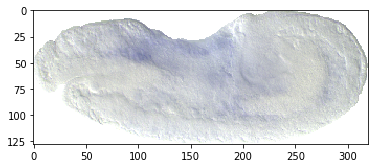

In [8]:
train_data.reset_state()
batch = next(train_data.get_data())
plt.imshow(batch[0][0][0])

In [7]:
img = batch[0][0][0]
img.dtype

dtype('uint8')

In [11]:
tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

[<tf.Tensor 'tower0/custom_cnn/conv1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_read/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_fg/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_ig/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/logits/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>]